# ToDo

- separate computation for the non correlated case
- fit elements2Run to the wavelength resolution
- modeling the FEL as discussed in the abstract
- modeling the FEL as temp. radiator with uncertain temperature
- using Fourier and Chb. for base-functions
- optimize export and graphs to compare the different evaluations better

# NewRad2023

In [1]:
import numpy as np
import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, SPD, _CMF
from empir19nrm02 import _SPD, _RES

from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity
from empir19nrm02.MC import load_from_csv, load_from_excel, MCVar, MCVectorVar, NameUnit, DistributionParam, MCSimulation,noise_list_default
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from empir19nrm02.tools import plotHistScales, plotHistGauss, plot_2D, get_data_step, seaborn_plot_result_gen, plotCorrelation

%matplotlib inline
from matplotlib import pyplot

import pandas as pd
from empir19nrm02.MC import StatDataVector

elements2Run = [-1, 0,1,2,3,4,5,6,7,8,9,10,20,30,40,47, 50,60,70,80,90,100,150,200,235]
#elements2Run = [-1]

In [2]:
# define a plot syle
plot_style = {
    'axes.spines.top': True,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.linewidth': 1,
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.major.size': 2,
    'ytick.major.size': 2,
    'axes.grid': False,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.bottom': True,
    'ytick.left': True,
}

# activate style
pyplot.style.use(plot_style)

## Some settings for the processing

In [3]:
# Calibration illuminant
S_C = 'A'
#S_C = 'L41'
print( 'Calibration with: ', S_C)

# Select the color space for evaluation
cieobs = '1931_2'
print('Color matching functions from:', cieobs)

# display the colorbar in some diagrams
spectrum_color = False

# outdir
out_dir = 'NewRad2023'

Calibration with:  A
Color matching functions from: 1931_2


## The Detector for the NewRad article is included in the general list with #128
### Load here without any uncertainty information

VLDetectors


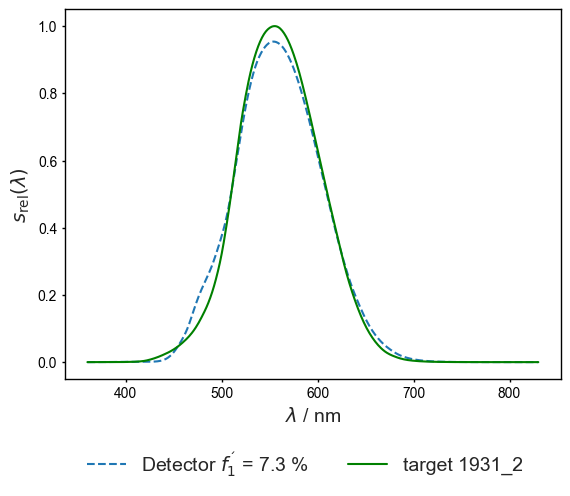

In [4]:
_detectors=_RES['VLDetectors']['S']['data'].copy()
# the detector from Yasaman (eMail: 230317)
det_number = 128
detector_tmp = np.vstack((_detectors[0], _detectors[det_number]))

# wavelength scale for further use (same scale as in the abstract/matlab code)
wl = lx.getwlr((360,830,1))

# Reference wavelength for the normalization to state the MU at this point
wlRef = 500
index_wlRef = np.argmin(np.abs(wl-wlRef))
wlStdUnc = 0.

# MCS
trials = 10000

# Parameter for the simulation
T_BB = 3100
uT_BB = 0.7


detector = lx.cie_interp(detector_tmp, wl, kind='S')
detector_norm, f1p = display_responsivity('VLDetectors', detector, cieobs=cieobs, s_target_index=2, out_dir=out_dir, S_C=S_C, spectrum_color=spectrum_color, plots=['plot1'], grid=False)


## A more general way to caculate SMCF
# $F(S_\mathrm{Z}(\lambda_\mathrm{Z}),S_\mathrm{C}(\lambda_\mathrm{C})) = \frac{F_\mathrm{C,N}}{F_\mathrm{C,D}}\frac{F_\mathrm{M,N}}{F_\mathrm{M,D}}$

# $F_\mathrm{C,N} = \int{S_\mathrm{C}(\lambda_\mathrm{C})s(\lambda_\mathrm{s})\mathrm{d}\lambda}$

# $F_\mathrm{C,D} = \int{S_\mathrm{C}(\lambda_\mathrm{C})s_\mathrm{T}(\lambda)\mathrm{d}\lambda}$

# $F_\mathrm{M,N} = \int{S_\mathrm{Z}(\lambda_\mathrm{Z})s_\mathrm{T}(\lambda_\mathrm{s})\mathrm{d}\lambda}$

# $F_\mathrm{M,D} = \int{S_\mathrm{Z}(\lambda_\mathrm{Z})s(\lambda_\mathrm{s})\mathrm{d}\lambda}$

# $F(S_\mathrm{Z}(\lambda_\mathrm{Z}),S_\mathrm{C}(\lambda_\mathrm{C})) = \underbrace{\frac{\int{S_\mathrm{C}(\lambda_\mathrm{C})s(\lambda_\mathrm{s})\mathrm{d}\lambda}}{\int{S_\mathrm{C}(\lambda_\mathrm{C})s_\mathrm{T}(\lambda)\mathrm{d}\lambda}}}_{\text{Calibration}} \dot \underbrace{\frac{\int{S_\mathrm{Z}(\lambda_\mathrm{Z})s_\mathrm{T}(\lambda)\mathrm{d}\lambda}}{\int{S_\mathrm{Z}(\lambda_\mathrm{Z})s(\lambda_\mathrm{s})\mathrm{d}\lambda}}}_{\text{Measurement}}$

| Symbol | Description |
| :-:    |  :-:   |
| $F(S_\mathrm{Z}(\lambda_\mathrm{Z}))$ | SD DUT |
|$\lambda_\mathrm{Z}$| wavelength scale for the measurment of SD DUT|
| $F(S_\mathrm{C}(\lambda_\mathrm{C}))$ | SD Calibration |
|$\lambda_\mathrm{C}$|wavelength scale for the measurement of SD Calibration|
| $s(\lambda_\mathrm{s})$ | (rel.) spectral responsivity of detetor |
|$\lambda_\mathrm{s}$|wavelength scale for the spectral responsivity measurement|
| $s_\mathrm{T}(\lambda)$ |  spectral responsivity of the target function (e.g. $V(\lambda)$ |
|$\lambda$|nominal wavelength scale|


In [5]:
g_S_C_ref = None
g_S_Z_ref = None
g_s_detector_ref = None

def smcf_set_ref( _S_C_ref, _S_Z_ref, _s_detector_ref):
    global g_S_C_ref, g_S_Z_ref, g_s_detector_ref

    if isinstance(_S_C_ref,str):
        g_S_C_ref = _CIE_ILLUMINANTS[_S_C_ref].copy()
    else:
        if isinstance(_S_C_ref, SPD):
            g_S_C_ref = np.vstack( (_S_C_ref.wl, _S_C_ref.value))
        else:
            g_S_C_ref = _S_C_ref.copy()

    if isinstance(_S_Z_ref,str):
        g_S_Z_ref = _CIE_ILLUMINANTS[_S_Z_ref].copy()
    else:
        if isinstance(_S_Z_ref, SPD):
            g_S_Z_ref = np.vstack( (_S_Z_ref.wl, _S_Z_ref.value))
        else:
            g_S_Z_ref = _S_Z_ref.copy()
    if isinstance(_S_Z_ref, SPD):
        g_s_detector_ref = np.vstack( (_s_detector_ref.wl, _s_detector_ref.value))
    else:
        g_s_detector_ref = _s_detector_ref.copy()
    return

def smcf_calculation( S_Z, s_detector, S_C='A', cieobs='1931_2', s_target_index=2, interp_kind = 'S', use_ref = False, use_global_ref = False):

    # Get illuminant:
    if isinstance(S_C,str): S_C = _CIE_ILLUMINANTS[S_C].copy()

    s_target = _CMF[cieobs]['bar'][[0,s_target_index]].copy() if isinstance(cieobs, str) else cieobs[[0,s_target_index]].copy()

    wlr = s_detector[0] # get wavelength range from the detector data
    dl = lx.getwld(wlr) # wavelength differences (unequal wavelength spacings are taken into account)
    dl = dl*np.ones_like(wlr) # ensure array like for matrix multiplication

    # Interpolate measured spectrum to desired wavelength range:
    s_target = lx.cie_interp(s_target, wlr, kind = interp_kind)[1:]
    S_C = lx.cie_interp(S_C, wlr, kind = interp_kind)[1:]
    S_Z = lx.cie_interp(S_Z, wlr, kind = interp_kind)[1:]
    s_detector = s_detector[1:]

    # taking the first information as reference
    if use_ref:
        if use_global_ref:
            S_C_ref = lx.cie_interp(g_S_C_ref, wlr, kind = interp_kind)[1:]
            S_Z_ref = lx.cie_interp(g_S_Z_ref, wlr, kind = interp_kind)[1:]
            s_detector_ref = lx.cie_interp(g_s_detector_ref, wlr, kind = interp_kind)[1:]
            S_C_ref = np.tile(S_C_ref[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z_ref[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector_ref[0],(s_detector.shape[0],1))
        else:
            S_C_ref = np.tile(S_C[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector[0],(s_detector.shape[0],1))
    else:
        S_C_ref = S_C
        S_Z_ref = S_Z
        s_detector_ref = s_detector

    use_luxpy = False
    F_M_N = 1
    F_M_D = 1
    F_C_N = 1
    F_C_D = 1
    if use_luxpy:
        # Calculate s_rel:
        s_rel = (s_target @ (S_C_ref*dl).T) / (s_detector_ref @ (S_C*dl).T) * s_detector
        # Calculate spectral mismatch correction factors:
        F = (S_Z_ref @ (s_target*dl).T) / (S_Z @ (s_rel*dl).T)
    else:
        # Calculate spectral mismatch correction factors:
        F_M_N = (S_Z_ref @ (s_target*dl).T)
        F_M_D = (S_Z @ (s_detector*dl).T)
        F_C_N = (S_C @ (s_detector_ref*dl).T)
        F_C_D = (S_C_ref @ (s_target*dl).T)
        F = F_C_N/F_C_D * F_M_N/F_M_D

    return F, F_C_N, F_C_D, F_M_N, F_M_D

In [6]:
def plotMCResult( wl, mcVarData:StatDataVector, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g--'
    else:
        if diagnumber == 1:
            color1 = 'r--'
            color2 = 'g--'
        else:
            color1 = 'r-.'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean/np.max(mcVarData.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    relData = np.divide(mcVarData.v_std, mcVarData.v_mean, out=np.zeros_like(mcVarData.v_std), where=mcVarData.v_mean!=0)

    ax2.plot(wl,relData, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel('Signal / A.U', color = 'red', fontsize=label_font_size)
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green',fontsize=label_font_size)
    ax1.grid( visible=False)
    ax2.grid( visible=False)
    ax1.tick_params(bottom=True, top=False, left=True, right=False)
    ax1.tick_params(direction='out')
    ax2.tick_params(bottom=True, top=False, left=False, right=True)
    ax2.tick_params(direction='out')
    for spine in pyplot.gca().spines.values():
        spine.set_edgecolor('black')

    if title:
        ax1.set_title(title)
    #fig.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False)
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2, frameon=False, fontsize=label_font_size)
    #fig.legend(frameon=False)
    return fig, ax1, ax2

# Use FEL Lamp-1 from the PTB set

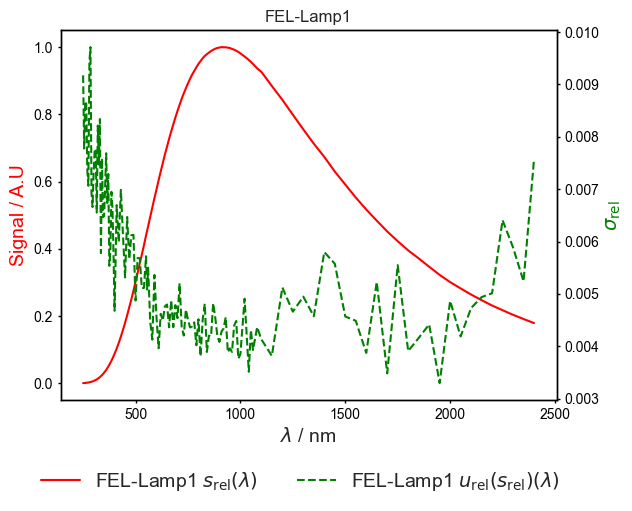

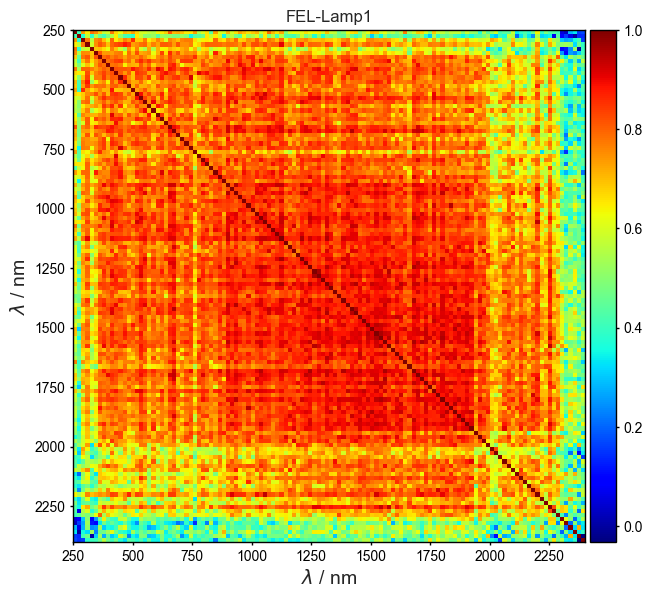

In [7]:
str_FEL_file = 'PTBResFEL-1000W-Lamp-1'
str_FEL_short = 'FEL-Lamp1'
wlFEL, mcVectorVarFEL = load_from_csv(_CORR_PATH + '/' + str_FEL_file)
mcVectorVarFEL.name = NameUnit( str_FEL_file, 'A.U.')

fig, ax1, ax2 = plotMCResult(wlFEL, mcVectorVarFEL.setData, str_FEL_short)
plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, str_FEL_short)

## Interpolate the lamp data to the wl scale of the simulation

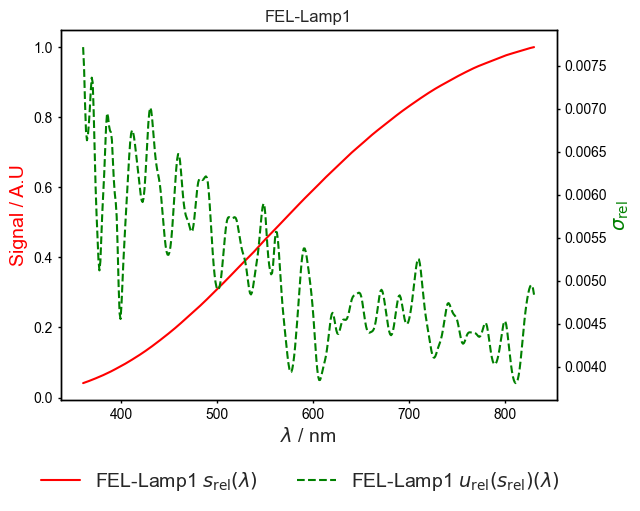

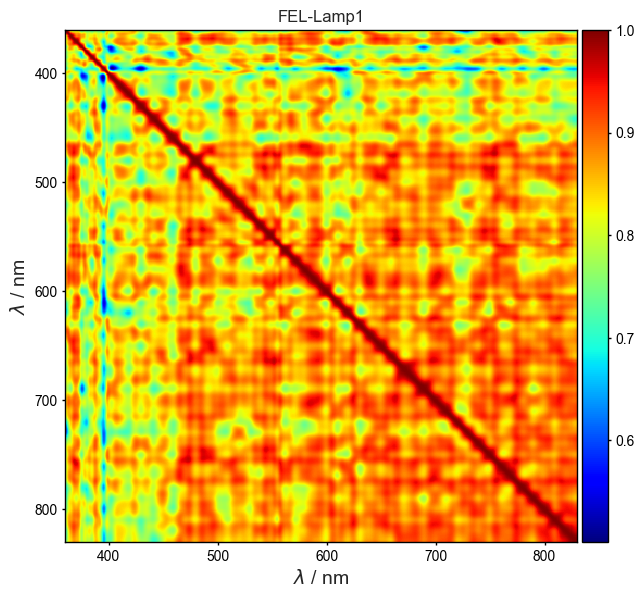

In [8]:
# put the data at the same WL-Scale
if len(wl) != mcVectorVarFEL.elements:
    mcVectorVarFEL.interpolate(wl, wlFEL, trials=trials)

fig, ax1, ax2 = plotMCResult(wl, mcVectorVarFEL.setData, str_FEL_short)
save_fig(out_dir, 'FEL_SDi')

plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, str_FEL_short)
save_fig(out_dir, 'FEL_Corri')

_spectra = np.vstack((wl, mcVectorVarFEL.setData.v_mean))

## Use Photometer information from PTB Data (only the uncertainty, the spectral responsivity is taken from #128)

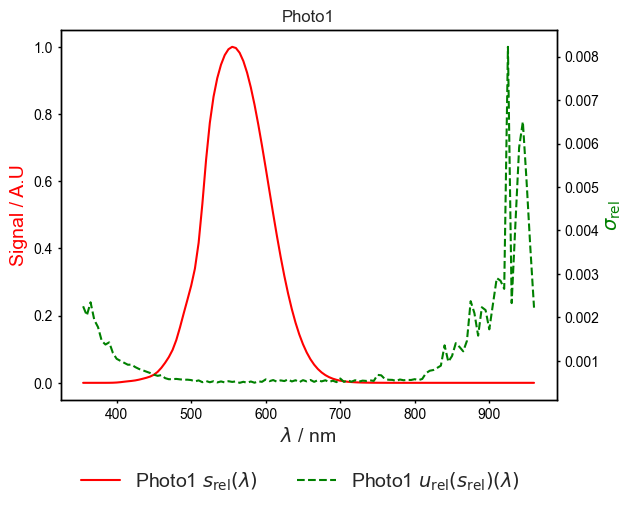

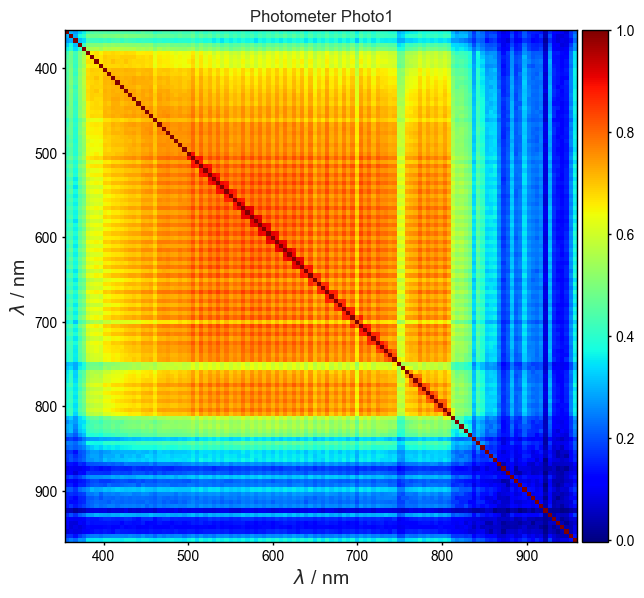

In [9]:
str_Phot_file = 'Add_PTBResPhot1'
str_Phot_short = 'Photo1'
wlPhot, mcVarDetector = load_from_excel(filename = _CORR_PATH + '/' + str_Phot_file, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
mcVarDetector.name = NameUnit( str_Phot_file, 'A.U.')

fig, ax1, ax2 = plotMCResult(wlPhot, mcVarDetector.setData, title=str_Phot_short)
save_fig(out_dir, 'Phot_srel')

plotCorrelation(mcVarDetector.setData.corr_matrix, wlPhot, 'Photometer ' + str_Phot_short)
save_fig(out_dir, 'Phot_corr')


## Interpolate the photometer data to the wl scale of the simulation

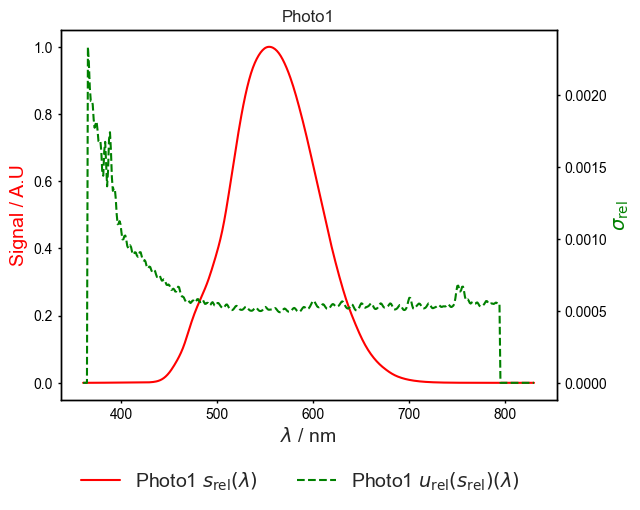

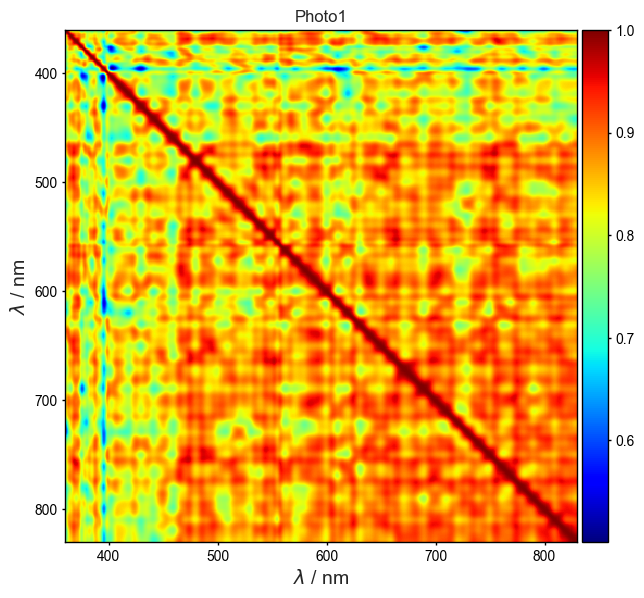

In [10]:
# put the data at the same WL-Scale
if len(wl) != mcVarDetector.elements:
    mcVarDetector.interpolate(wl, wlPhot, trials=trials)

# hold the relative standard deviation constant
v_std_rel = np.divide(mcVarDetector.setData.v_std, mcVarDetector.setData.v_mean, out=np.zeros_like(mcVarDetector.setData.v_std), where=mcVarDetector.setData.v_mean!=0)

# Use the mean value from detector #128 (hold the uncertainty data from the PTB measurements)
mcVarDetector.set_vector_param( detector[1], v_std=v_std_rel*detector[1], corr=mcVarDetector.setData.corr_matrix)

# Use the mean value from detector #128 (hold the uncertainty data from the PTB measurements)
noise_list_photo0 = { 'f_mul': DistributionParam(mean=1, stddev=0.0005, add_params='f ' + '0' + ' o')}
mcVarDetector0 = MCVectorVar(name=NameUnit('Photo0_f0', 'nm'), elements=len(wl), noise_list=noise_list_photo0)
mcVarDetector0.set_vector_param(detector[1])
noise_list_photo235 = { 'f_mul': DistributionParam(mean=1, stddev=0.0005, add_params='f ' + '235' + ' o')}
mcVarDetector235 = MCVectorVar(name=NameUnit('Photo0_f235', 'nm'), elements=len(wl), noise_list=noise_list_photo235)
mcVarDetector235.set_vector_param(detector[1])

mcVarDetectorUC = MCVectorVar(name=NameUnit('Photo0_uc', 'nm'), elements=len(wl))
mcVarDetectorUC.set_vector_param(detector[1], v_std=0.0005*detector[1])

fig, ax1, ax2 = plotMCResult(wl, mcVarDetector.setData, str_Phot_short)
save_fig(out_dir, 'Phot_SDi')

plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, str_Phot_short)
save_fig(out_dir, 'Phot_Corri')

_detector = np.vstack((wl, mcVarDetector.setData.v_mean))


## Generate some uncertainty information for the calibration light source

In [11]:
from empir19nrm02.tools import draw_values_gum, sumMC

wl_calibration_MC = MCVectorVar(name=NameUnit('wl calibration', 'nm'), elements=len(wl))
wl_calibration_MC.set_vector_param(wl, v_std=np.ones(len(wl))*wlStdUnc)
wl_calibration_MC.allocate(trials)

wl_detector_MC = MCVectorVar(name=NameUnit('wl detector', 'nm'), elements=len(wl))
wl_detector_MC .set_vector_param(wl, v_std=np.ones(len(wl))*wlStdUnc)
wl_detector_MC .allocate(trials)

wl_spectra_MC = MCVectorVar(name=NameUnit('wl spectra', 'nm'), elements=len(wl))
wl_spectra_MC .set_vector_param(wl, v_std=np.ones(len(wl))*wlStdUnc)
wl_spectra_MC .allocate(trials)


calibrationMC = MCVectorVar(name=NameUnit('uncertain A', 'A.U.'), elements=len(wl))
calibrationMC0 = MCVectorVar(name=NameUnit('uncertain A0', 'A.U.'), elements=len(wl))

# normalized to the value at 555nm
stdIllA = lx.cie_interp(_CIE_ILLUMINANTS['A'], wl, kind = 'S')[1:]
stdIllA[0] /= stdIllA[0][index_wlRef]
print( stdIllA[0].shape)

# normalized to the maximum value
refSourceL41 = lx.cie_interp(_CIE_ILLUMINANTS['L41'], wl, kind = 'S')[1:]
refSourceL41 /= np.max(refSourceL41)

# random uncertainty 1%
calibrationMC.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.01)
calibrationMC.generate_numbers(trials=trials)

calibrationMC0.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.00)
calibrationMC0.generate_numbers(trials=trials)

# BB's with an uncertain temperature and different normalization strategies
calibrationMCT = MCVectorVar(name=NameUnit('uncertain A T', 'A.U.'), elements=len(wl))
calibrationMCT.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.0)
calibrationMCT.allocate(trials)

calibrationMCT1 = MCVectorVar(name=NameUnit('uncertain A T1', 'A.U.'), elements=len(wl))
calibrationMCT1.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.0)
calibrationMCT1.allocate(trials)

calibrationMCT2 = MCVectorVar(name=NameUnit('uncertain A T2', 'A.U.'), elements=len(wl))
calibrationMCT2.set_vector_param(stdIllA[0], v_std=np.ones(len(wl))*0.0)
calibrationMCT2.allocate(trials)

#generate the MC data in front f the MCS
temp = draw_values_gum(mean=T_BB, stddev=uT_BB, draws=calibrationMCT.setParam.trials, distribution="normal")
bbTempRef = lx.spectrum.blackbody(T_BB, wl3=wl, relative=False)
bbTempRef_max = np.max(bbTempRef[1])

for i in range(calibrationMCT.setParam.trials):
    # bb without normalization
    calibrationMCT.val[i] = lx.spectrum.blackbody(temp[i], wl3=wl, relative=False)[1:]/bbTempRef_max
    # normalization at 555nm from the reference BB
    calibrationMCT1.val[i] = calibrationMCT.val[i] / bbTempRef[1][index_wlRef]
    # normalization at 555nm for each trial separately
    calibrationMCT2.val[i] = calibrationMCT.val[i] / calibrationMCT.val[i][index_wlRef]

# calculate the statisitcal data
calibrationMCT.calc_cov_matrix_from_data()
calibrationMCT1.calc_cov_matrix_from_data()
calibrationMCT2.calc_cov_matrix_from_data()
# hold the data and do not generate them in the MCS again
calibrationMCT.use_current_data = True
calibrationMCT1.use_current_data = True
calibrationMCT2.use_current_data = True


(471,)


## Plot the properties of the BB data for all tests

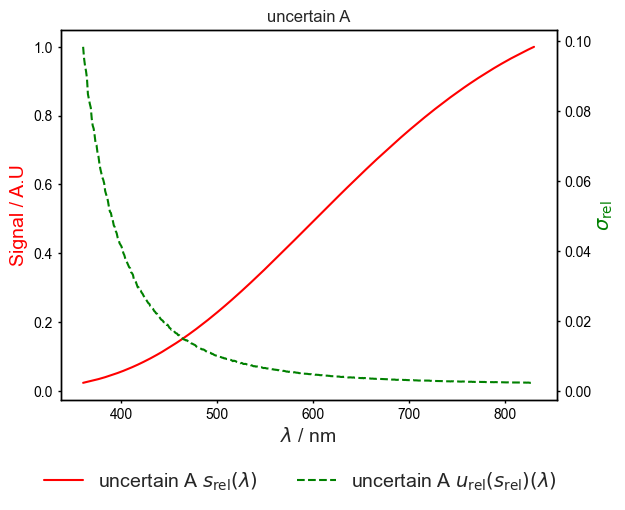

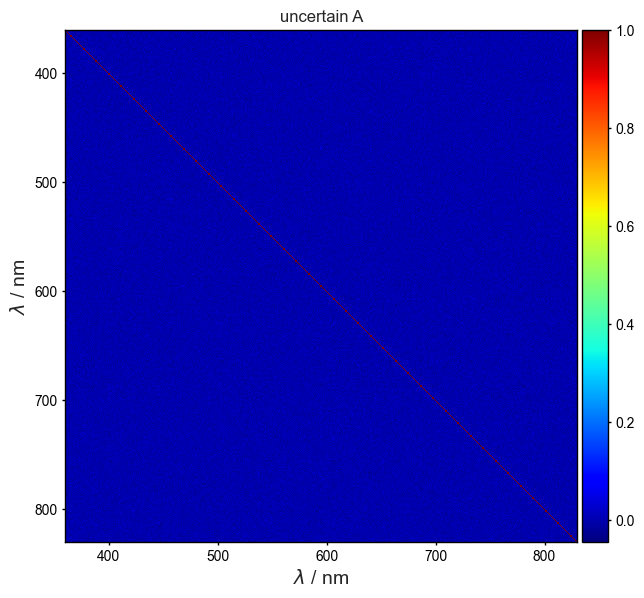

[[2855.519350391417, 1.6500400921219105], [2852.3164598369026, 2858.771207984735]]


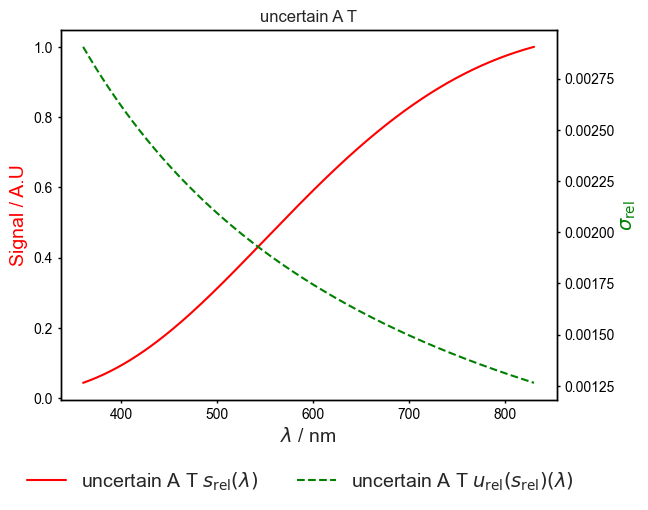

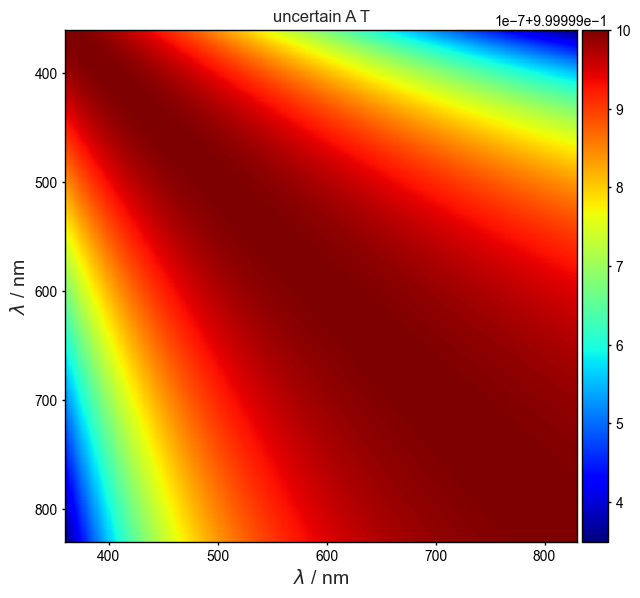

[[3099.989312728212, 0.6985751240472405], [3098.618307923527, 3101.352596971263]]


In [12]:
for mc in [calibrationMC, calibrationMCT]:
    fig, ax1, ax2 = plotMCResult(wl, mc.runData, mc.name.name)
    save_fig(out_dir, mc.name.name + '_SDi')

    plotCorrelation(mc.runData.corr_matrix, wl, mc.name.name)
    save_fig(out_dir, mc.name.name + '_Corri')
    tmpData = np.vstack( (wl, mc.val))
    tmpCCT = lx.xyz_to_cct(lx.spd_to_xyz( tmpData, relative=False, cieobs='1931_2'))
    print( sumMC(tmpCCT))

In [13]:
SMCF_A = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, _detector, S_C='A', cieobs='1931_2', s_target_index=2)
print( f'SMCF for calibration with standard illuminant A: {SMCF_A[0][0]:.6}')
SMCF_L41 = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, _detector, S_C='L41', cieobs='1931_2', s_target_index=2)
print( f'SMCF for calibration with standard illuminant L41: {SMCF_L41[0][0]:.6}')

SMCF for calibration with standard illuminant A: 1.00049
SMCF for calibration with standard illuminant L41: 0.984234


# Check the more general SMCF calculation

In [14]:
F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( _spectra, _detector, S_C='A', cieobs='1931_2', s_target_index=2)
print(f'CIE standard illuminant A: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')

F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( _spectra, _detector, S_C='L41', cieobs='1931_2', s_target_index=2)
print(f'CIE reference source L41: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')

F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( np.vstack((wl, mcVectorVarFEL.setData.v_mean)), np.vstack((wl, mcVarDetector.setData.v_mean)), S_C='L41', cieobs='1931_2', s_target_index=2)
print(f'CIE reference source L41: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')


CIE standard illuminant A: [[1.0005e+00]], [[1.1313e+04]], [[1.0790e+04]], [[5.0610e+00]], [[5.3040e+00]] --> reduced: [[9.5417e-01]]
CIE reference source L41: [[9.8423e-01]], [[1.5102e+03]], [[1.4641e+03]], [[5.0610e+00]], [[5.3040e+00]] --> reduced: [[9.5417e-01]]
CIE reference source L41: [[9.8423e-01]], [[1.5102e+03]], [[1.4641e+03]], [[5.0610e+00]], [[5.3040e+00]] --> reduced: [[9.5417e-01]]


# MCS

In [15]:
calibrationArray = np.ndarray((2, 21, len(wl)))
currentTrial = 0

In [16]:

def runSimpleMC( calibrationMC, wl_calibrationMC,  spectraMC, wl_spectraMC, detectorMC, wl_detectorMC, SMCF, calib_cct, NumberTrials, model_single):
    input = [calibrationMC, wl_calibrationMC, spectraMC, wl_spectraMC, detectorMC, wl_detectorMC]
    output = [SMCF, calib_cct]

    sim = MCSimulation(trials=NumberTrials)
    sim.set_input_var(input)
    sim.set_output_var(output)
    sim.generate()
    sim.calculate_model( model_single)
    return sim.output_var, sim.get_result_db()

def model_single(calibration, wl_calibration, spectra, wl_spectra, detector, wl_detector):
    spectmp1 = np.vstack( (wl_spectra, spectra) )
    spectmp = lx.cie_interp(spectmp1, wl_new = wl, kind='S')
    detectortmp1 = np.vstack( (wl_detector, detector) )
    detectortmp = lx.cie_interp(detectortmp1, wl_new = wl, kind='S')
    calibrationtmp1 = np.vstack( (wl_calibration, calibration))
    calibrationtmp = lx.cie_interp(calibrationtmp1, wl_new = wl, kind='S')
    #global currentTrial
    #calibrationArray[0, currentTrial] = wl_calibration
    #calibrationArray[1, currentTrial] = calibrationtmp[1]
    #currentTrial+=1

    cct = lx.xyz_to_cct(lx.spd_to_xyz( calibrationtmp, relative=False, cieobs='1931_2'))[0,0]
    SMCF_g, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( spectmp, detectortmp, S_C=calibrationtmp, cieobs='1931_2', s_target_index=2, use_ref=False, use_global_ref=False)
    SMCF_a = np.zeros(7)
    SMCF_a[0] = SMCF_g[0][0]
    SMCF_a[1] = F_C_N[0][0]
    SMCF_a[2] = F_C_D[0][0]
    SMCF_a[3] = F_M_N[0][0]
    SMCF_a[4] = F_M_D[0][0]
    SMCF_a[5] = F_C_N[0][0] / F_C_D[0][0]
    SMCF_a[6] = F_M_N[0][0] / F_M_D[0][0]
    return [SMCF_a, cct]

In [17]:
def get_name(i:int)->str:
    return mcResult_db['Input'].values[i]

column_str_MC = ['F','F_{\mathrm{C,N}}','F_{\mathrm{C,D}}','F_{\mathrm{M,N}}','F_{\mathrm{M,D}}','F_{\mathrm{C}}','F_{\mathrm{M}}']
def get_item_name(i:int, use_math = True)->str:
    if use_math:
        return '$' + column_str_MC[i] + '$'
    else:
        return column_str_MC[i]

In [18]:
# define the results (SMCF, the single integrals and the ratios from calibration and measurement)
SMCF_MC = MCVectorVar( name = NameUnit(column_str_MC, ['' for _ in column_str_MC]), elements=len(column_str_MC))
calib_cct = MCVar(name = NameUnit("calib. CCT",'K'))

# Simulation of the influence of the color temperature 0.7K to the SMCF Value

In [19]:
mcResult, mcResult_db = runSimpleMC( calibrationMC0, wl_calibration_MC, calibrationMCT1, wl_spectra_MC, mcVarDetector, wl_detector_MC,SMCF_MC, calib_cct, trials, model_single)

str_observe ='F_{\mathrm{M}}'
print ( f"{str_observe}: {mcResult_db[str_observe].iloc[2]:e} | u({str_observe}): {mcResult_db['u('+str_observe + ')'].iloc[2]:e}")

mcResult_db

F_{\mathrm{M}}: 9.541307e-01 | u(F_{\mathrm{M}}): 7.102369e-07


Input  Unit         Mean     StdDev   Distr          F   
0     uncertain A0  A.U.   2.13077748 0.00000000  normal 1.00000000  \
0   wl calibration    nm 595.00000000 0.00000000  normal 1.00000000   
0   uncertain A T1  A.U.   2.13077748 0.00000000  normal 1.00000055   
0       wl spectra    nm 595.00000000 0.00000000  normal 1.00000000   
0  Add_PTBResPhot1  A.U.   0.23863473 0.00012488  normal 0.99999999   
0      wl detector    nm 595.00000000 0.00000000  normal 1.00000000   
0              All         0.00000000 0.00000000         1.00000054   

        u(F)  F_{\mathrm{C,N}}  u(F_{\mathrm{C,N}})  F_{\mathrm{C,D}}  ...   
0 0.00000000      188.99189297           0.00000000      180.24325806  ...  \
0 0.00000000      188.99189297           0.00000000      180.24325806  ...   
0 0.00000074      188.99189297           0.00000000      180.24325806  ...   
0 0.00000000      188.99189297           0.00000000      180.24325806  ...   
0 0.00000272      188.99148562           0.08829196      180.24325806  ...   
0 0.00000000      188.99189297           0.00000000      180.24325806  ...   
0 0.00000283      188.99148562           0.08829196      180.24325806  ...   

   F_{\mathrm{M,N}}  u(F_{\mathrm{M,N}})  F_{\mathrm{M,D}}   
0        0.00000000           0.00000000        0.00000000  \
0        0.00000000           0.00000000        0.00000000   
0        0.00000000           0.00000000        0.00000000   
0        0.00000000           0.00000000        0.00000000   
0        0.00000000           0.00000000        0.00000000   
0        0.00000000           0.00000000        0.00000000   
0        0.00000000           0.00000000        0.00000000   

   u(F_{\mathrm{M,D}})  F_{\mathrm{C}}  u(F_{\mathrm{C}})  F_{\mathrm{M}}   
0           0.00000000      1.04853793         0.00000000      0.95413020  \
0           0.00000000      1.04853793         0.00000000      0.95413020   
0           0.00000000      1.04853793         0.00000000      0.95413072   
0           0.00000000      1.04853793         0.00000000      0.95413020   
0           0.00000000      1.04853567         0.00048985      0.95413246   
0           0.00000000      1.04853793         0.00000000      0.95413020   
0           0.00000000      1.04853567         0.00048985      0.95413298   

   u(F_{\mathrm{M}})     calib. CCT  u(calib. CCT)  
0         0.00000000 2,855.54268804     0.00000000  
0         0.00000000 2,855.54268804     0.00000000  
0         0.00000071 2,855.54268804     0.00000000  
0         0.00000000 2,855.54268804     0.00000000  
0         0.00044564 2,855.54268804     0.00000000  
0         0.00000000 2,855.54268804     0.00000000  
0         0.00044564 2,855.54268804     0.00000000  

[7 rows x 21 columns]

# Simulation of the influence of the photometer value 0.05% correlated noise (uncorrelated for the integral value) to the SMCF Value

In [20]:
for mc in [mcVarDetector0, mcVarDetector235, mcVarDetectorUC]:
    mcResult, mcResult_db = runSimpleMC( calibrationMC, wl_calibration_MC, calibrationMCT, wl_spectra_MC, mc, wl_detector_MC,SMCF_MC, calib_cct, trials, model_single)

    str_observe ='F_{\mathrm{M}}'
    print ( f"{mc.name}:{str_observe}: {mcResult_db[str_observe].iloc[4]:e} | u({str_observe}): {mcResult_db['u('+str_observe + ')'].iloc[4]:e}")

mcResult_db

NameUnit(name='Photo0_f0', unit='nm'):F_{\mathrm{M}}: 9.541304e-01 | u(F_{\mathrm{M}}): 4.770414e-04
NameUnit(name='Photo0_f235', unit='nm'):F_{\mathrm{M}}: 9.541297e-01 | u(F_{\mathrm{M}}): 4.395532e-05
NameUnit(name='Photo0_uc', unit='nm'):F_{\mathrm{M}}: 9.541302e-01 | u(F_{\mathrm{M}}): 3.863214e-05


Input  Unit         Mean     StdDev   Distr          F       u(F)   
0     uncertain A  A.U.   2.13077748 0.01000000  normal 1.00000004 0.00003237  \
0  wl calibration    nm 595.00000000 0.00000000  normal 1.00000000 0.00000000   
0   uncertain A T  A.U.   2.13077748 0.00000000  normal 1.00000055 0.00000074   
0      wl spectra    nm 595.00000000 0.00000000  normal 1.00000000 0.00000000   
0       Photo0_uc    nm   0.23863473 0.00011932  normal 1.00000000 0.00000153   
0     wl detector    nm 595.00000000 0.00000000  normal 1.00000000 0.00000000   
0             All         0.00000000 0.00000000         1.00000058 0.00003242   

   F_{\mathrm{C,N}}  u(F_{\mathrm{C,N}})  F_{\mathrm{C,D}}  ...   
0      188.99265927           0.08922312      180.24398333  ...  \
0      188.99189297           0.00000000      180.24325806  ...   
0      188.99189297           0.00000000      180.24325806  ...   
0      188.99189297           0.00000000      180.24325806  ...   
0      188.99190247           0.00765410      180.24325806  ...   
0      188.99189297           0.00000000      180.24325806  ...   
0      188.99266865           0.08961891      180.24398333  ...   

   F_{\mathrm{M,N}}  u(F_{\mathrm{M,N}})  F_{\mathrm{M,D}}   
0       51.28163581           0.00000000       53.74700002  \
0       51.28163581           0.00000000       53.74700002   
0       51.35166595           0.09471383       53.82036721   
0       51.28163581           0.00000000       53.74700002   
0       51.28163581           0.00000000       53.74700281   
0       51.28163581           0.00000000       53.74700002   
0       51.35166595           0.09471383       53.82036999   

   u(F_{\mathrm{M,D}})  F_{\mathrm{C}}  u(F_{\mathrm{C}})  F_{\mathrm{M}}   
0           0.00000000      1.04853797         0.00003394      0.95413020  \
0           0.00000000      1.04853793         0.00000000      0.95413020   
0           0.09922708      1.04853793         0.00000000      0.95413072   
0           0.00000000      1.04853793         0.00000000      0.95413020   
0           0.00217619      1.04853798         0.00004247      0.95413015   
0           0.00000000      1.04853793         0.00000000      0.95413020   
0           0.09924594      1.04853802         0.00005430      0.95413068   

   u(F_{\mathrm{M}})     calib. CCT  u(calib. CCT)  
0         0.00000000 2,855.54365979     1.63642043  
0         0.00000000 2,855.54268804     0.00000000  
0         0.00000071 2,855.54268804     0.00000000  
0         0.00000000 2,855.54268804     0.00000000  
0         0.00003863 2,855.54268804     0.00000000  
0         0.00000000 2,855.54268804     0.00000000  
0         0.00003864 2,855.54365979     1.63642043  

[7 rows x 21 columns]

In [21]:
# run the MCS

mcResultList = []

str_observe = column_str_MC[6]
index_observe = 6
observed_value = []
observed_uvalue = []

for index, petriNumber in enumerate(elements2Run):
    print ( f'Simulation number : {index}, PetriNumber: {petriNumber}')
    if petriNumber == -1:
        # use the original calibration data (FEL, Photoelement from PTB)
        mcResult, mcResult_db = runSimpleMC( calibrationMCT, wl_calibration_MC, mcVectorVarFEL, wl_spectra_MC, mcVarDetector, wl_detector_MC,SMCF_MC, calib_cct, trials, model_single)
    else:

        # the basic versions of FEL and Photometer do not use the correlation information (only value and standard deviation)
        noise_list = { 'f_mul': DistributionParam(mean=1, stddev=0.002, add_params='f ' + str(petriNumber) + ' o')}

        mcVectorVarFEL_basic = MCVectorVar(name=mcVectorVarFEL.name, elements=mcVectorVarFEL.elements, noise_list=noise_list)
        mcVectorVarFEL_basic.set_vector_param( mcVectorVarFEL.setData.v_mean, v_std=mcVectorVarFEL.setData.v_std)

        noise_list_det = { 'f_mul': DistributionParam(mean=1, stddev=0.0005, add_params='f ' + str(petriNumber) + ' o')}

        mcVarDetector_basic = MCVectorVar(name=mcVarDetector.name, elements=mcVarDetector.elements, noise_list=noise_list_det)
        mcVarDetector_basic.set_vector_param( mcVarDetector.setData.v_mean, v_std=mcVarDetector.setData.v_std)

        mcResult, mcResult_db = runSimpleMC( calibrationMCT, wl_calibration_MC, mcVectorVarFEL_basic, wl_spectra_MC, mcVarDetector_basic, wl_detector_MC,SMCF_MC, calib_cct, trials, model_single)

    print ( f"{str_observe}: {mcResult_db[str_observe].iloc[index_observe]:.8f} | u({str_observe}): {mcResult_db['u('+str_observe + ')'].iloc[index_observe]:.8f}")
    mcResultList.append(mcResult)

    mcResult_db = mcResult_db.assign(TRIALS=trials)
    mcResult_db = mcResult_db.assign(E2R=petriNumber)

    temp_cols=mcResult_db.columns.tolist()
    new_cols=temp_cols[-2:] + temp_cols[:-2]
    mcResult_db = mcResult_db[new_cols]

    if index == 0:
        mcResult_db_merge = mcResult_db.copy()
    else:
        mcResult_db_merge = pd.concat([mcResult_db_merge, mcResult_db])



Simulation number : 0, PetriNumber: -1
F_{\mathrm{M}}: 0.95417892 | u(F_{\mathrm{M}}): 0.00044998
Simulation number : 1, PetriNumber: 0
F_{\mathrm{M}}: 0.95418002 | u(F_{\mathrm{M}}): 0.00047704
Simulation number : 2, PetriNumber: 1
F_{\mathrm{M}}: 0.95417109 | u(F_{\mathrm{M}}): 0.00044276
Simulation number : 3, PetriNumber: 2
F_{\mathrm{M}}: 0.95418216 | u(F_{\mathrm{M}}): 0.00038789
Simulation number : 4, PetriNumber: 3
F_{\mathrm{M}}: 0.95417100 | u(F_{\mathrm{M}}): 0.00034233
Simulation number : 5, PetriNumber: 4
F_{\mathrm{M}}: 0.95417159 | u(F_{\mathrm{M}}): 0.00030735
Simulation number : 6, PetriNumber: 5
F_{\mathrm{M}}: 0.95417410 | u(F_{\mathrm{M}}): 0.00028136
Simulation number : 7, PetriNumber: 6
F_{\mathrm{M}}: 0.95417318 | u(F_{\mathrm{M}}): 0.00026285
Simulation number : 8, PetriNumber: 7
F_{\mathrm{M}}: 0.95417761 | u(F_{\mathrm{M}}): 0.00024382
Simulation number : 9, PetriNumber: 8
F_{\mathrm{M}}: 0.95417187 | u(F_{\mathrm{M}}): 0.00023322
Simulation number : 10, Petri

In [22]:
#np.savetxt(out_dir + '/test0.csv', calibrationArray[0], delimiter=',')
#np.savetxt(out_dir + '/test1.csv', calibrationArray[1], delimiter=',')

In [23]:
trials

10000

In [24]:
mcResult_db_merge

TRIALS  E2R                   Input  Unit         Mean     StdDev   
0    10000   -1           uncertain A T  A.U.   2.13077748 0.00000000  \
0    10000   -1          wl calibration    nm 595.00000000 0.00000000   
0    10000   -1  PTBResFEL-1000W-Lamp-1  A.U.   0.05002378 0.00022769   
0    10000   -1              wl spectra    nm 595.00000000 0.00000000   
0    10000   -1         Add_PTBResPhot1  A.U.   0.23863473 0.00012488   
..     ...  ...                     ...   ...          ...        ...   
0    10000  235  PTBResFEL-1000W-Lamp-1  A.U.   1.00000000 0.00200000   
0    10000  235              wl spectra    nm 595.00000000 0.00000000   
0    10000  235         Add_PTBResPhot1  A.U.   1.00000000 0.00050000   
0    10000  235             wl detector    nm 595.00000000 0.00000000   
0    10000  235                     All         0.00000000 0.00000000   

             Distr          F       u(F)  F_{\mathrm{C,N}}  ...   
0           normal 0.99999945 0.00000074       53.82036721  ...  \
0           normal 1.00000000 0.00000000       53.74700002  ...   
0           normal 1.00000027 0.00002768       53.74700002  ...   
0           normal 1.00000000 0.00000000       53.74700002  ...   
0           normal 1.00000000 0.00000025       53.74680404  ...   
..             ...        ...        ...               ...  ...   
0   normal f 235 o 0.99999996 0.00000874       53.74700002  ...   
0           normal 1.00000000 0.00000000       53.74700002  ...   
0   normal f 235 o 1.00000000 0.00000014       53.74701404  ...   
0           normal 1.00000000 0.00000000       53.74700002  ...   
0                  0.99999941 0.00000877       53.82038129  ...   

    F_{\mathrm{M,N}}  u(F_{\mathrm{M,N}})  F_{\mathrm{M,D}}   
0         5.06098687           0.00000000        5.30404491  \
0         5.06098687           0.00000000        5.30404491   
0         5.06087308           0.02347508        5.30392435   
0         5.06098687           0.00000000        5.30404491   
0         5.06098687           0.00000000        5.30402555   
..               ...                  ...               ...   
0         5.06097659           0.00095233        5.30403435   
0         5.06098687           0.00000000        5.30404491   
0         5.06098687           0.00000000        5.30404629   
0         5.06098687           0.00000000        5.30404491   
0         5.06097659           0.00095233        5.30403573   

    u(F_{\mathrm{M,D}})  F_{\mathrm{C}}  u(F_{\mathrm{C}})  F_{\mathrm{M}}   
0            0.00000000      1.04807442         0.00000078      0.95417497  \
0            0.00000000      1.04807499         0.00000000      0.95417497   
0            0.02462763      1.04807499         0.00000000      0.95417522   
0            0.00000000      1.04807499         0.00000000      0.95417497   
0            0.00249647      1.04807117         0.00049330      0.95417866   
..                  ...             ...                ...             ...   
0            0.00097529      1.04807499         0.00000000      0.95417493   
0            0.00000000      1.04807499         0.00000000      0.95417497   
0            0.00024406      1.04807526         0.00004821      0.95417472   
0            0.00000000      1.04807499         0.00000000      0.95417497   
0            0.00100662      1.04807469         0.00004821      0.95417468   

    u(F_{\mathrm{M}})     calib. CCT  u(calib. CCT)  
0          0.00000000 3,099.98931273     0.69857512  
0          0.00000000 3,099.47302341     0.00000000  
0          0.00002641 3,099.47302341     0.00000000  
0          0.00000000 3,099.47302341     0.00000000  
0          0.00044911 3,099.47302341     0.00000000  
..                ...            ...            ...  
0          0.00000834 3,099.47302341     0.00000000  
0          0.00000000 3,099.47302341     0.00000000  
0          0.00004390 3,099.47302341     0.00000000  
0          0.00000000 3,099.47302341     0.00000000  
0          0.00004475 3,099.989312

In [25]:
strDataBase = out_dir + '/database.csv'
strDataBase_k = out_dir + '/database_k.csv'

mcResult_db_merge.to_csv(strDataBase, index=False, sep=';', decimal='.', float_format='%.7f', mode='w')
mcResult_db_merge.to_csv(strDataBase_k, index=False, sep=';', decimal=',', float_format='%.7f', mode='w')

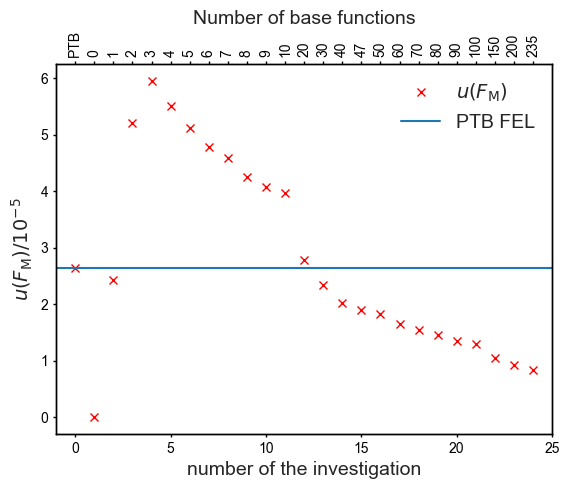

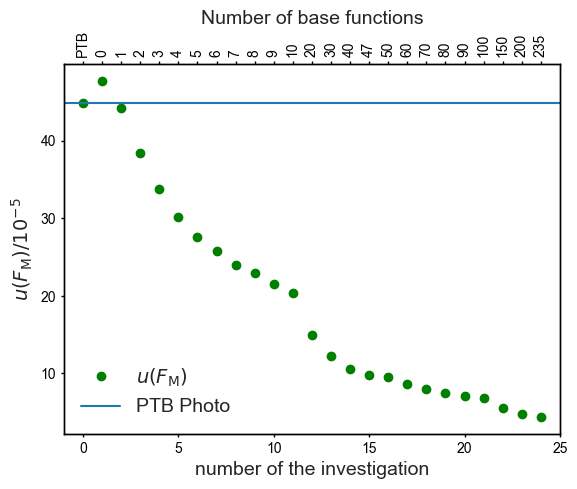

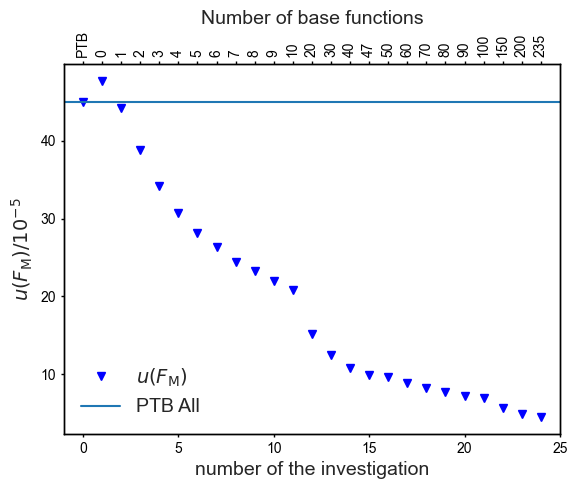

In [26]:
import matplotlib.ticker as ticker
#column_str_MC = ['F','F_{\mathrm{C,N}}','F_{\mathrm{C,D}}','F_{\mathrm{M,N}}','F_{\mathrm{M,D}}','F_{\mathrm{C}}','F_{\mathrm{M}}']

str_observe = column_str_MC[6]
#str_observe = 'calib. CCT'
index_observe_list = [2,4,6]
index_observe_name = ['FEL', 'Photo', 'All']

# to be moved to plotting ...
marker = ['-', '--', '-.',':']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

for i, index_observe in enumerate(index_observe_list):
    fig, ax = pyplot.subplots()
    element_list = []
    observed_uvalue = []
    for index in range(len(elements2Run)):
        element = elements2Run[index]
        dfq = mcResult_db_merge.query("E2R==@element")
        element_list.append(index)
        observed_uvalue.append(dfq['u(' + str_observe + ')'].iloc[index_observe] / 1e-5)
    ax.plot(element_list, observed_uvalue, mColor[i]+point_marker[i], label='$u(' + str_observe + ')$')


    ax.axhline(observed_uvalue[0], label='PTB ' + index_observe_name[i])
    ax.legend(frameon=False,fontsize=label_font_size)

    ax.set_xlabel(r"number of the investigation",fontsize=label_font_size)
    ax.set_ylabel('$u(' + str_observe + ') / 10^{-5}$',fontsize=label_font_size)
    ax.set_xlim([-1, len(elements2Run)])
    ax2 = ax
    ax2 = ax.twiny()
    new_tick_locations = [x for x in range(len(elements2Run))]
    def tick_function(X):
        return ["%d" % elements2Run[z] if elements2Run[z]!=-1 else 'PTB' for z in X]
    new_labels = tick_function(new_tick_locations)
    ax2.set_xlim([-1, len(elements2Run)])
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(new_labels)
    ax2.set_xlabel(r"Number of base functions",fontsize=label_font_size)
    pyplot.tick_params(axis='both', labelrotation=90, labelsize=10)

    formatter = ticker.ScalarFormatter(useOffset=False, useMathText=False)
    ax.yaxis.set_major_formatter(formatter)
    save_fig(out_dir, 'BaseFunctionsFEL' + str(i))

In [27]:
mcResult = mcResultList[index_observe]

element = elements2Run[index_observe]
mcResult_db = mcResult_db_merge.query("E2R==@element")

mcResult_db

TRIALS  E2R                   Input  Unit         Mean     StdDev   
0   10000    5           uncertain A T  A.U.   2.13077748 0.00000000  \
0   10000    5          wl calibration    nm 595.00000000 0.00000000   
0   10000    5  PTBResFEL-1000W-Lamp-1  A.U.   1.00000000 0.00200000   
0   10000    5              wl spectra    nm 595.00000000 0.00000000   
0   10000    5         Add_PTBResPhot1  A.U.   1.00000000 0.00050000   
0   10000    5             wl detector    nm 595.00000000 0.00000000   
0   10000    5                     All         0.00000000 0.00000000   

          Distr          F       u(F)  F_{\mathrm{C,N}}  ...   
0        normal 0.99999945 0.00000074       53.82036721  ...  \
0        normal 1.00000000 0.00000000       53.74700002  ...   
0  normal f 5 o 1.00000015 0.00005354       53.74700002  ...   
0        normal 1.00000000 0.00000000       53.74700002  ...   
0  normal f 5 o 1.00000000 0.00000088       53.74706139  ...   
0        normal 1.00000000 0.00000000       53.74700002  ...   
0               0.99999960 0.00005354       53.82042923  ...   

   F_{\mathrm{M,N}}  u(F_{\mathrm{M,N}})  F_{\mathrm{M,D}}   
0        5.06098687           0.00000000        5.30404491  \
0        5.06098687           0.00000000        5.30404491   
0        5.06107115           0.00597452        5.30413230   
0        5.06098687           0.00000000        5.30404491   
0        5.06098687           0.00000000        5.30405095   
0        5.06098687           0.00000000        5.30404491   
0        5.06107115           0.00597452        5.30413832   

   u(F_{\mathrm{M,D}})  F_{\mathrm{C}}  u(F_{\mathrm{C}})  F_{\mathrm{M}}   
0           0.00000000      1.04807442         0.00000078      0.95417497  \
0           0.00000000      1.04807499         0.00000000      0.95417497   
0           0.00611695      1.04807499         0.00000000      0.95417511   
0           0.00000000      1.04807499         0.00000000      0.95417497   
0           0.00153677      1.04807619         0.00030358      0.95417396   
0           0.00000000      1.04807499         0.00000000      0.95417497   
0           0.00630405      1.04807561         0.00030357      0.95417410   

   u(F_{\mathrm{M}})     calib. CCT  u(calib. CCT)  
0         0.00000000 3,099.98931273     0.69857512  
0         0.00000000 3,099.47302341     0.00000000  
0         0.00005108 3,099.47302341     0.00000000  
0         0.00000000 3,099.47302341     0.00000000  
0         0.00027646 3,099.47302341     0.00000000  
0         0.00000000 3,099.47302341     0.00000000  
0         0.00028136 3,099.98931273     0.69857512  

[7 rows x 23 columns]

Value= [0.9541749654642774, 3.3306690738754696e-16] Inteval(95%)= 0.0 U= 0.0
Value= [0.9541749654642774, 3.3306690738754696e-16] Inteval(95%)= 0.0 U= 0.0
Value= [0.9541751051493549, 5.1081933041922554e-05] Inteval(95%)= 0.00019857576900583762 U= 9.928788450291881e-05
Value= [0.9541749654642774, 3.3306690738754696e-16] Inteval(95%)= 0.0 U= 0.0
Value= [0.9541739587658984, 0.00027645733030322984] Inteval(95%)= 0.0010372882547262652 U= 0.0005186441273631326
Value= [0.9541749654642774, 3.3306690738754696e-16] Inteval(95%)= 0.0 U= 0.0
Value= [0.9541741006691078, 0.0002813600798230176] Inteval(95%)= 0.0010616011213526733 U= 0.0005308005606763366


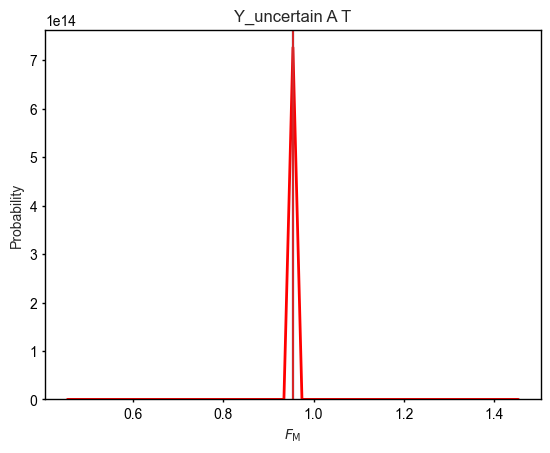

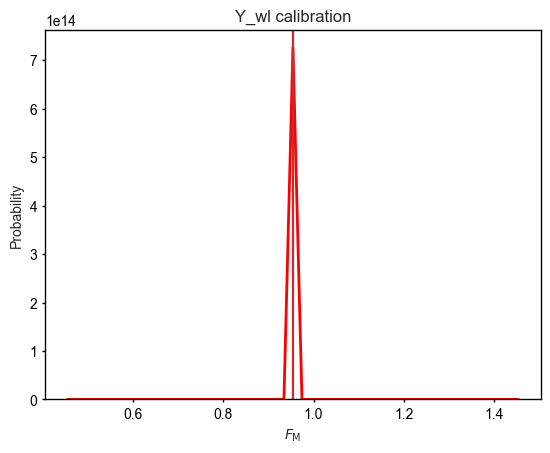

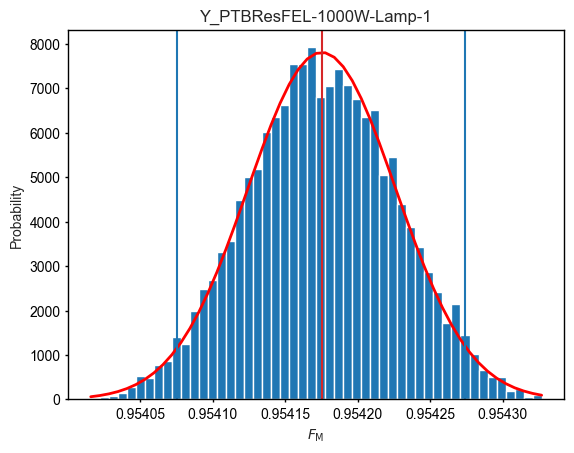

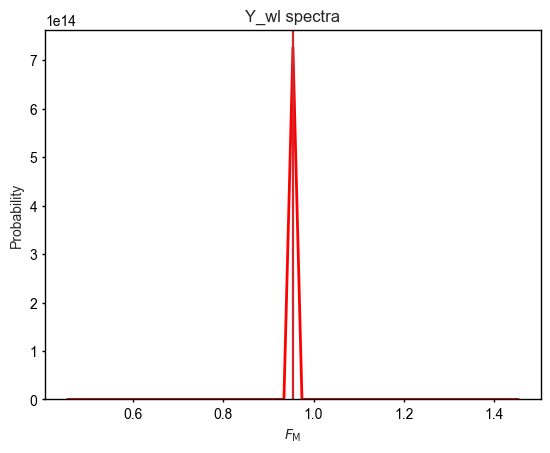

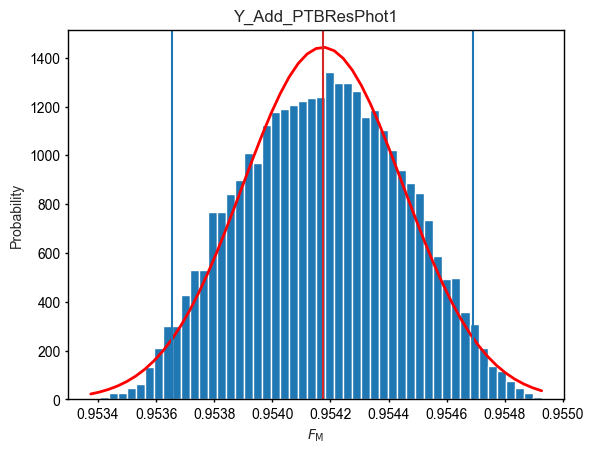

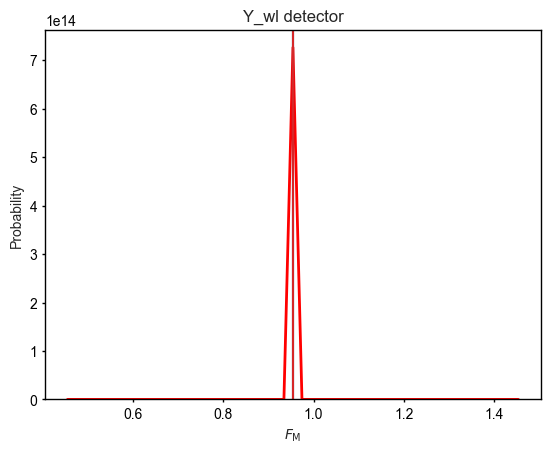

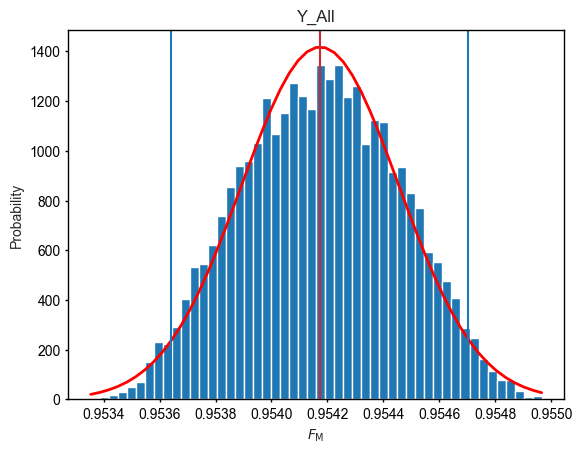

In [28]:
j_observation = 6
for i in range(len(mcResult)):
    var = mcResult[i]
    value, interval = plotHistScales( var[0].val[:,j_observation], add_distribution=True, title='Y_'+get_name(i), xLabel=get_item_name(j_observation))
    if i == 1:
        ref_mu = 2*value[1]


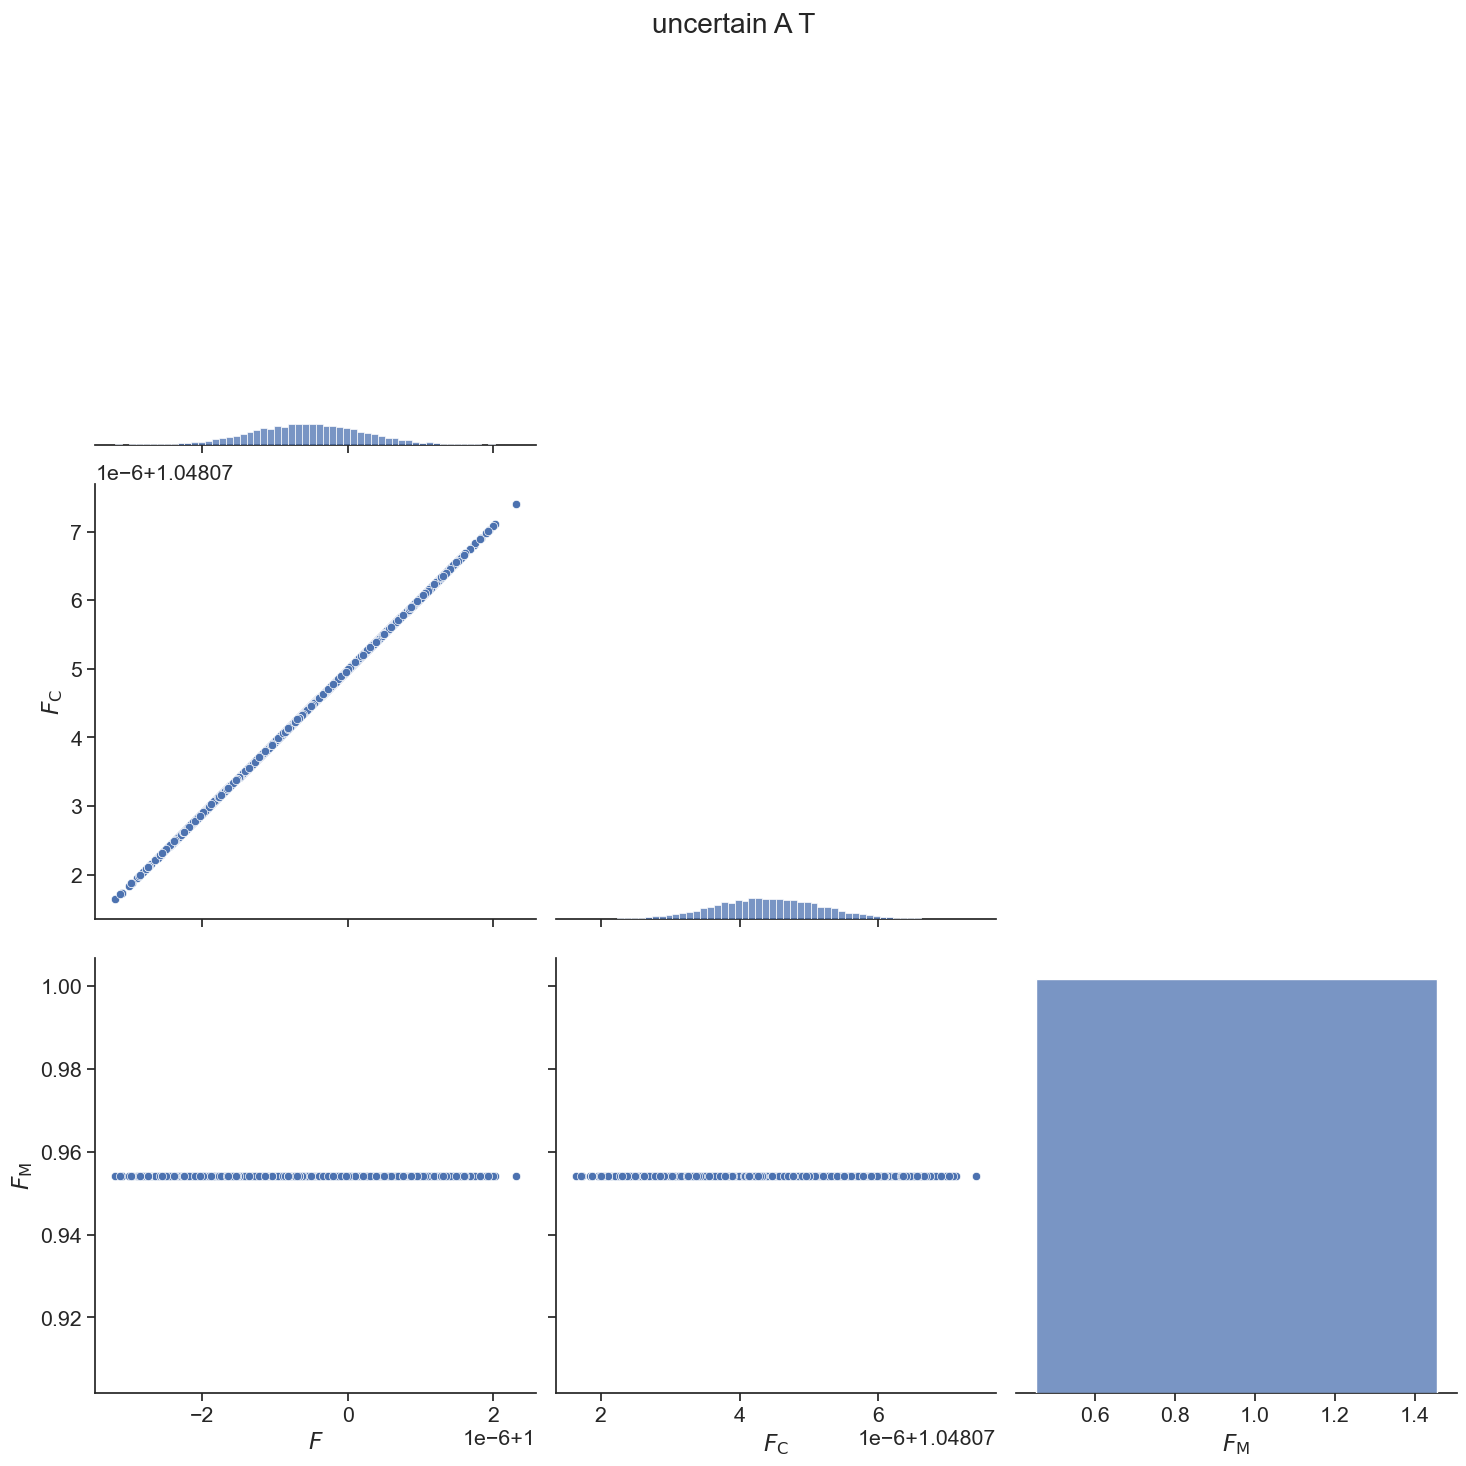

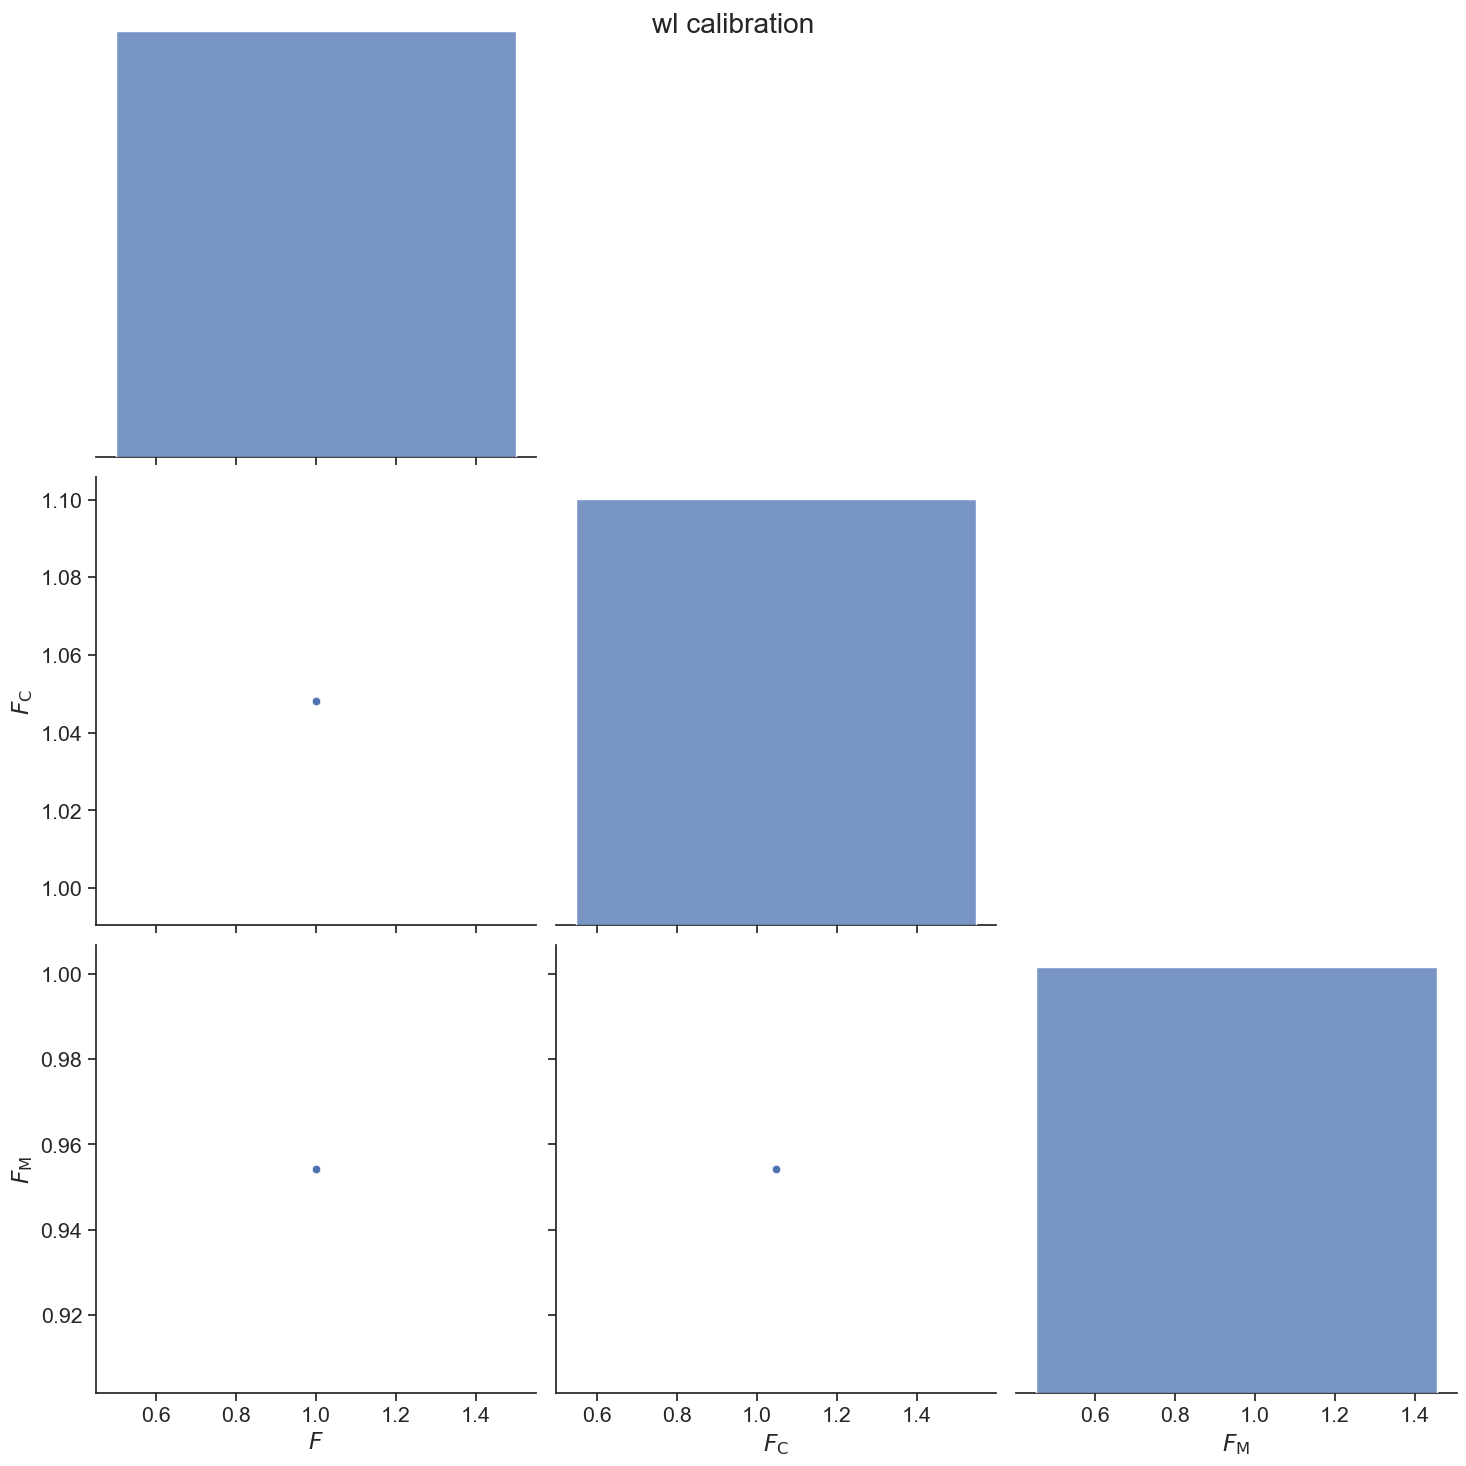

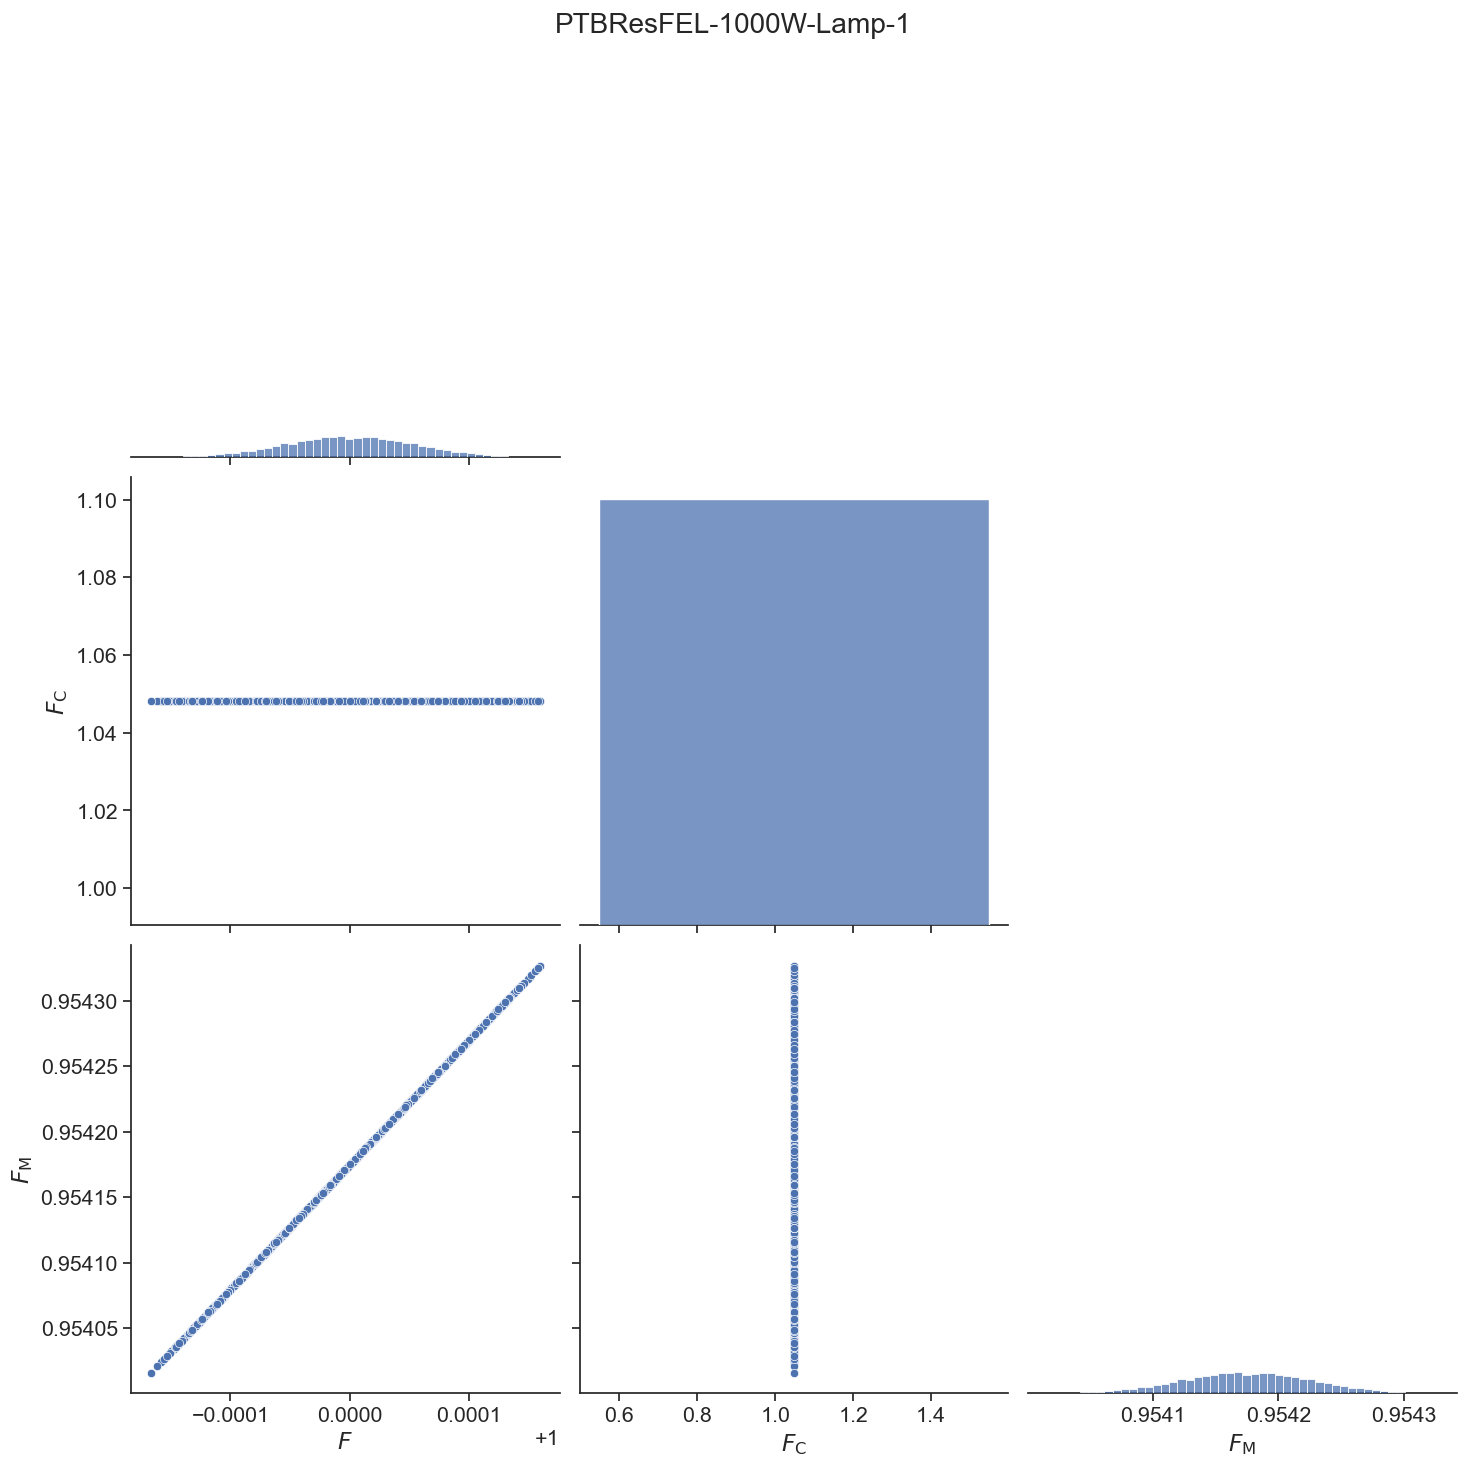

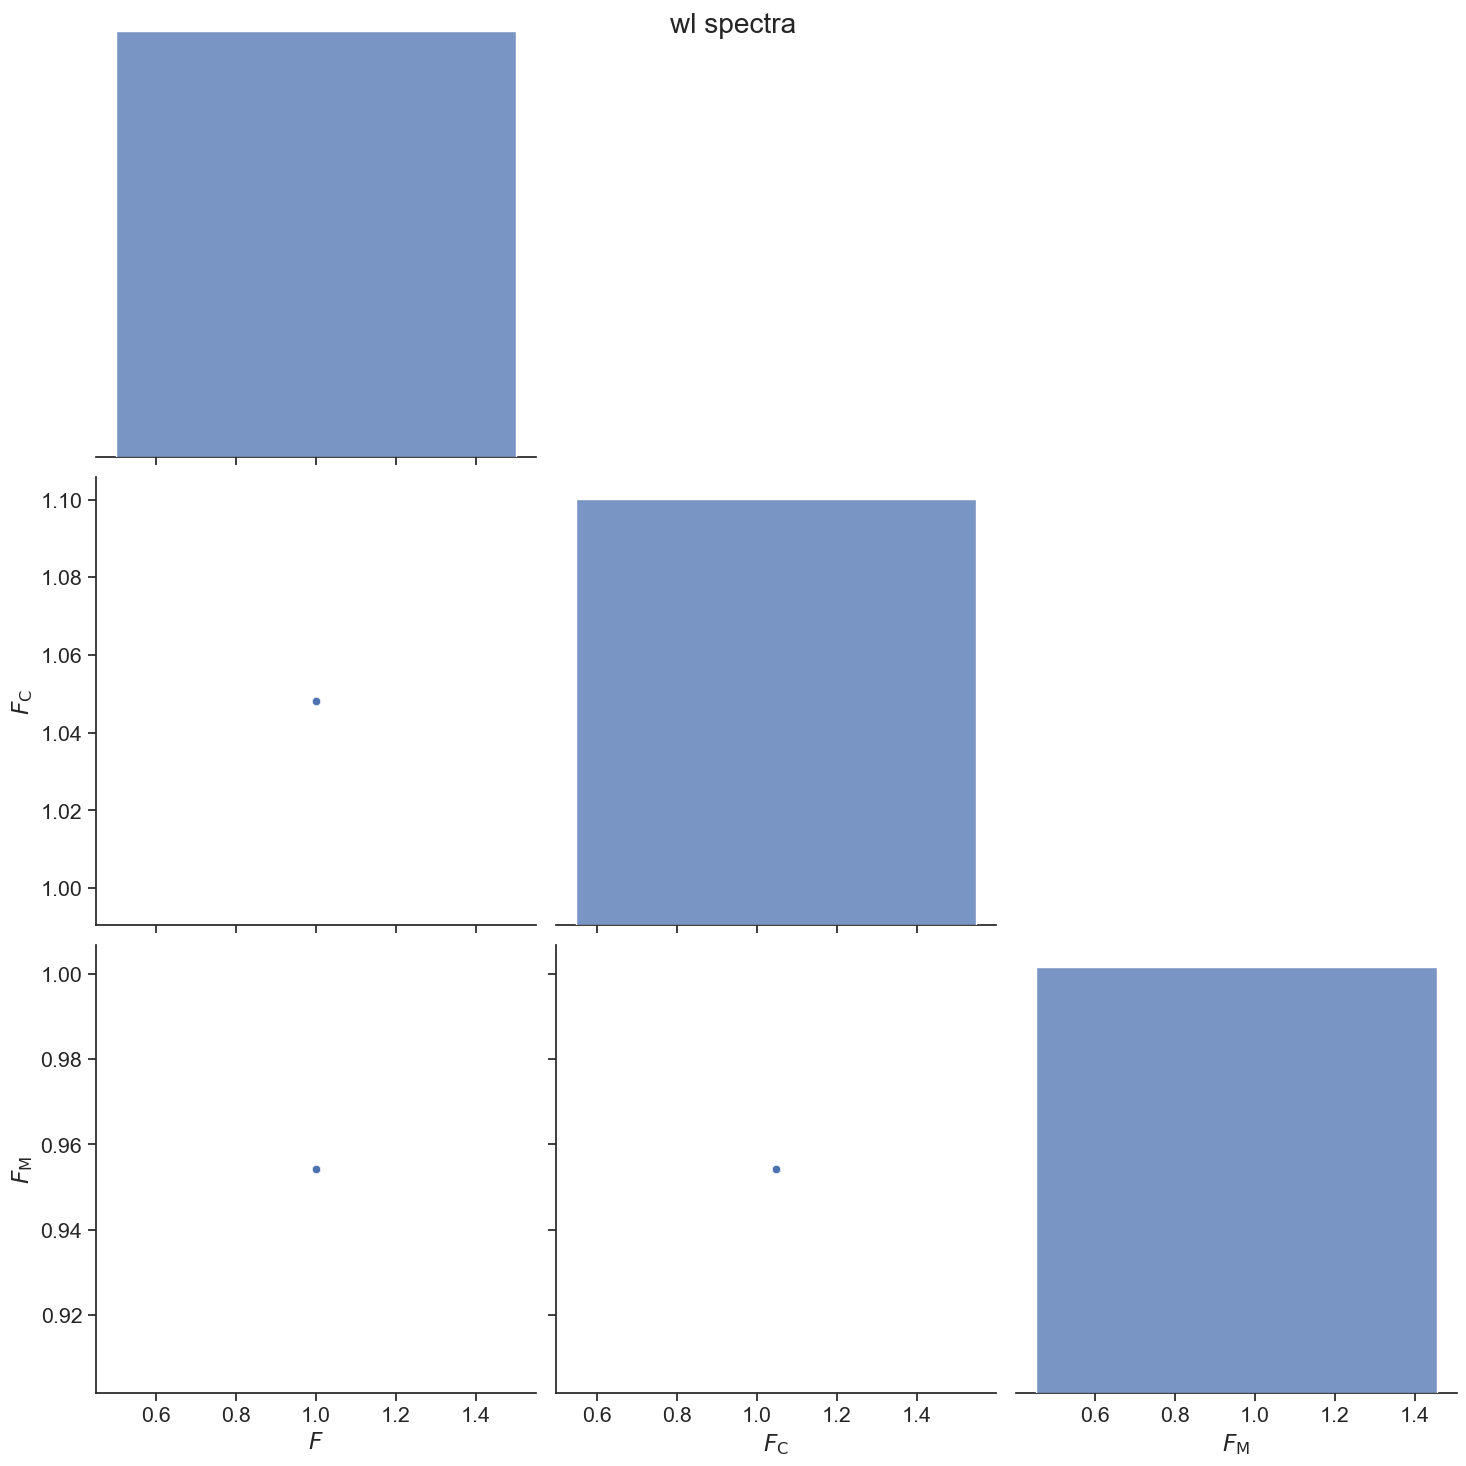

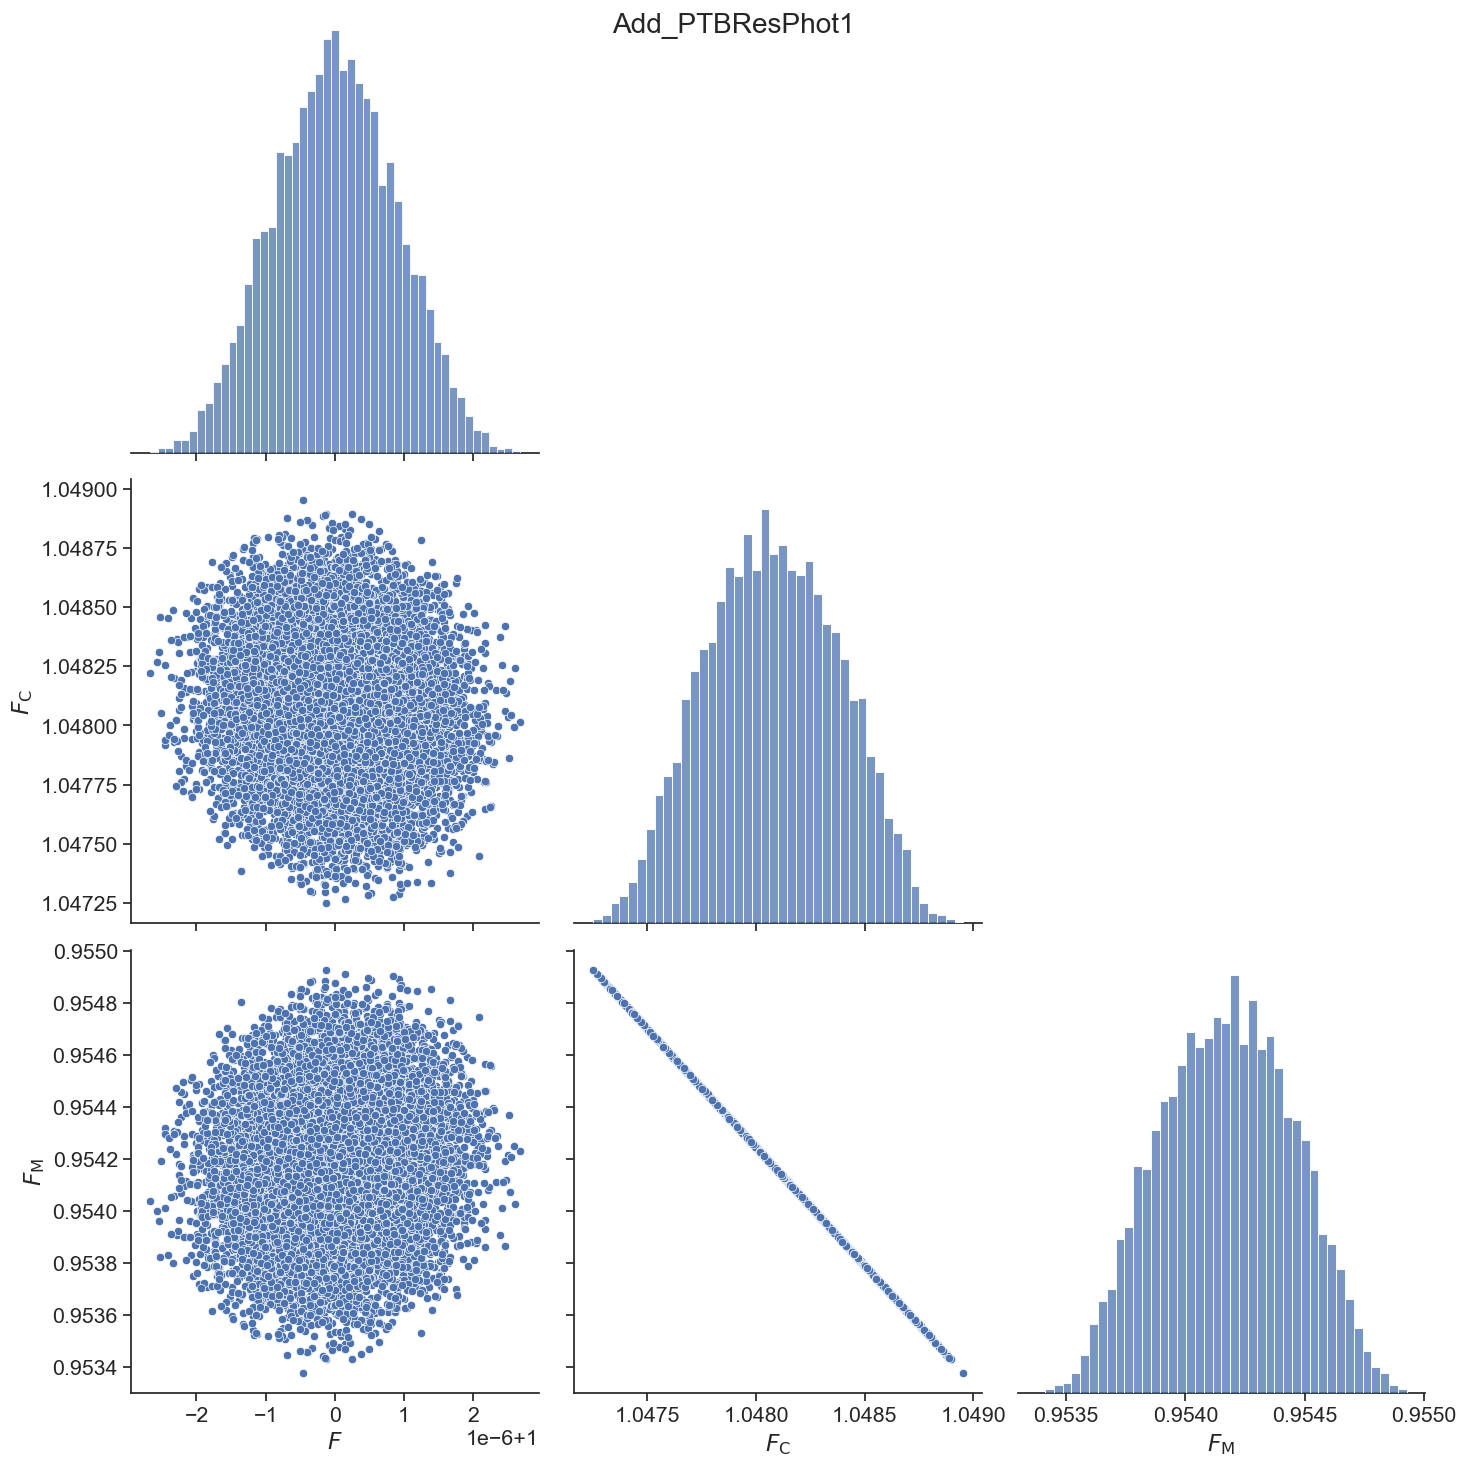

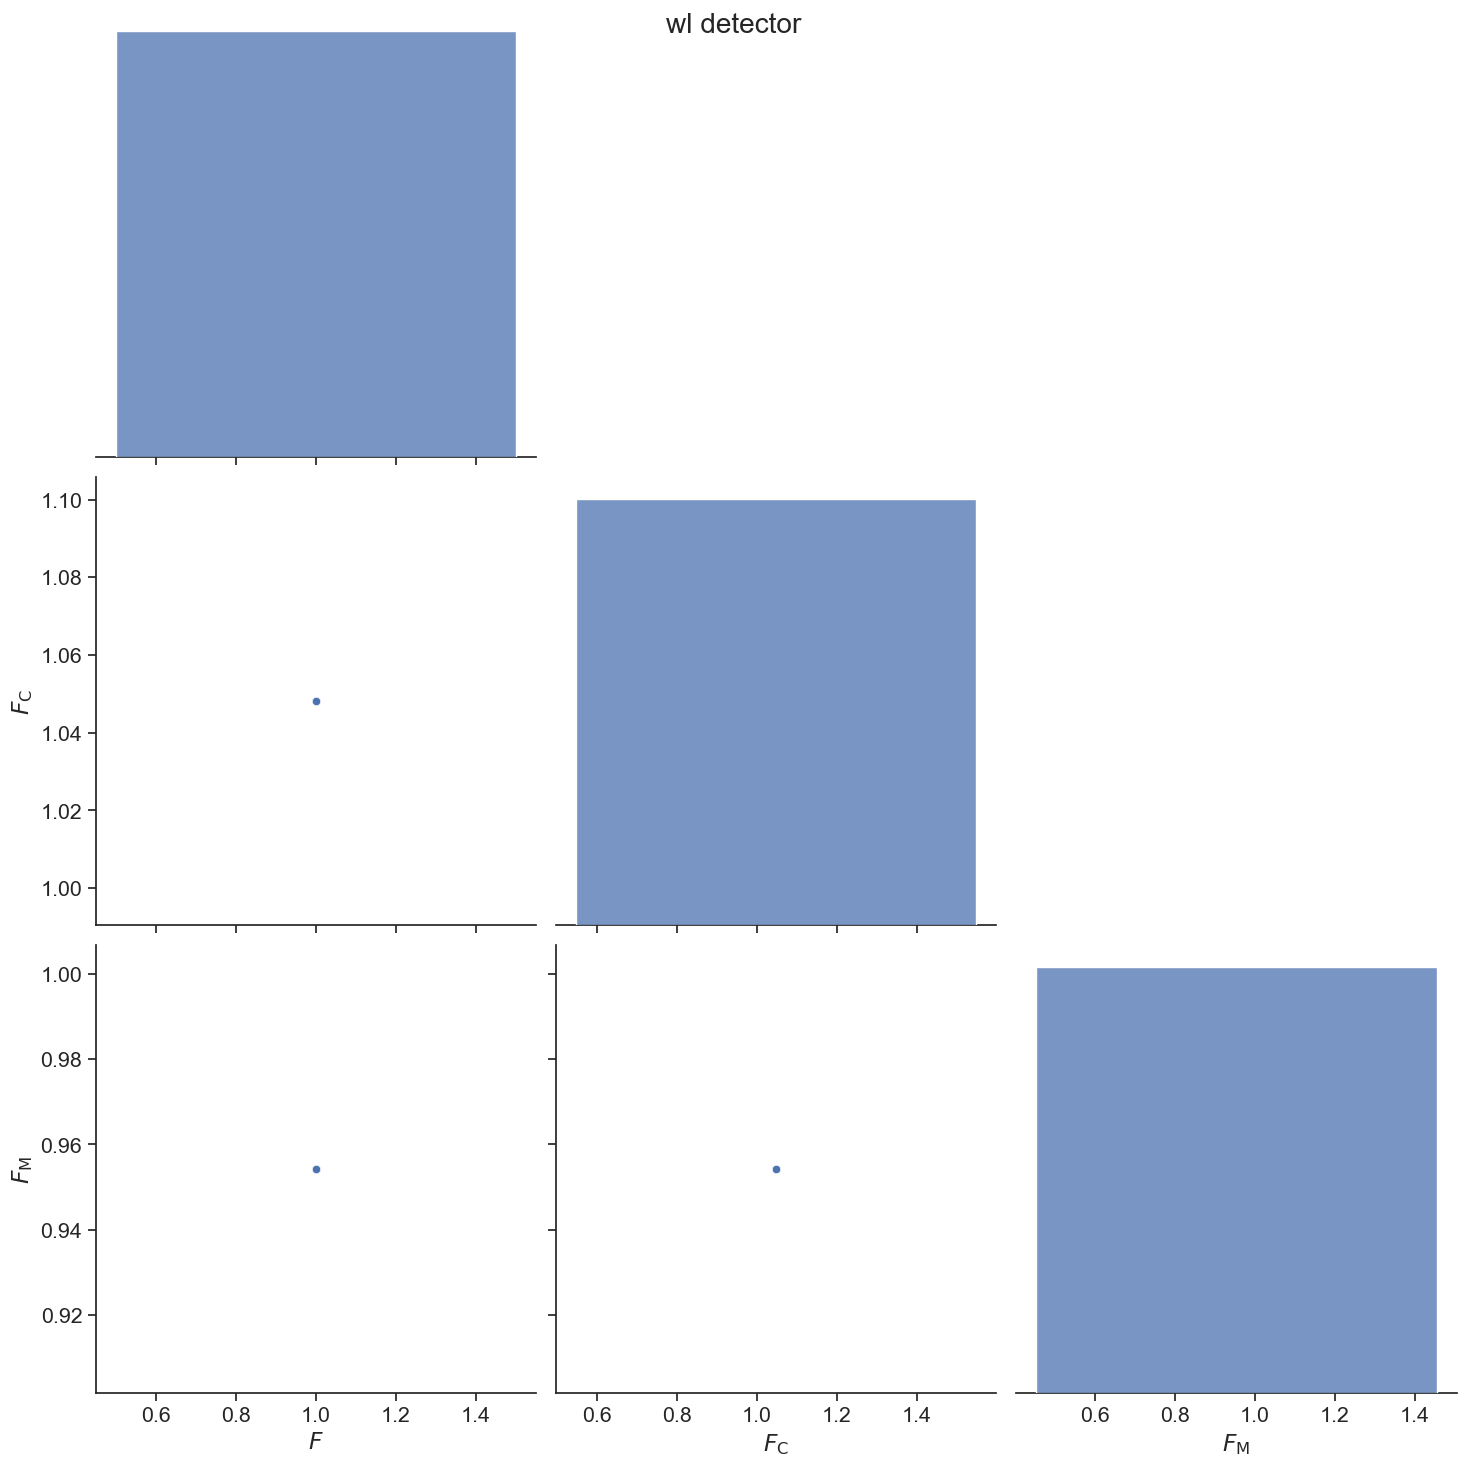

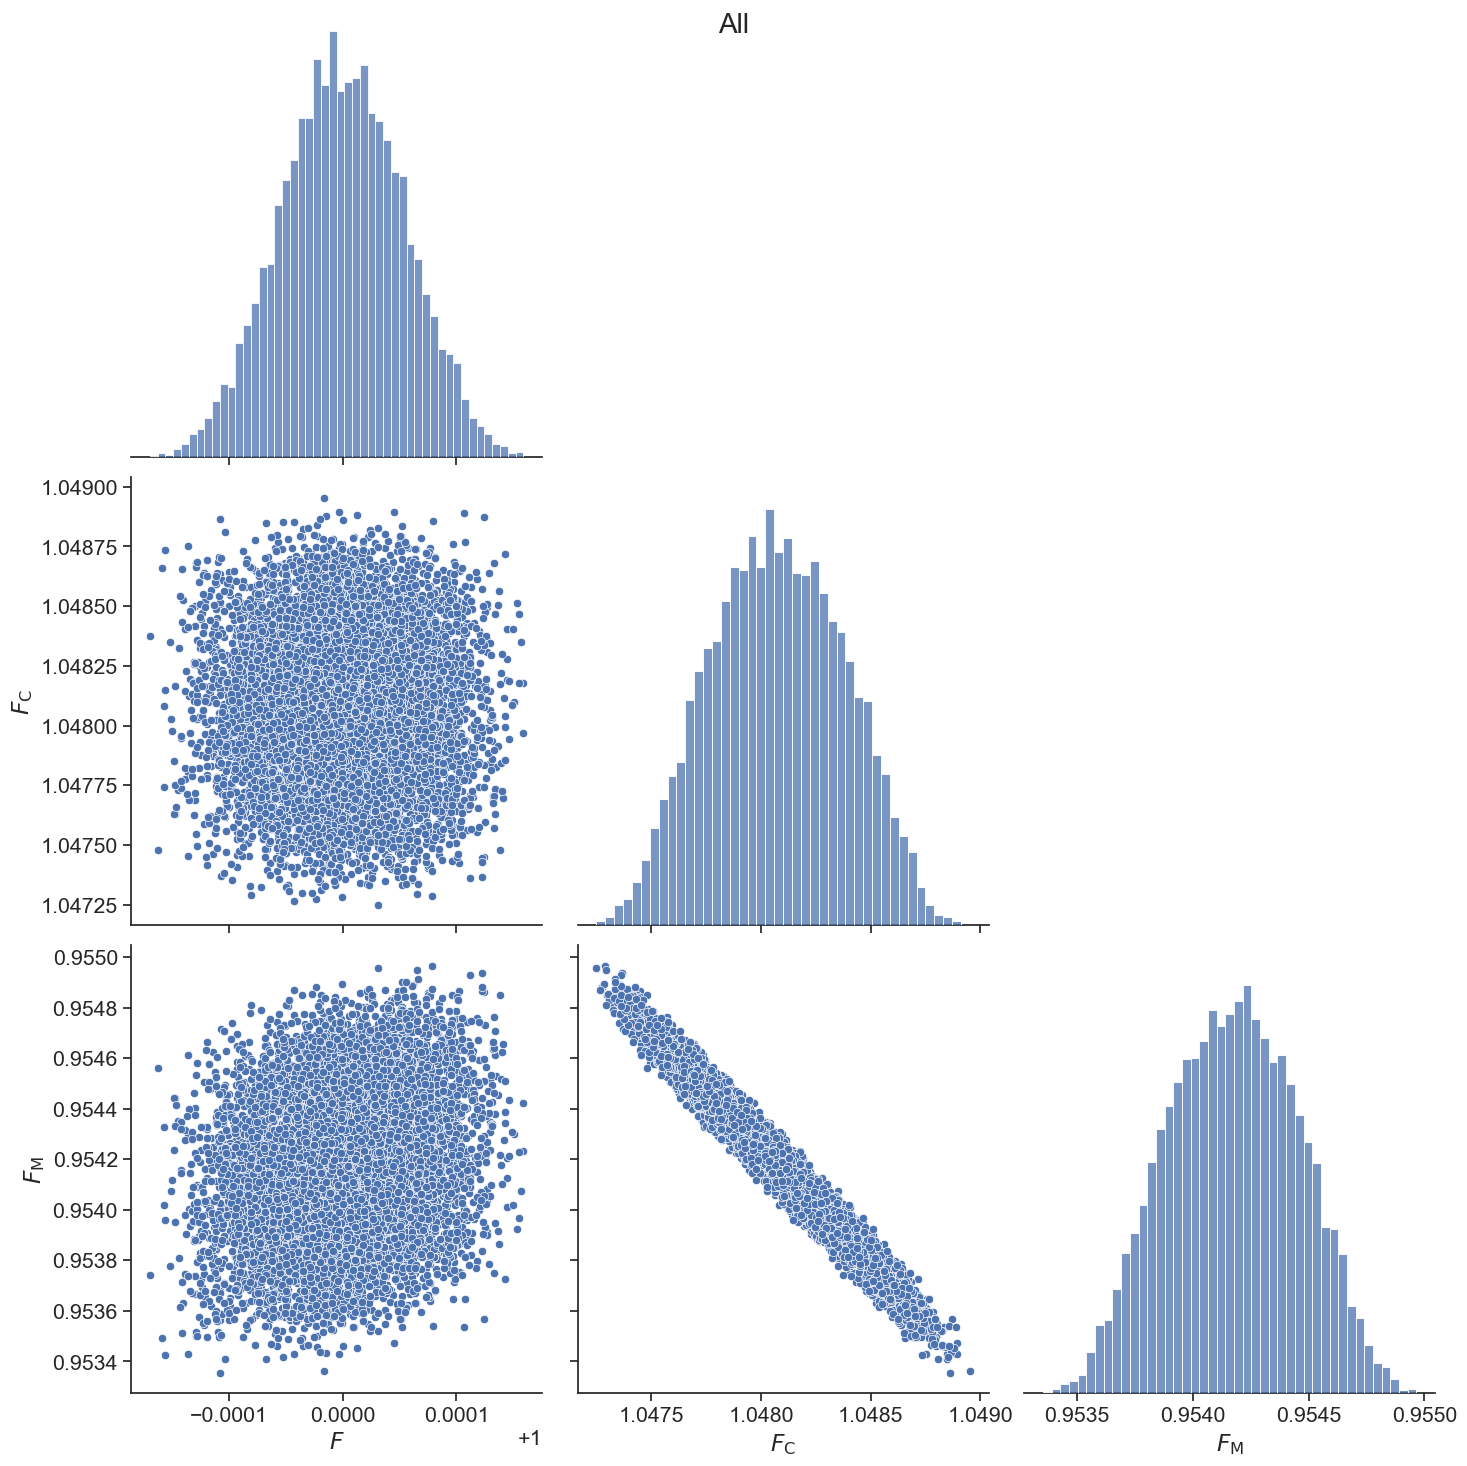

In [29]:
display_list = [0, 5, 6]
for i in range(len(mcResult)):
    var = mcResult[i][0].val.T
    seaborn_plot_result_gen(
        np.vstack([var[display_list[_j]] for _j in range(len(display_list))]),
        display=['n' for _ in range(len(display_list))], dim=len(display_list),
        column_str=[get_item_name(display_list[_i], use_math=False) for _i in range(len(display_list))], title=get_name(i), fontsize=label_font_size)
    save_fig(out_dir, 'FullCorr' + str(i))

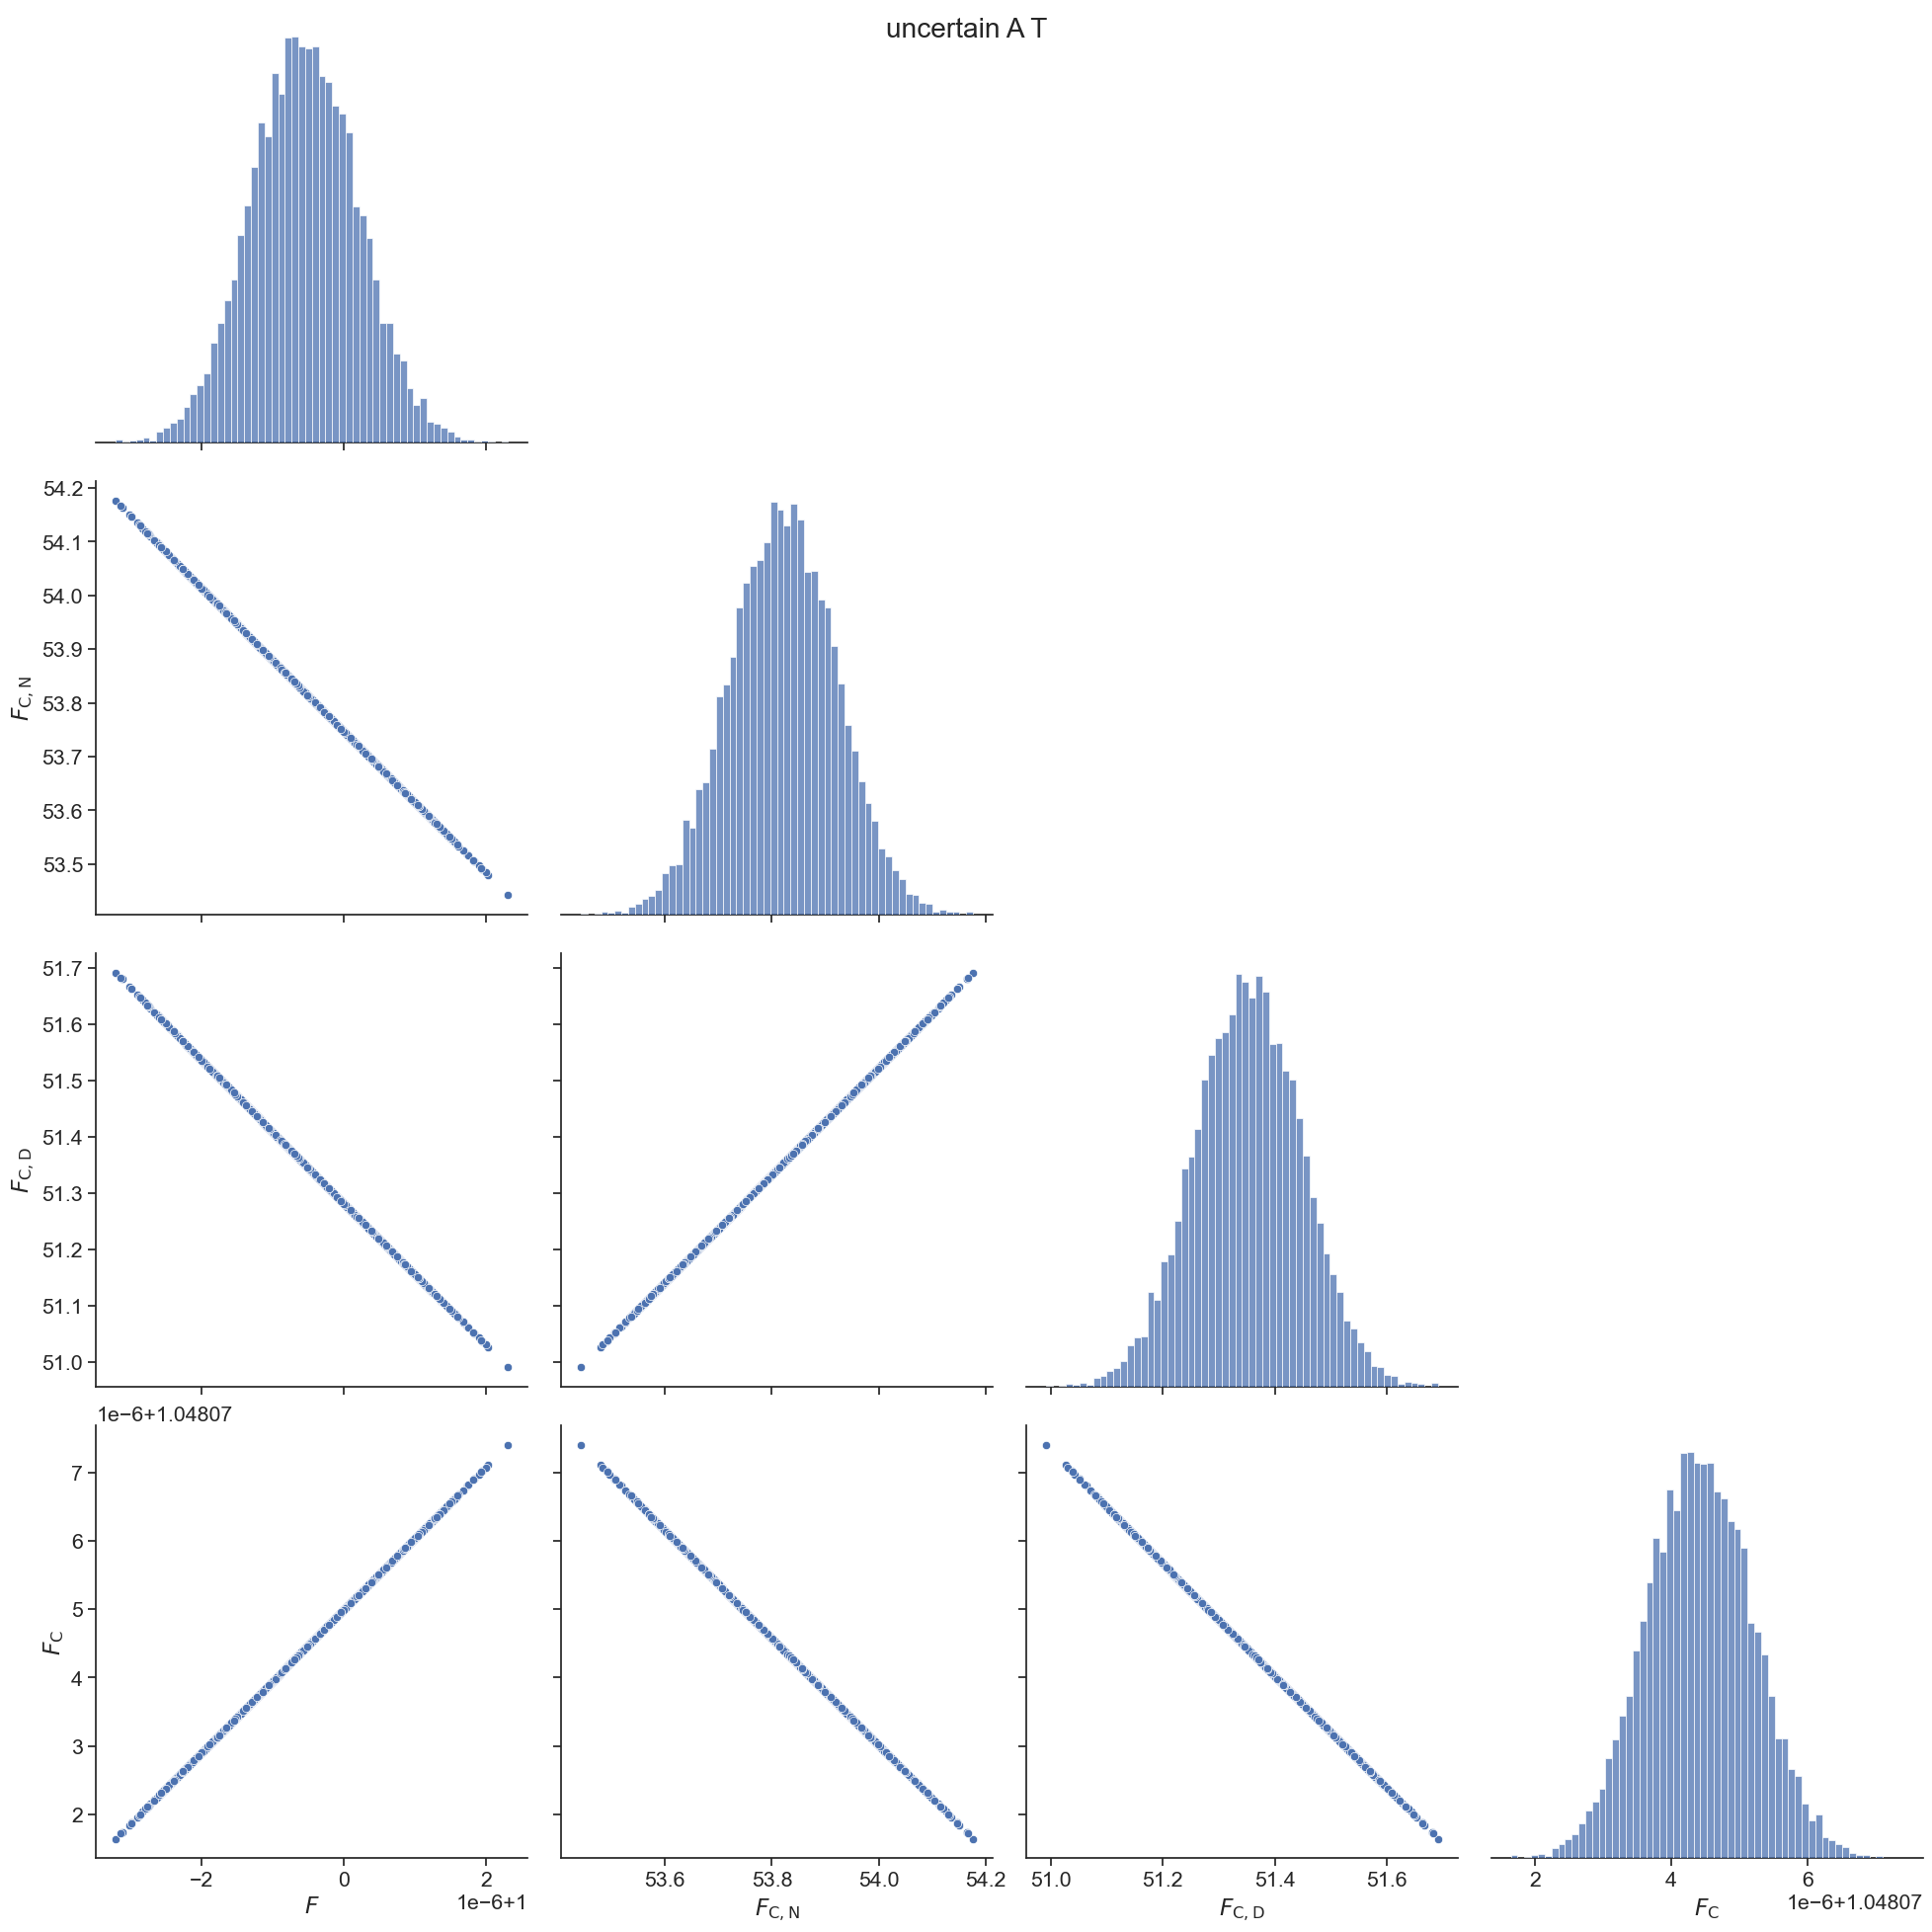

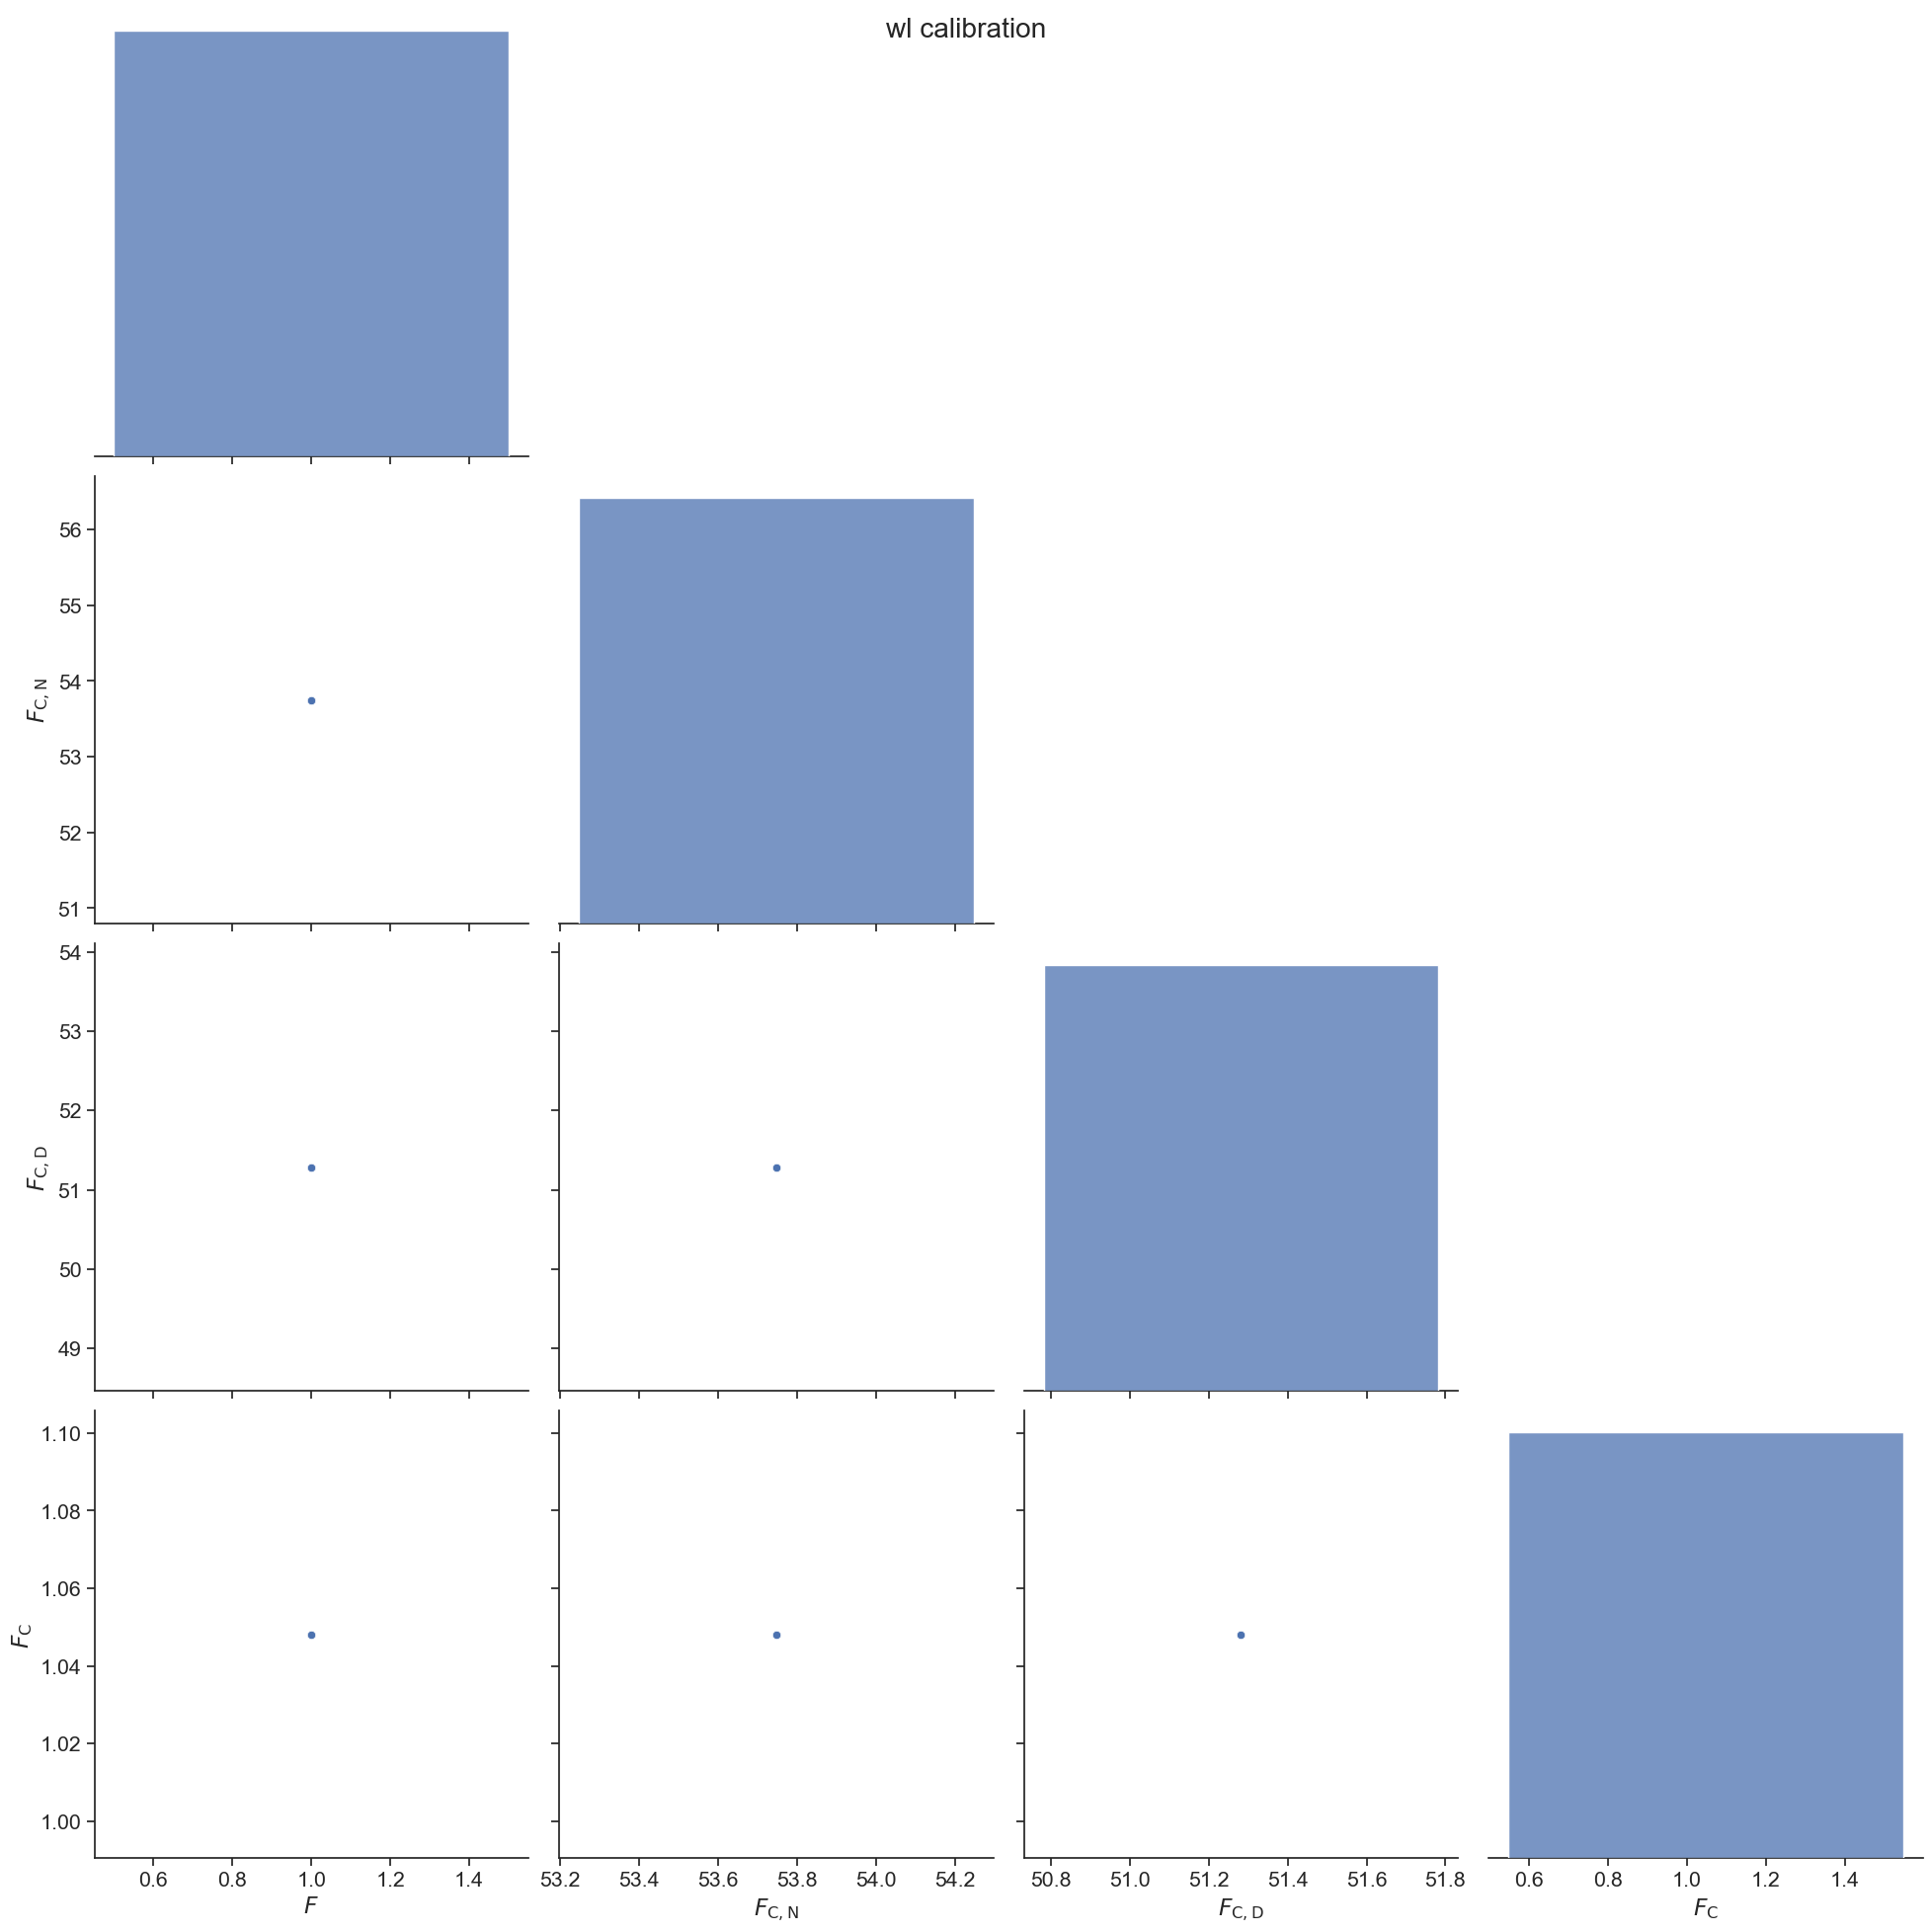

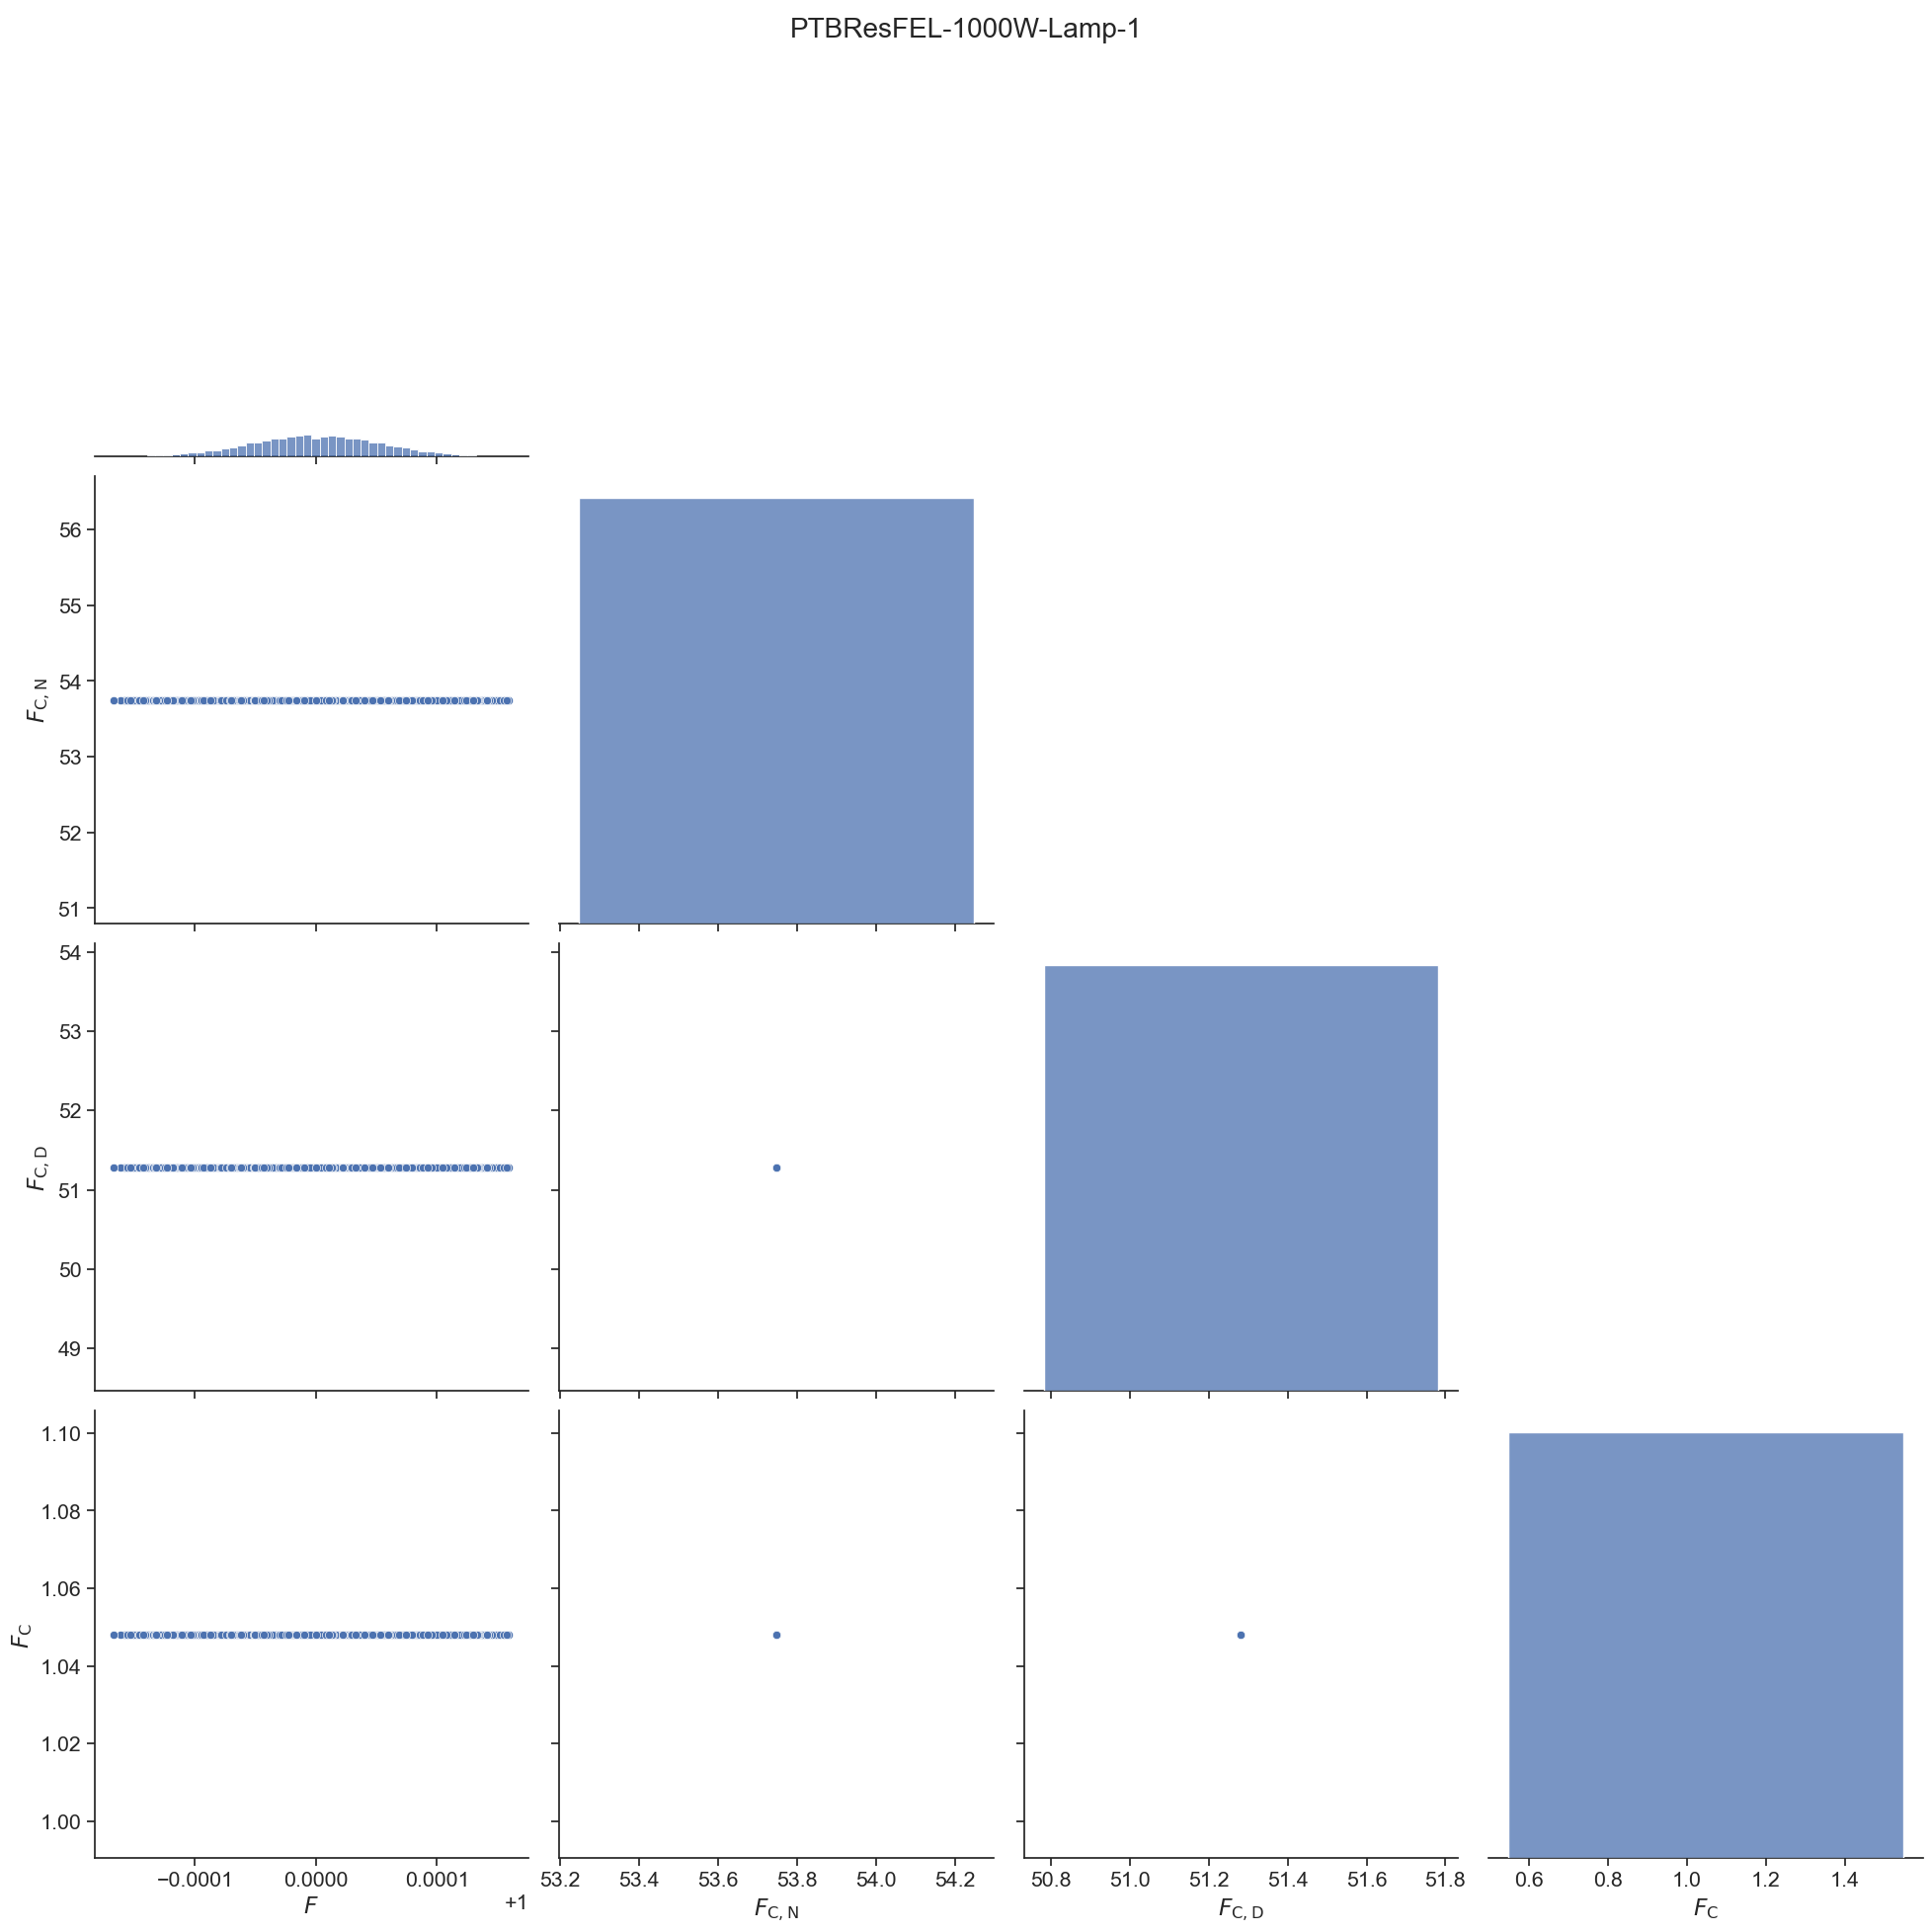

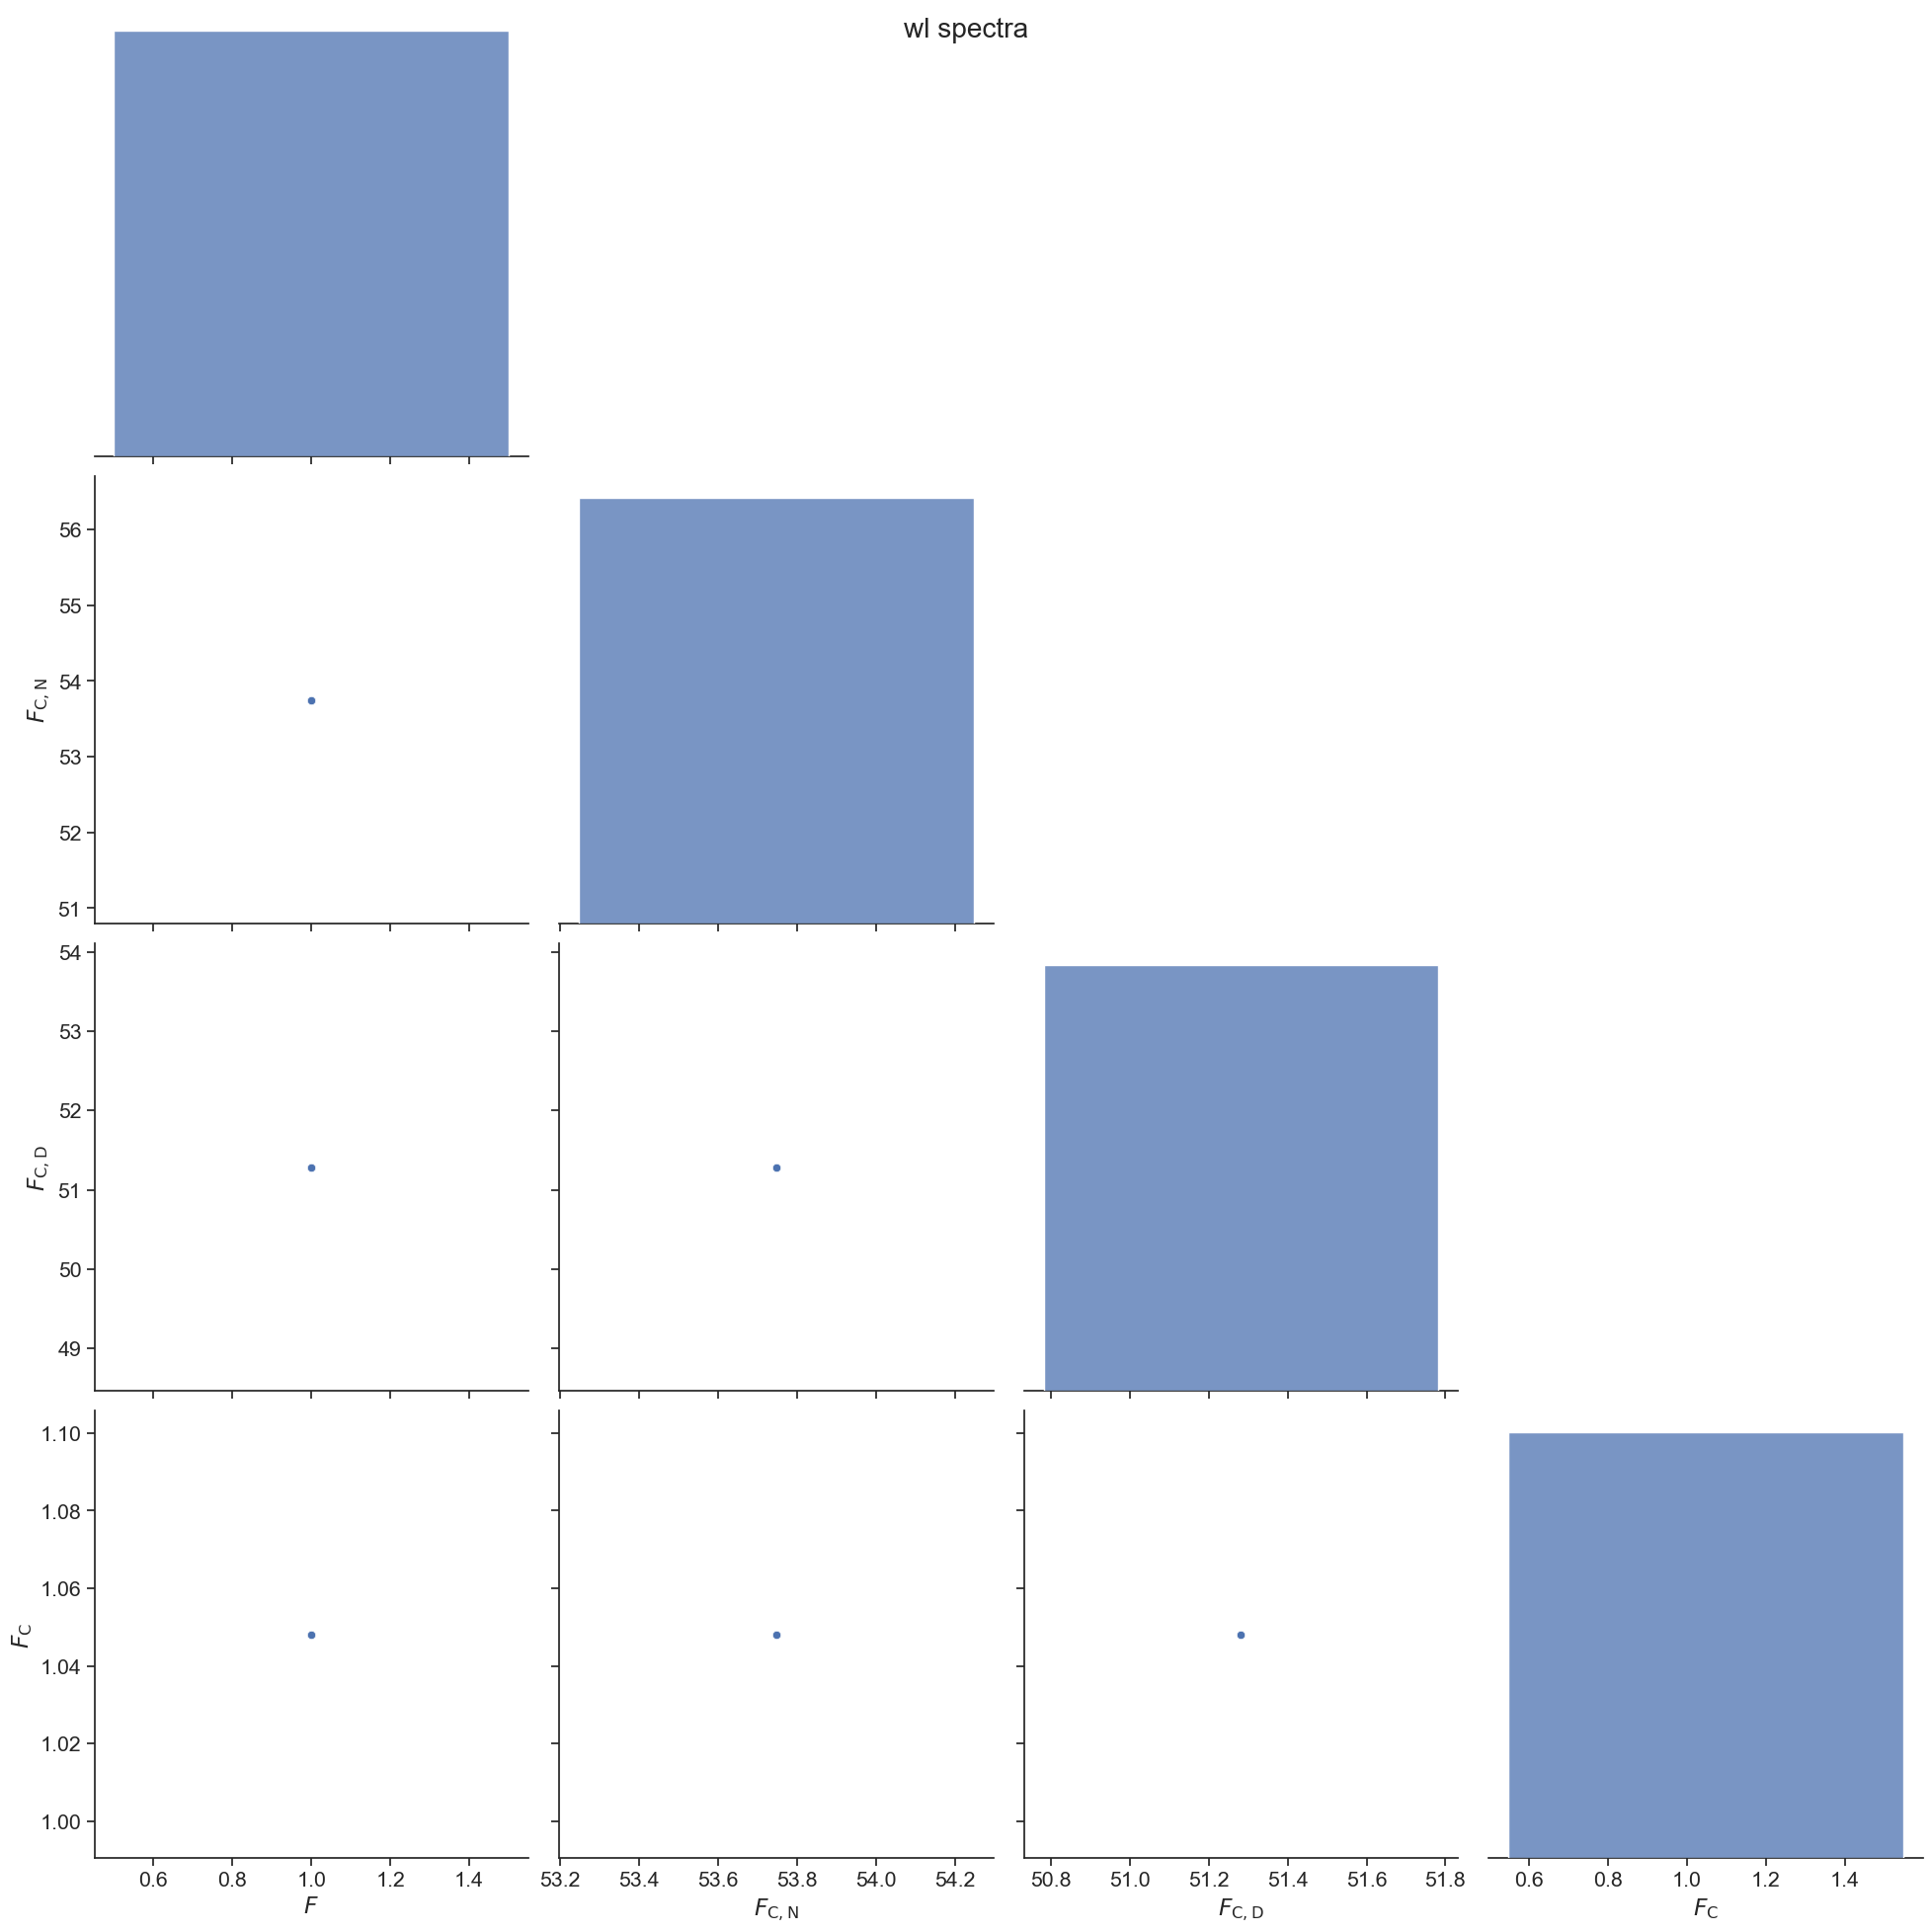

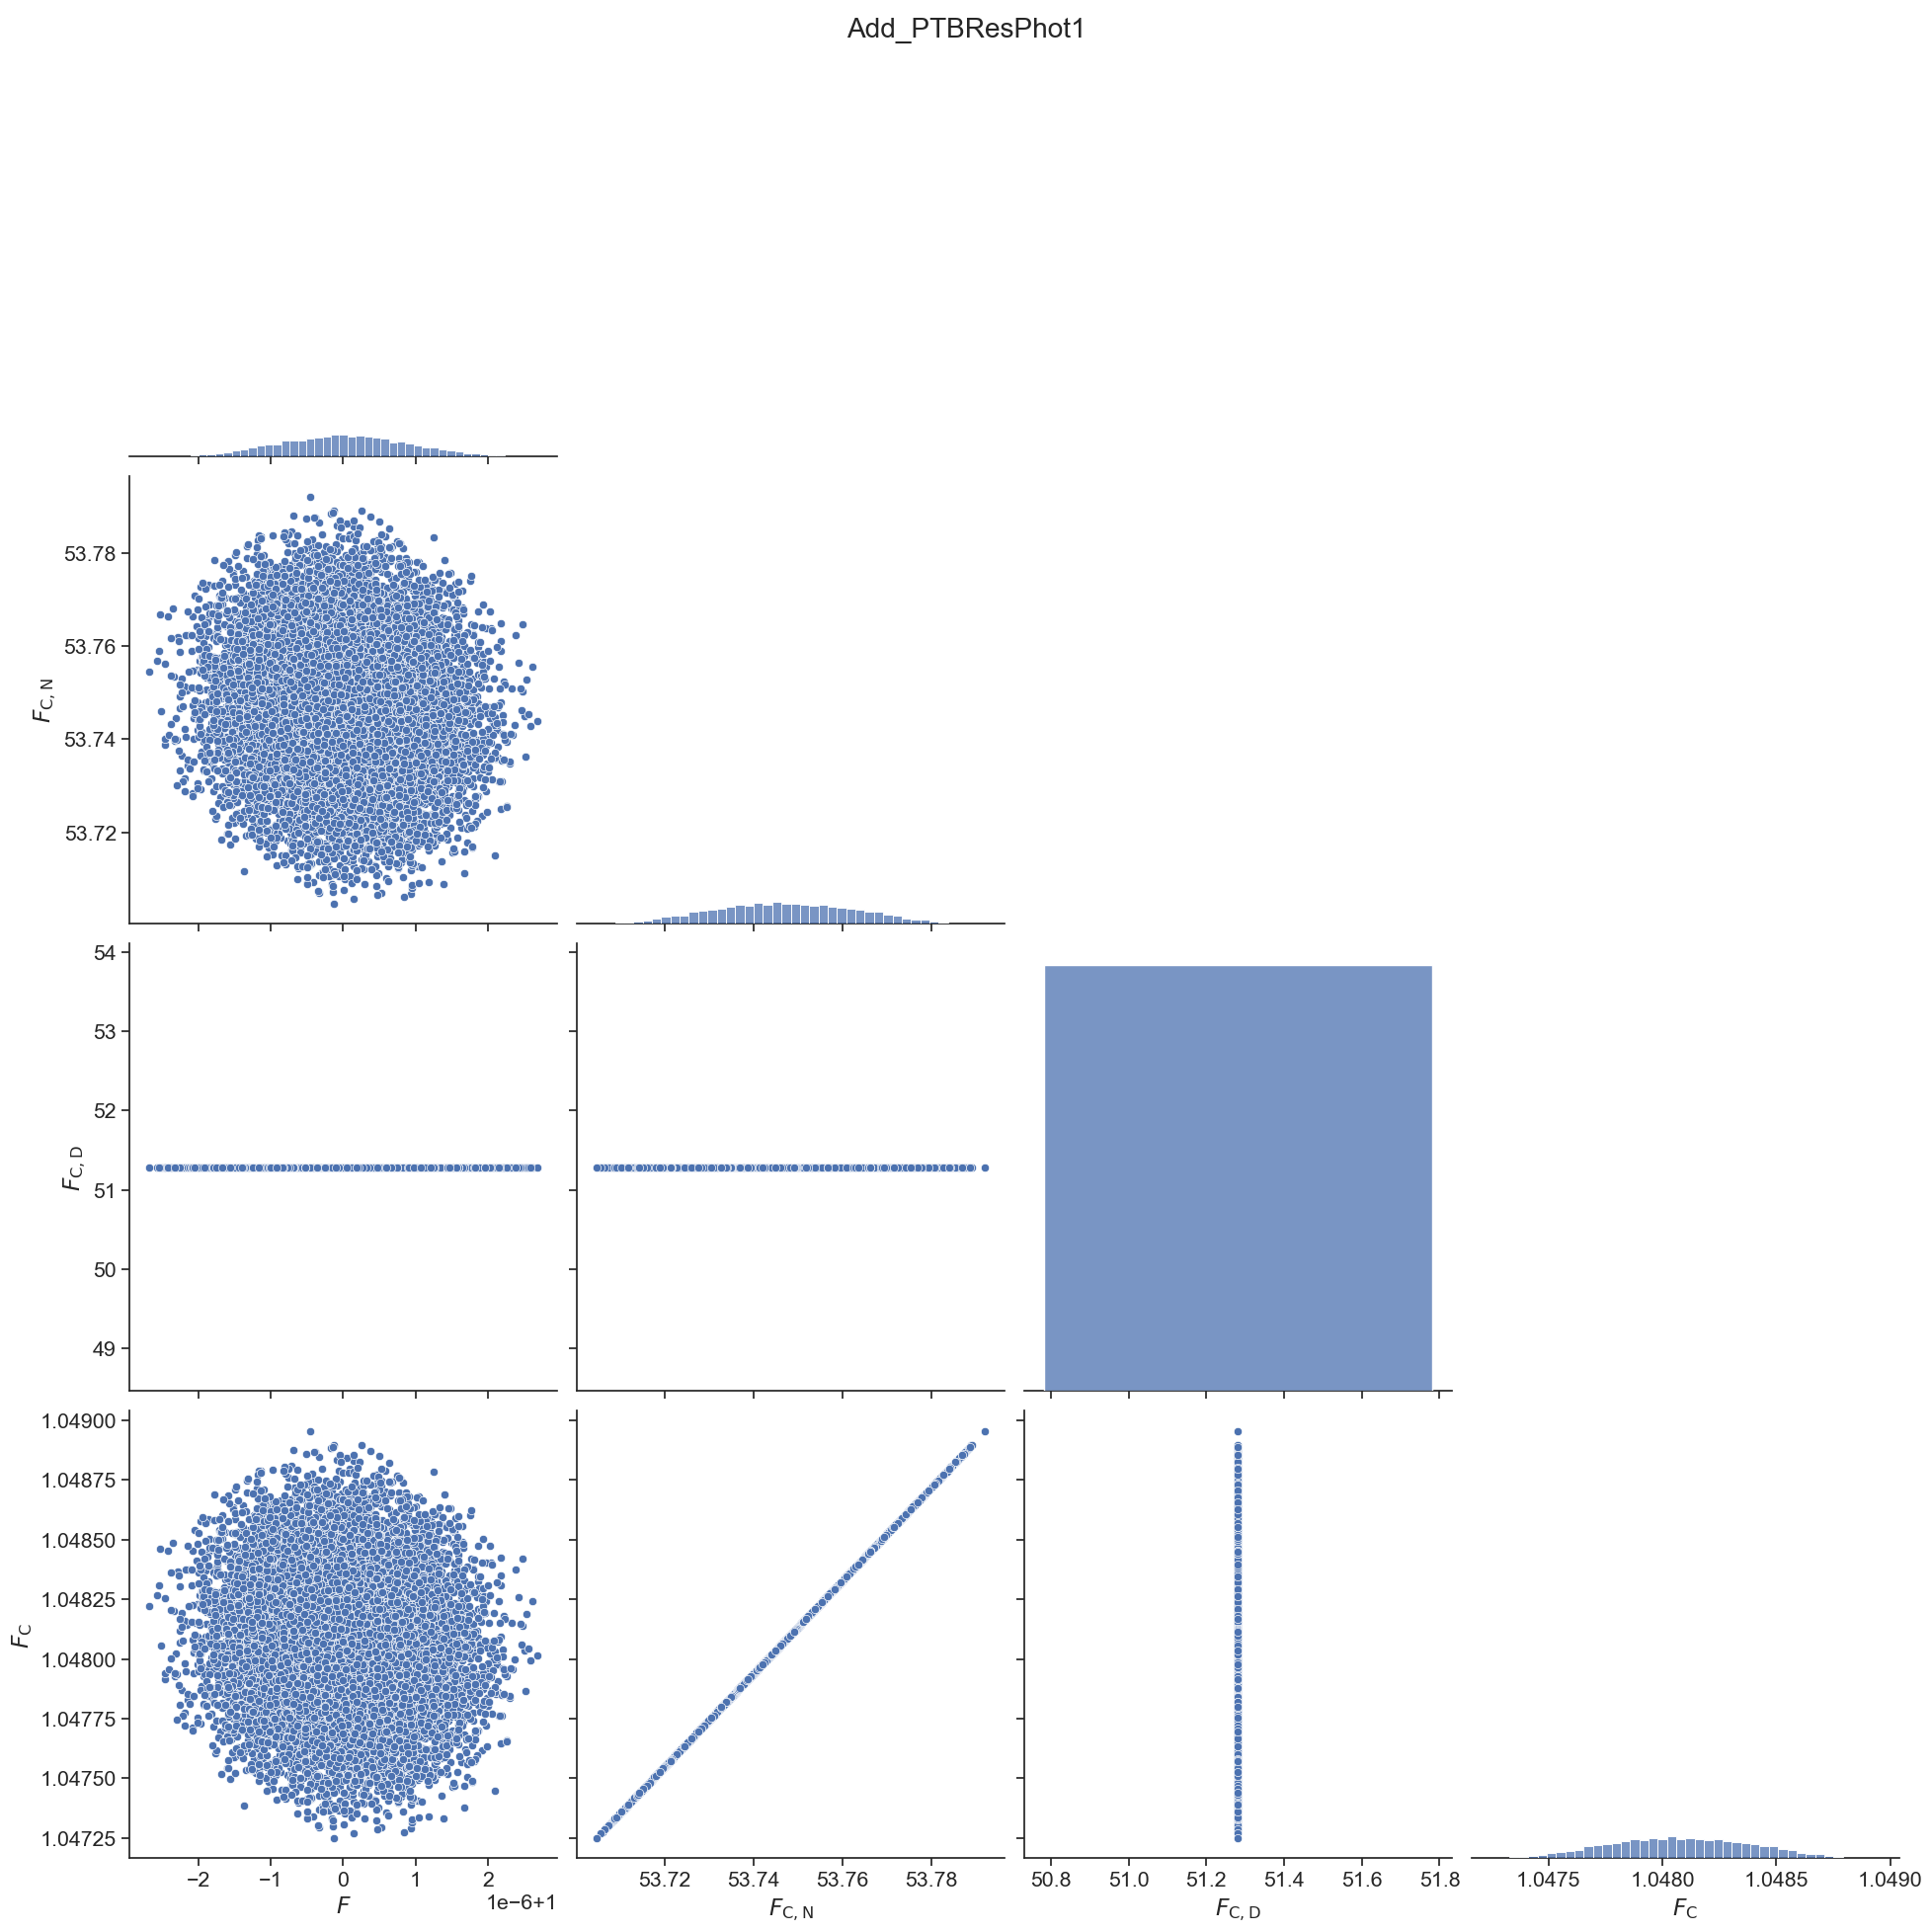

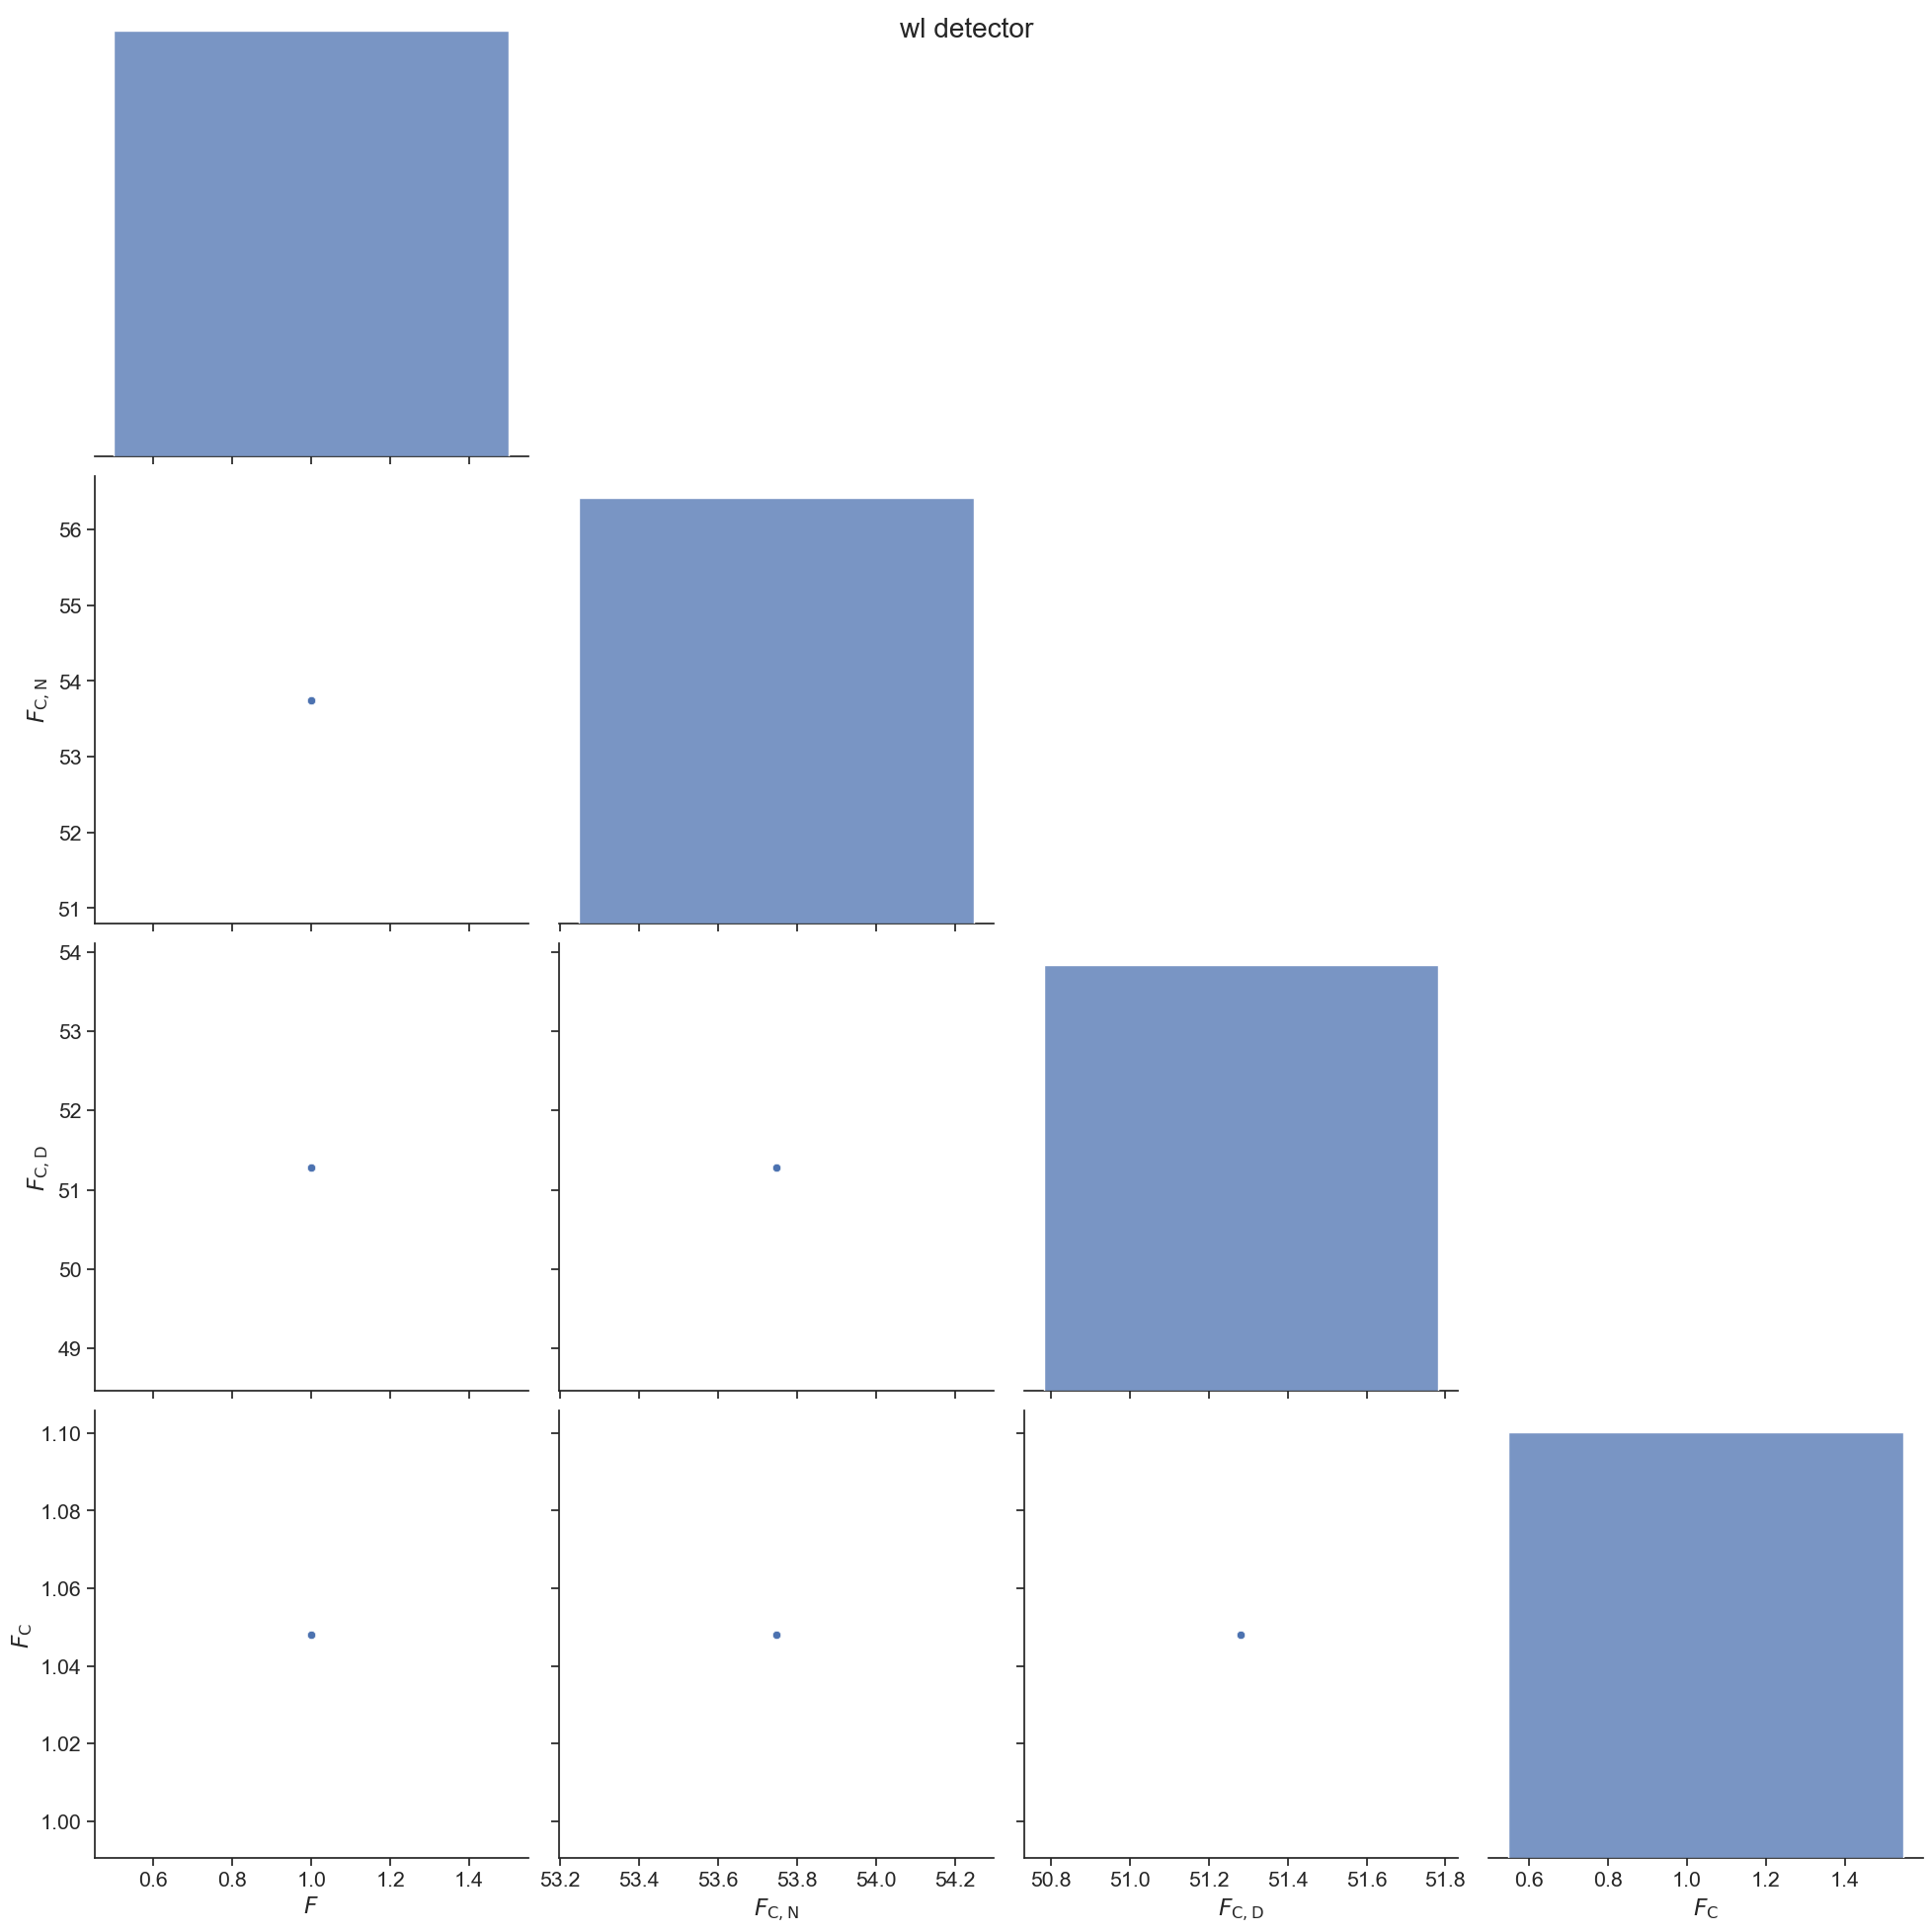

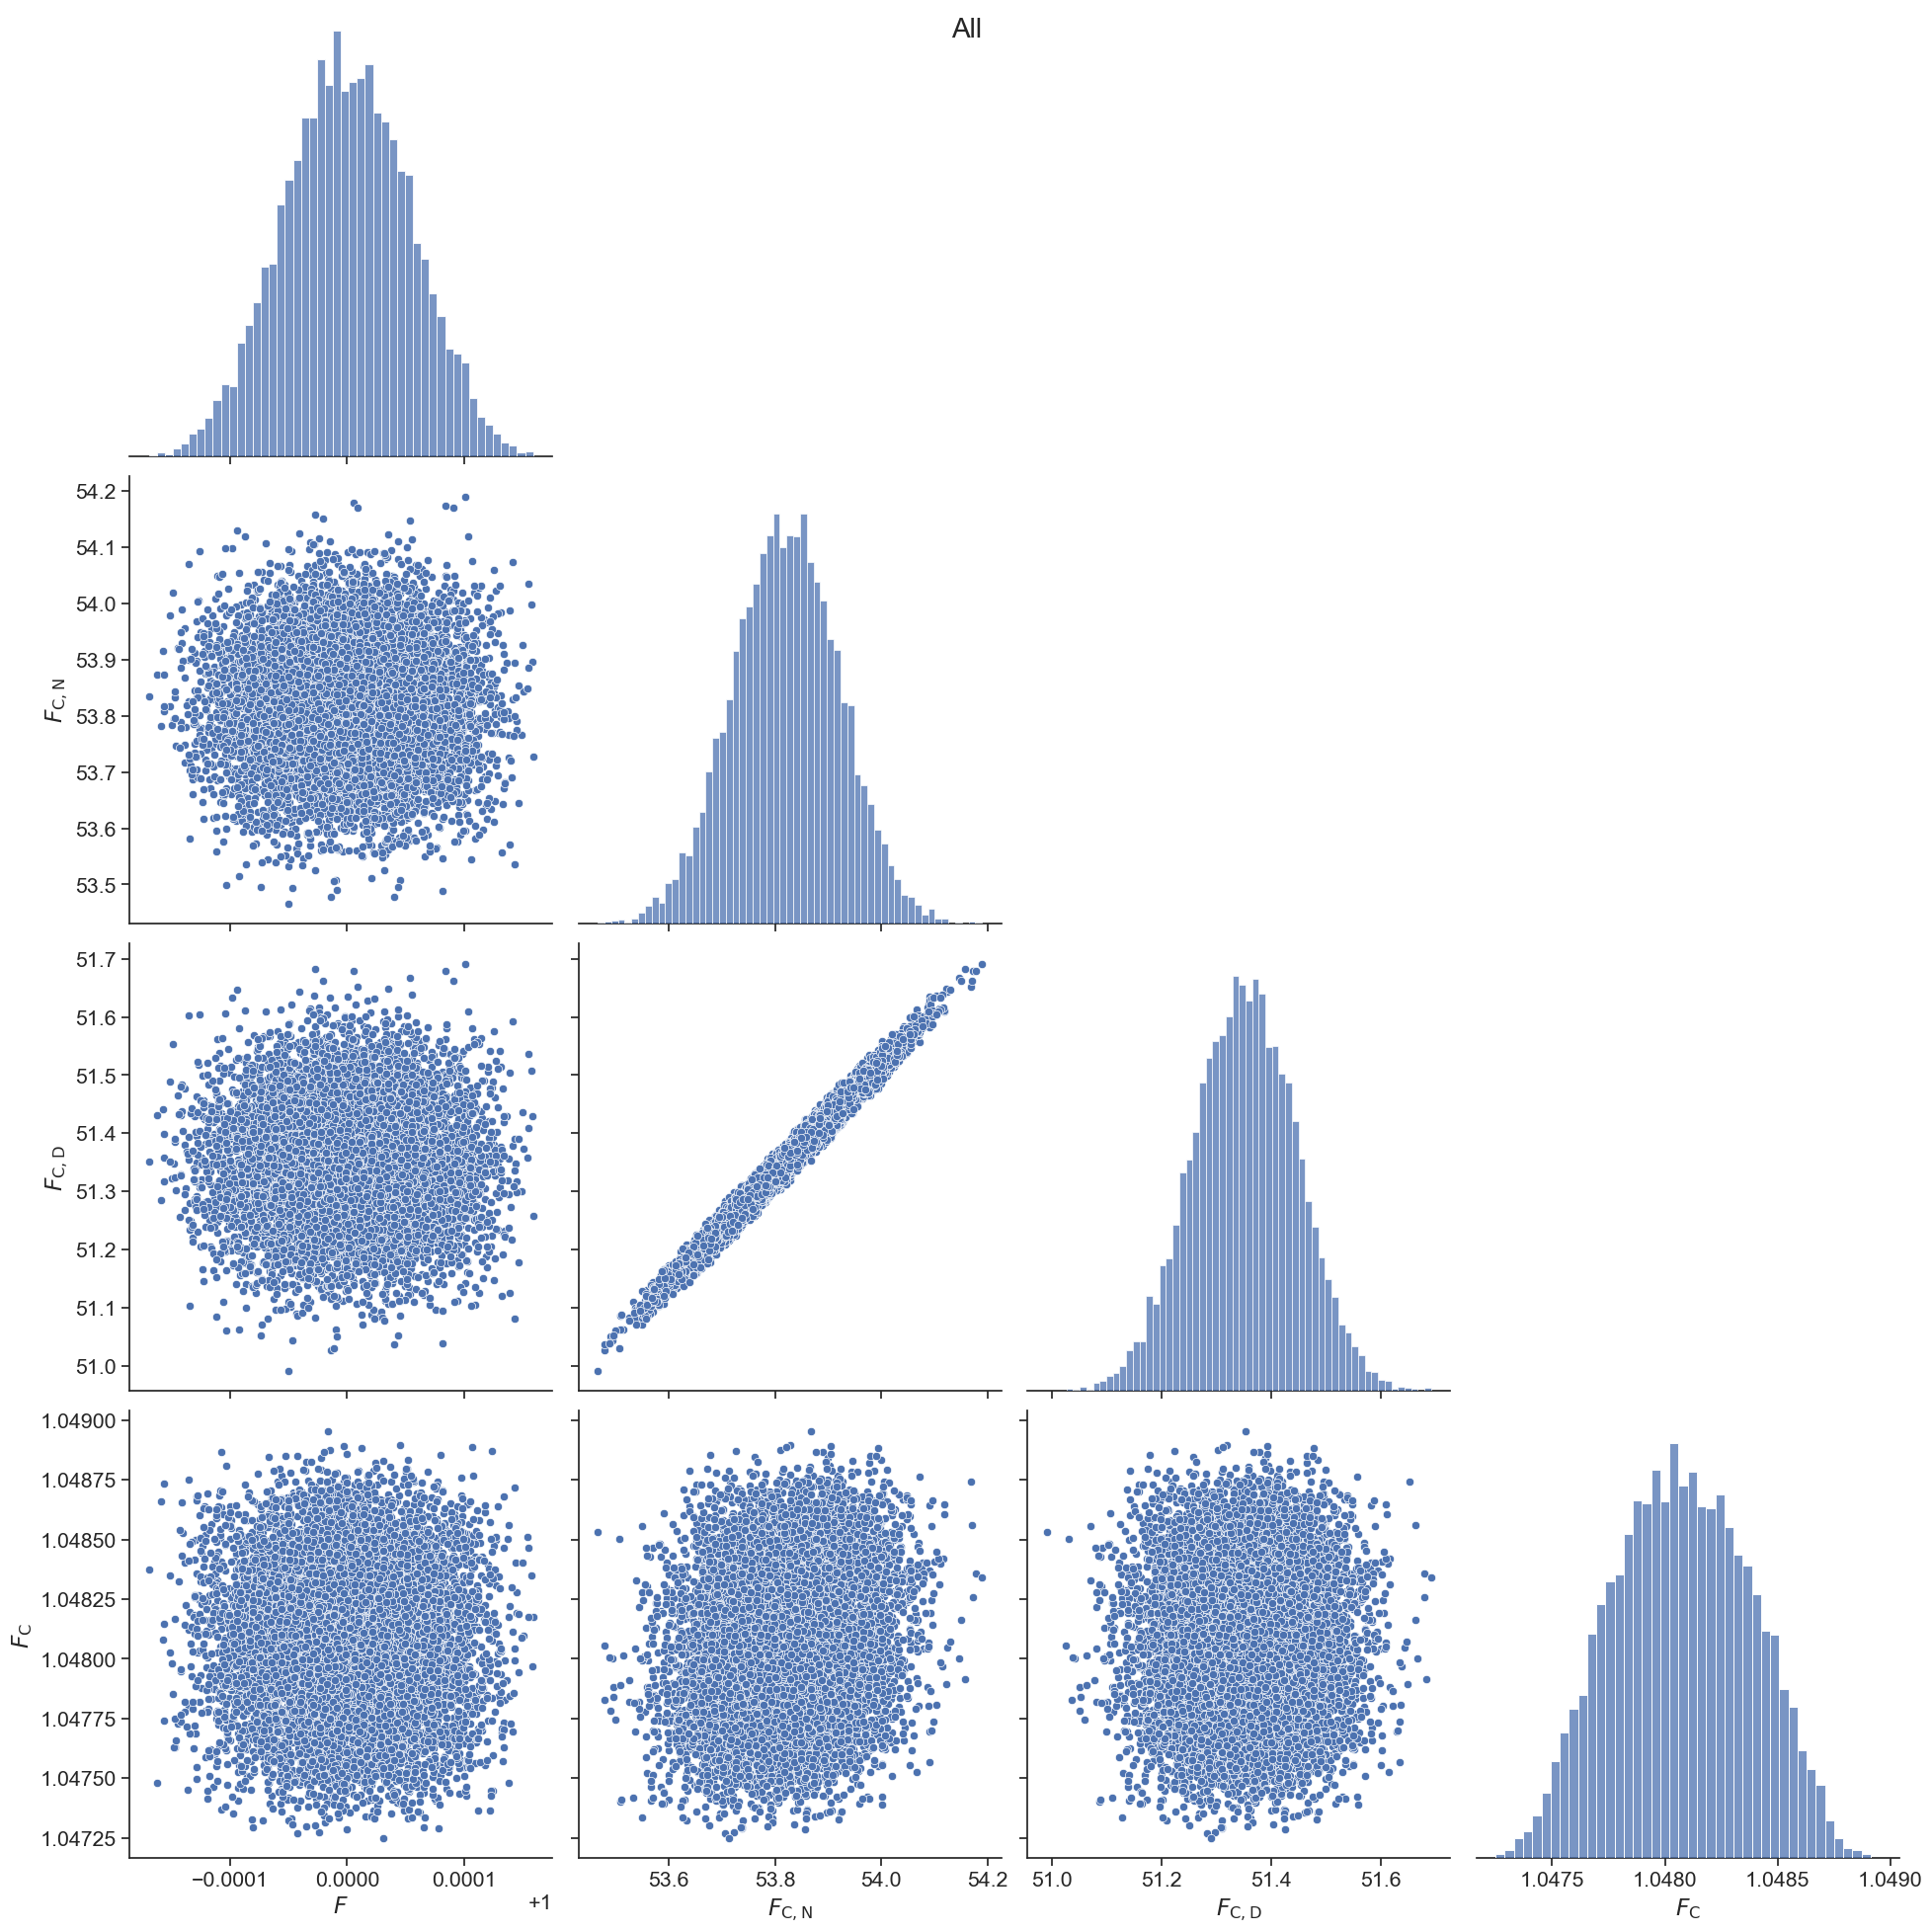

In [30]:
display_list = [0, 1,2, 5]
for i in range(len(mcResult)):
    var = mcResult[i][0].val.T
    seaborn_plot_result_gen(
        np.vstack([var[display_list[_j]] for _j in range(len(display_list))]),
        display=['n' for _ in range(len(display_list))], dim=len(display_list),
        column_str=[get_item_name(display_list[_i], use_math=False) for _i in range(len(display_list))], title=get_name(i), fontsize=label_font_size)
    save_fig(out_dir, 'FirstCorr' + str(i))

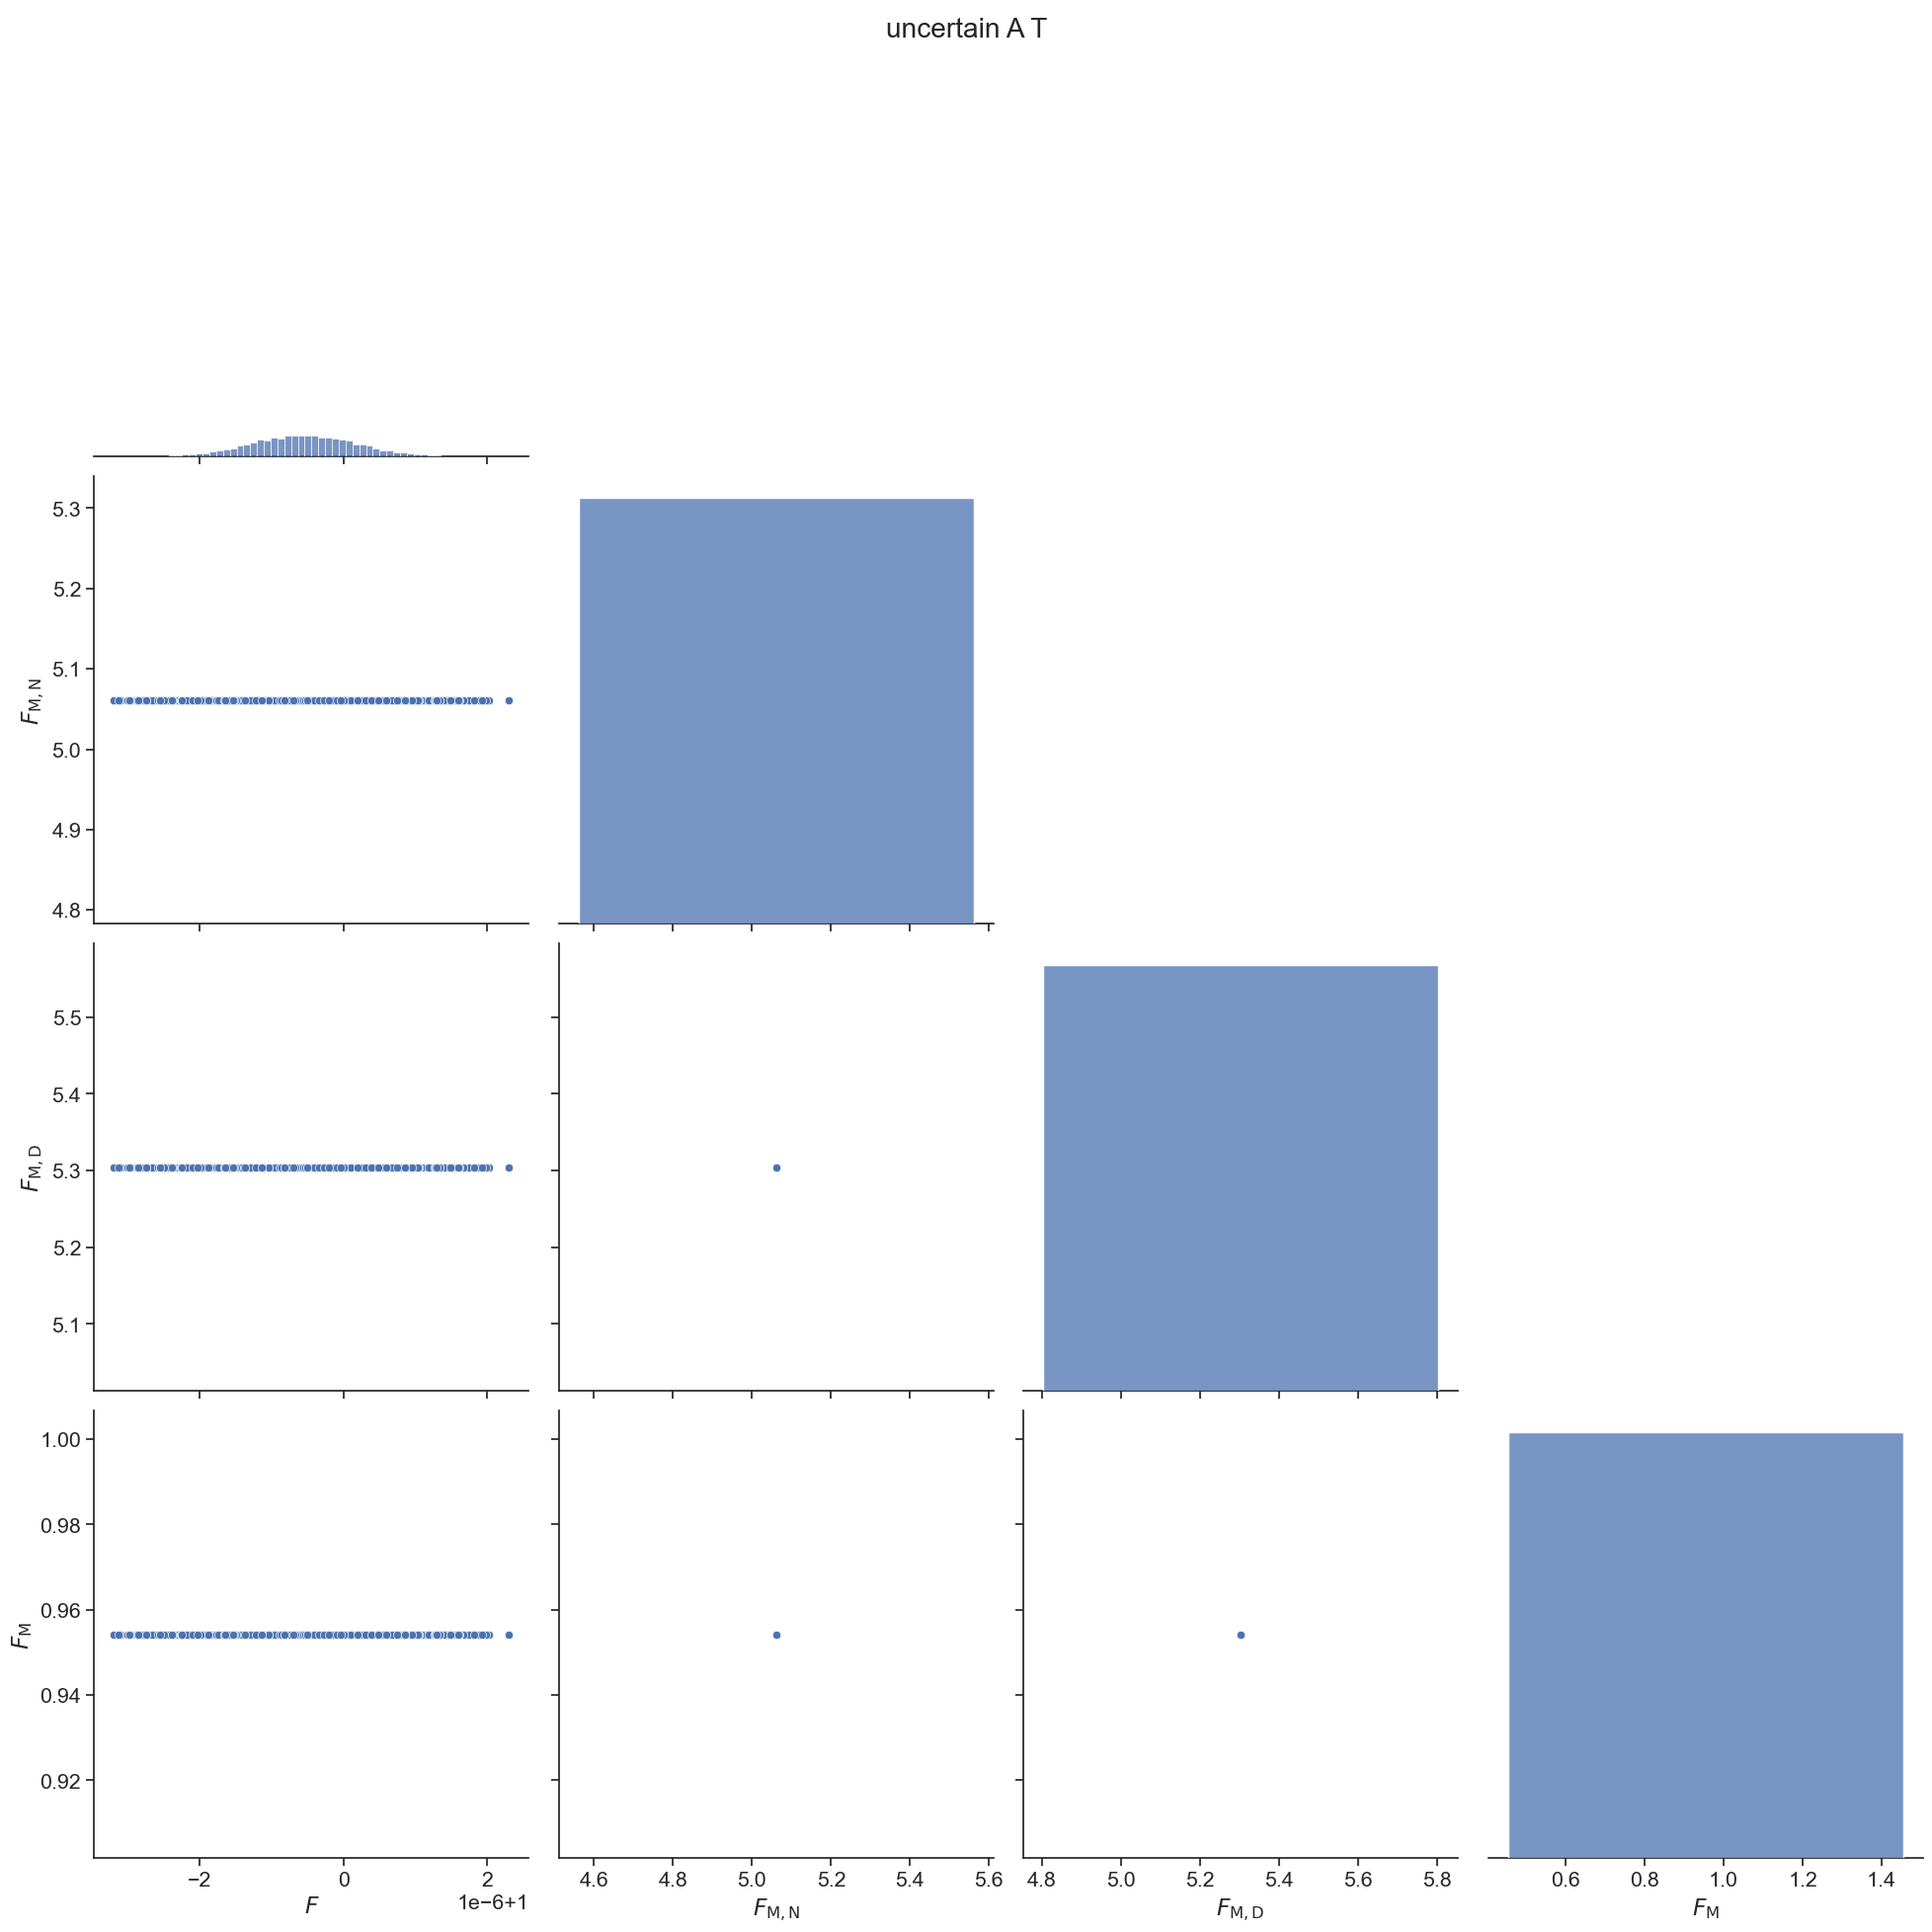

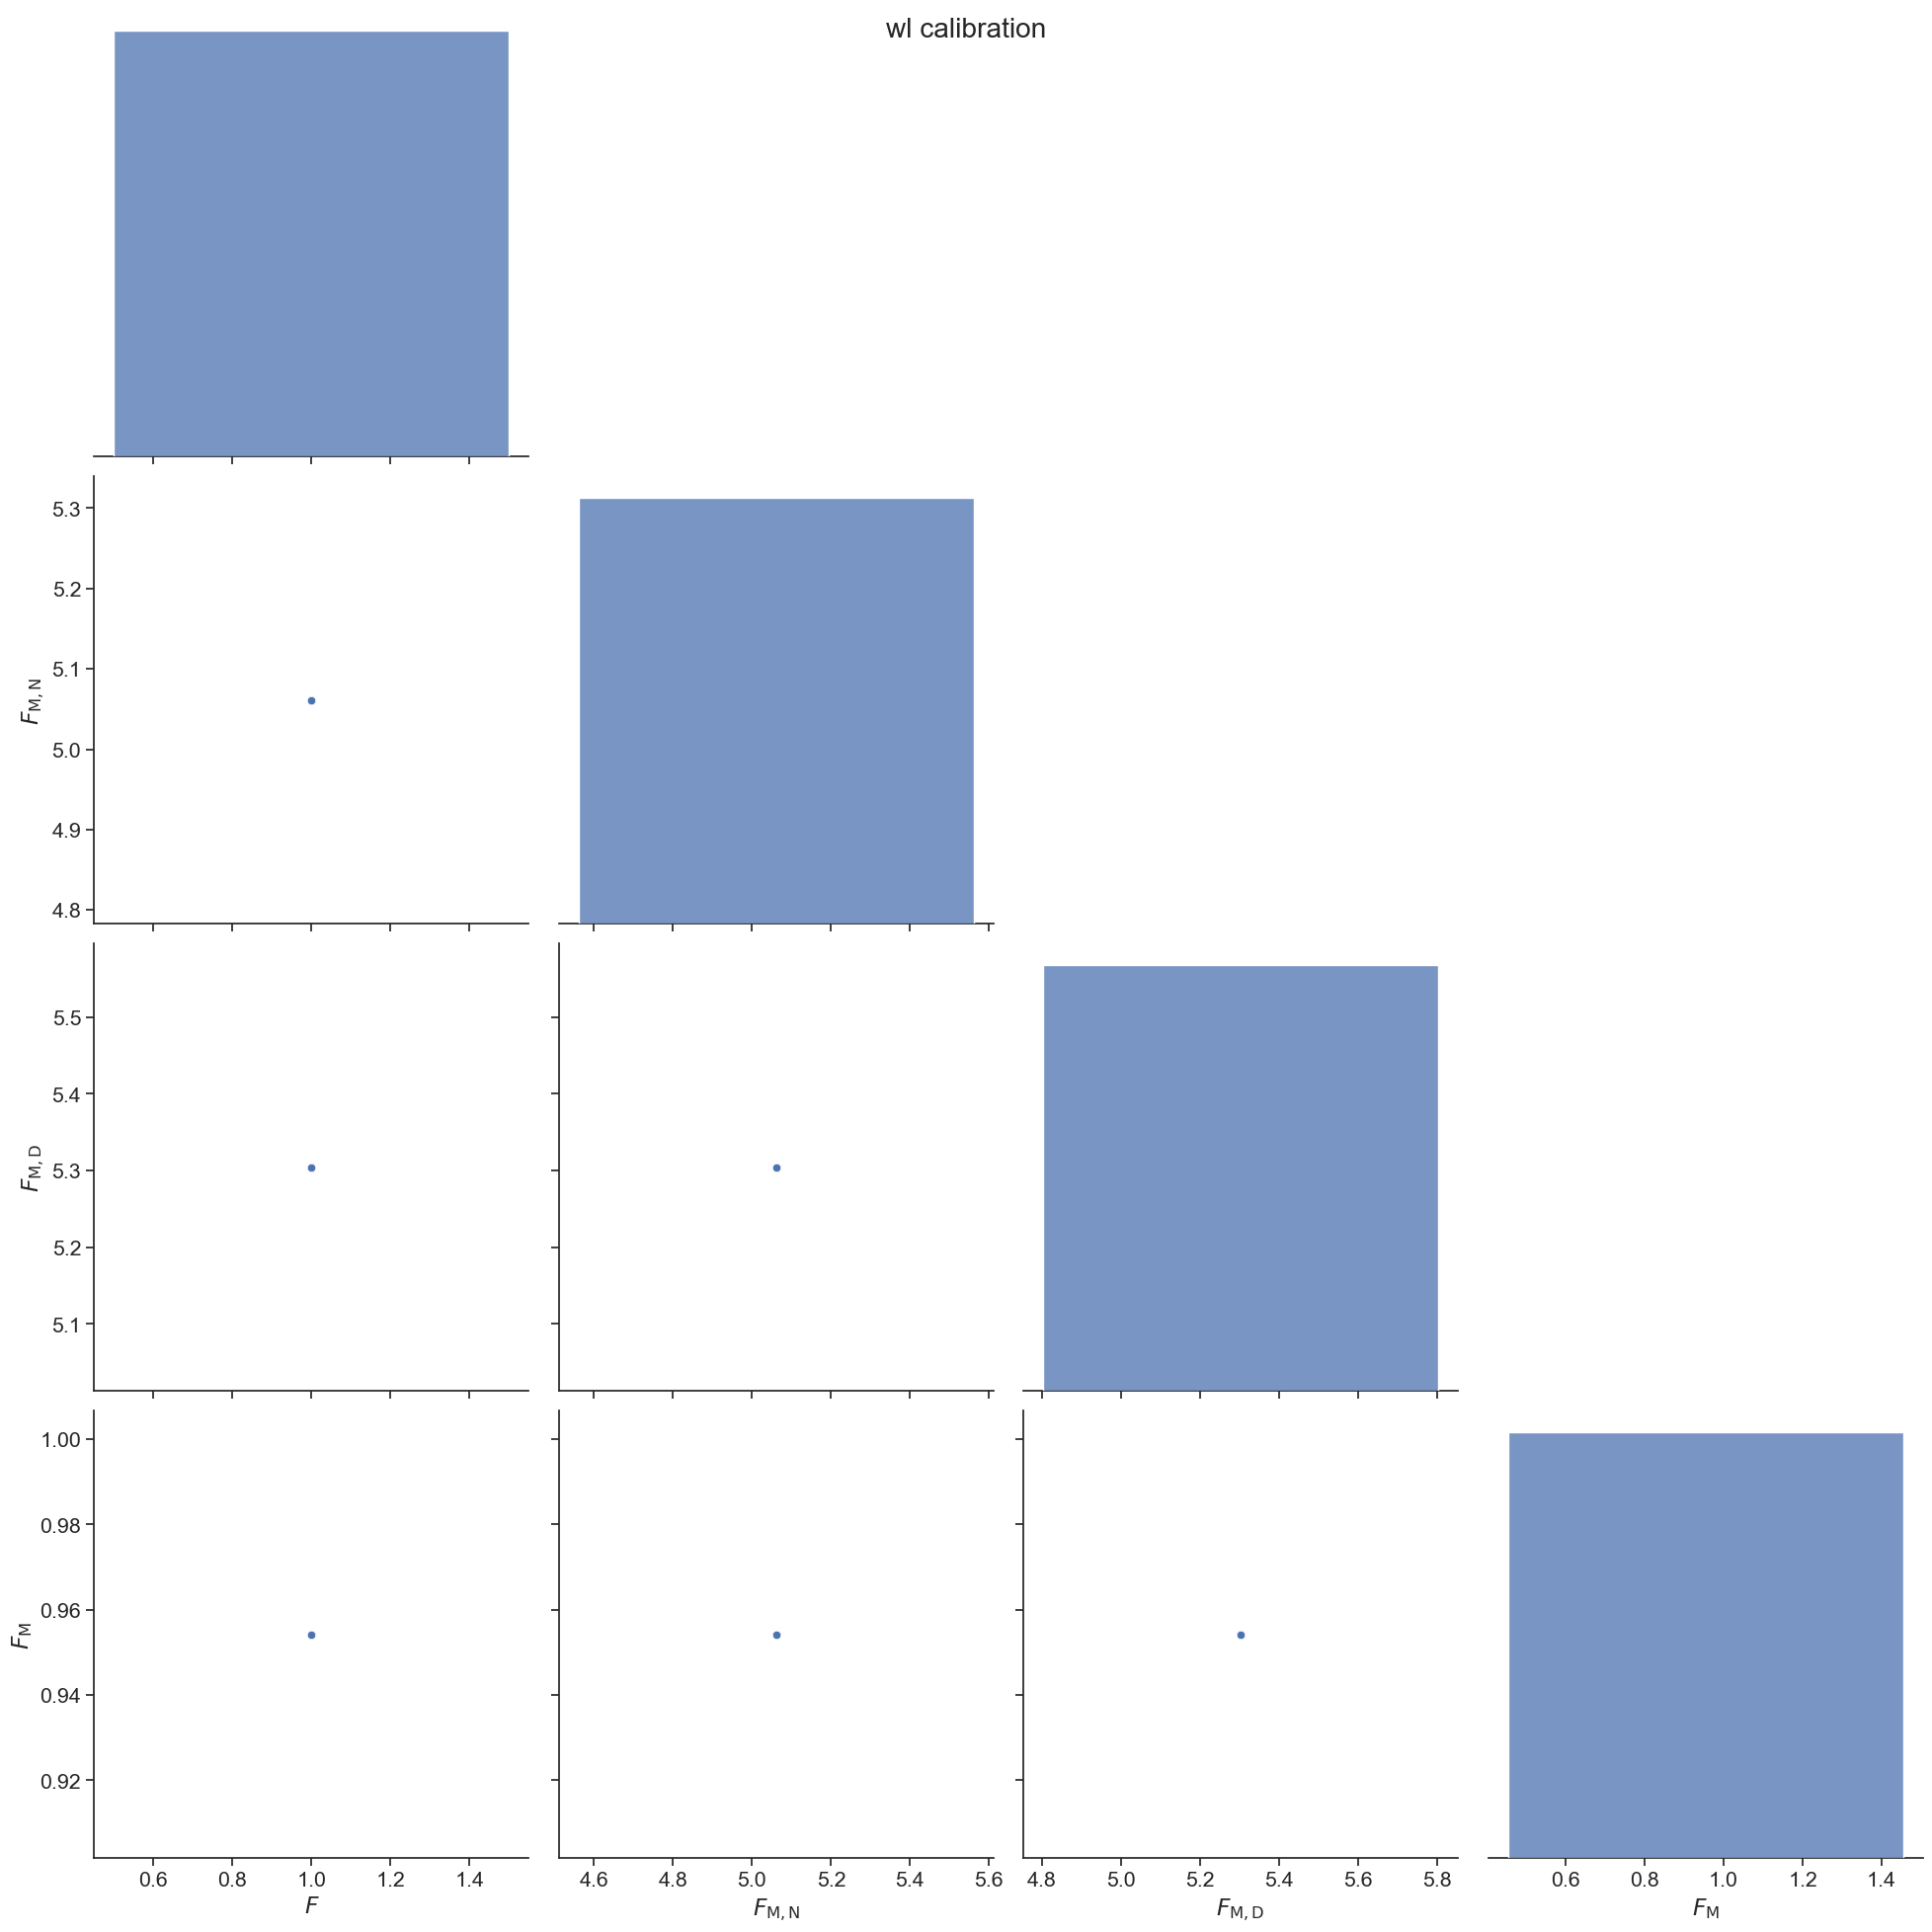

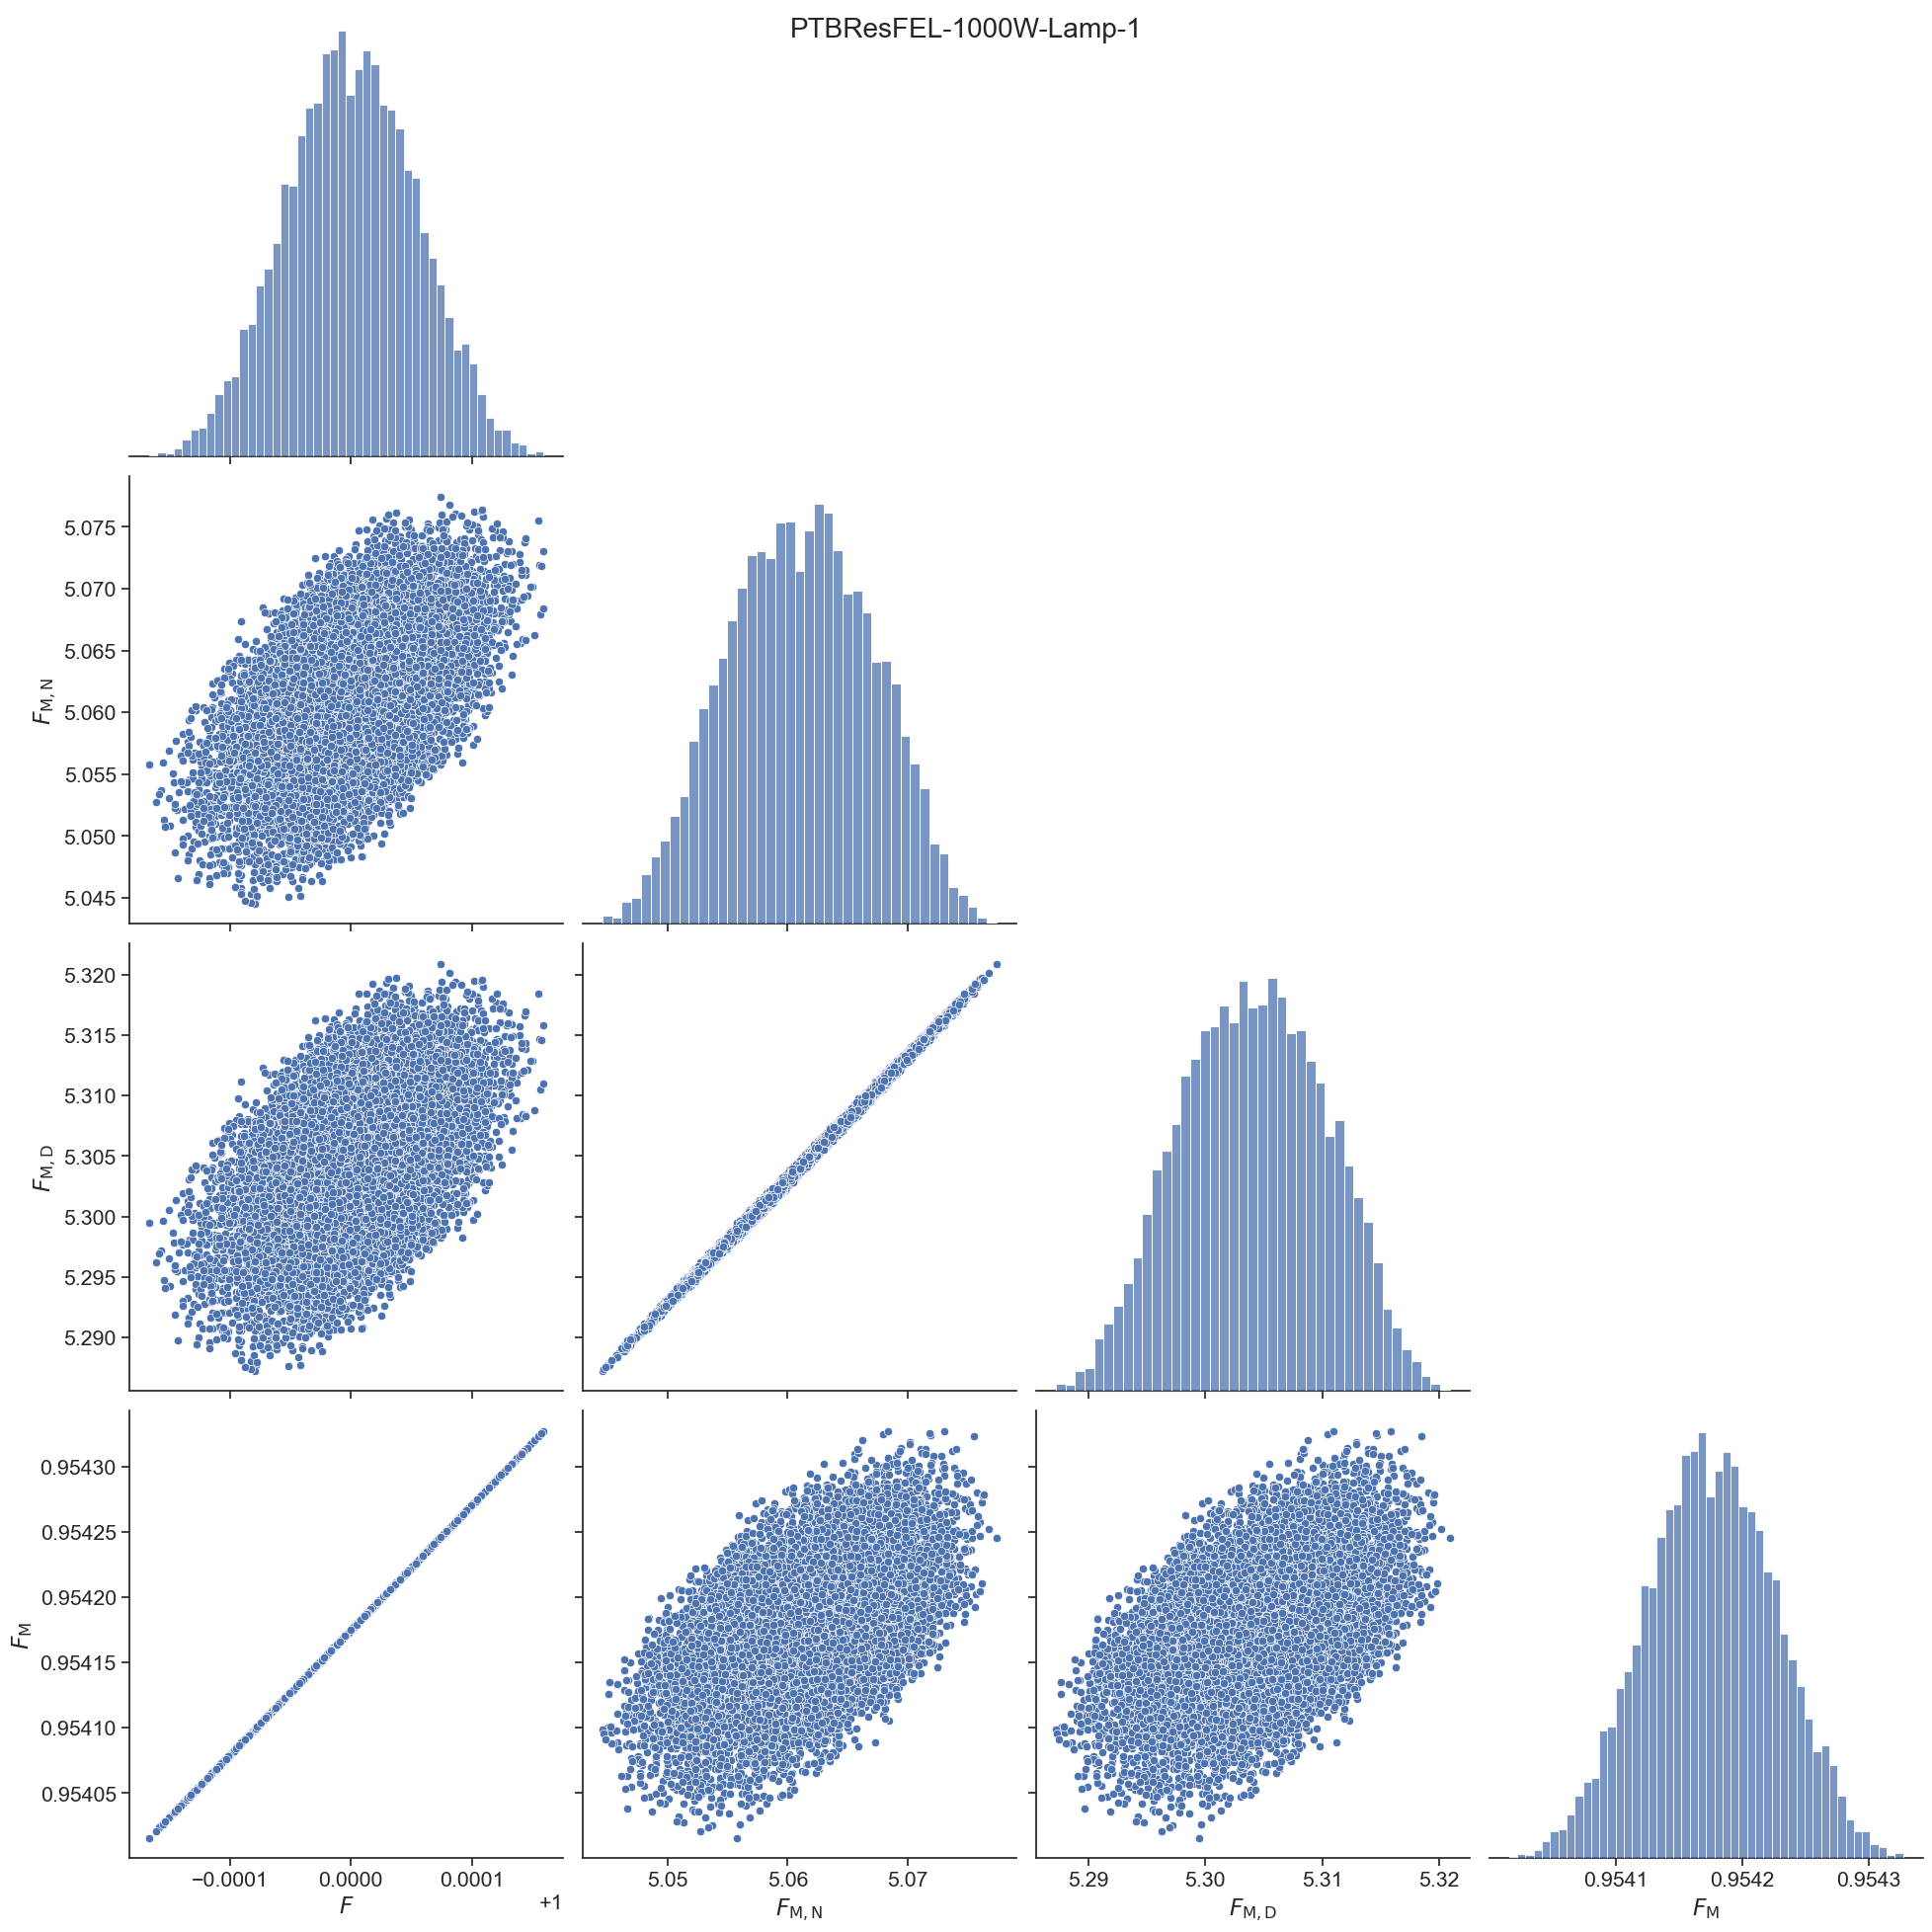

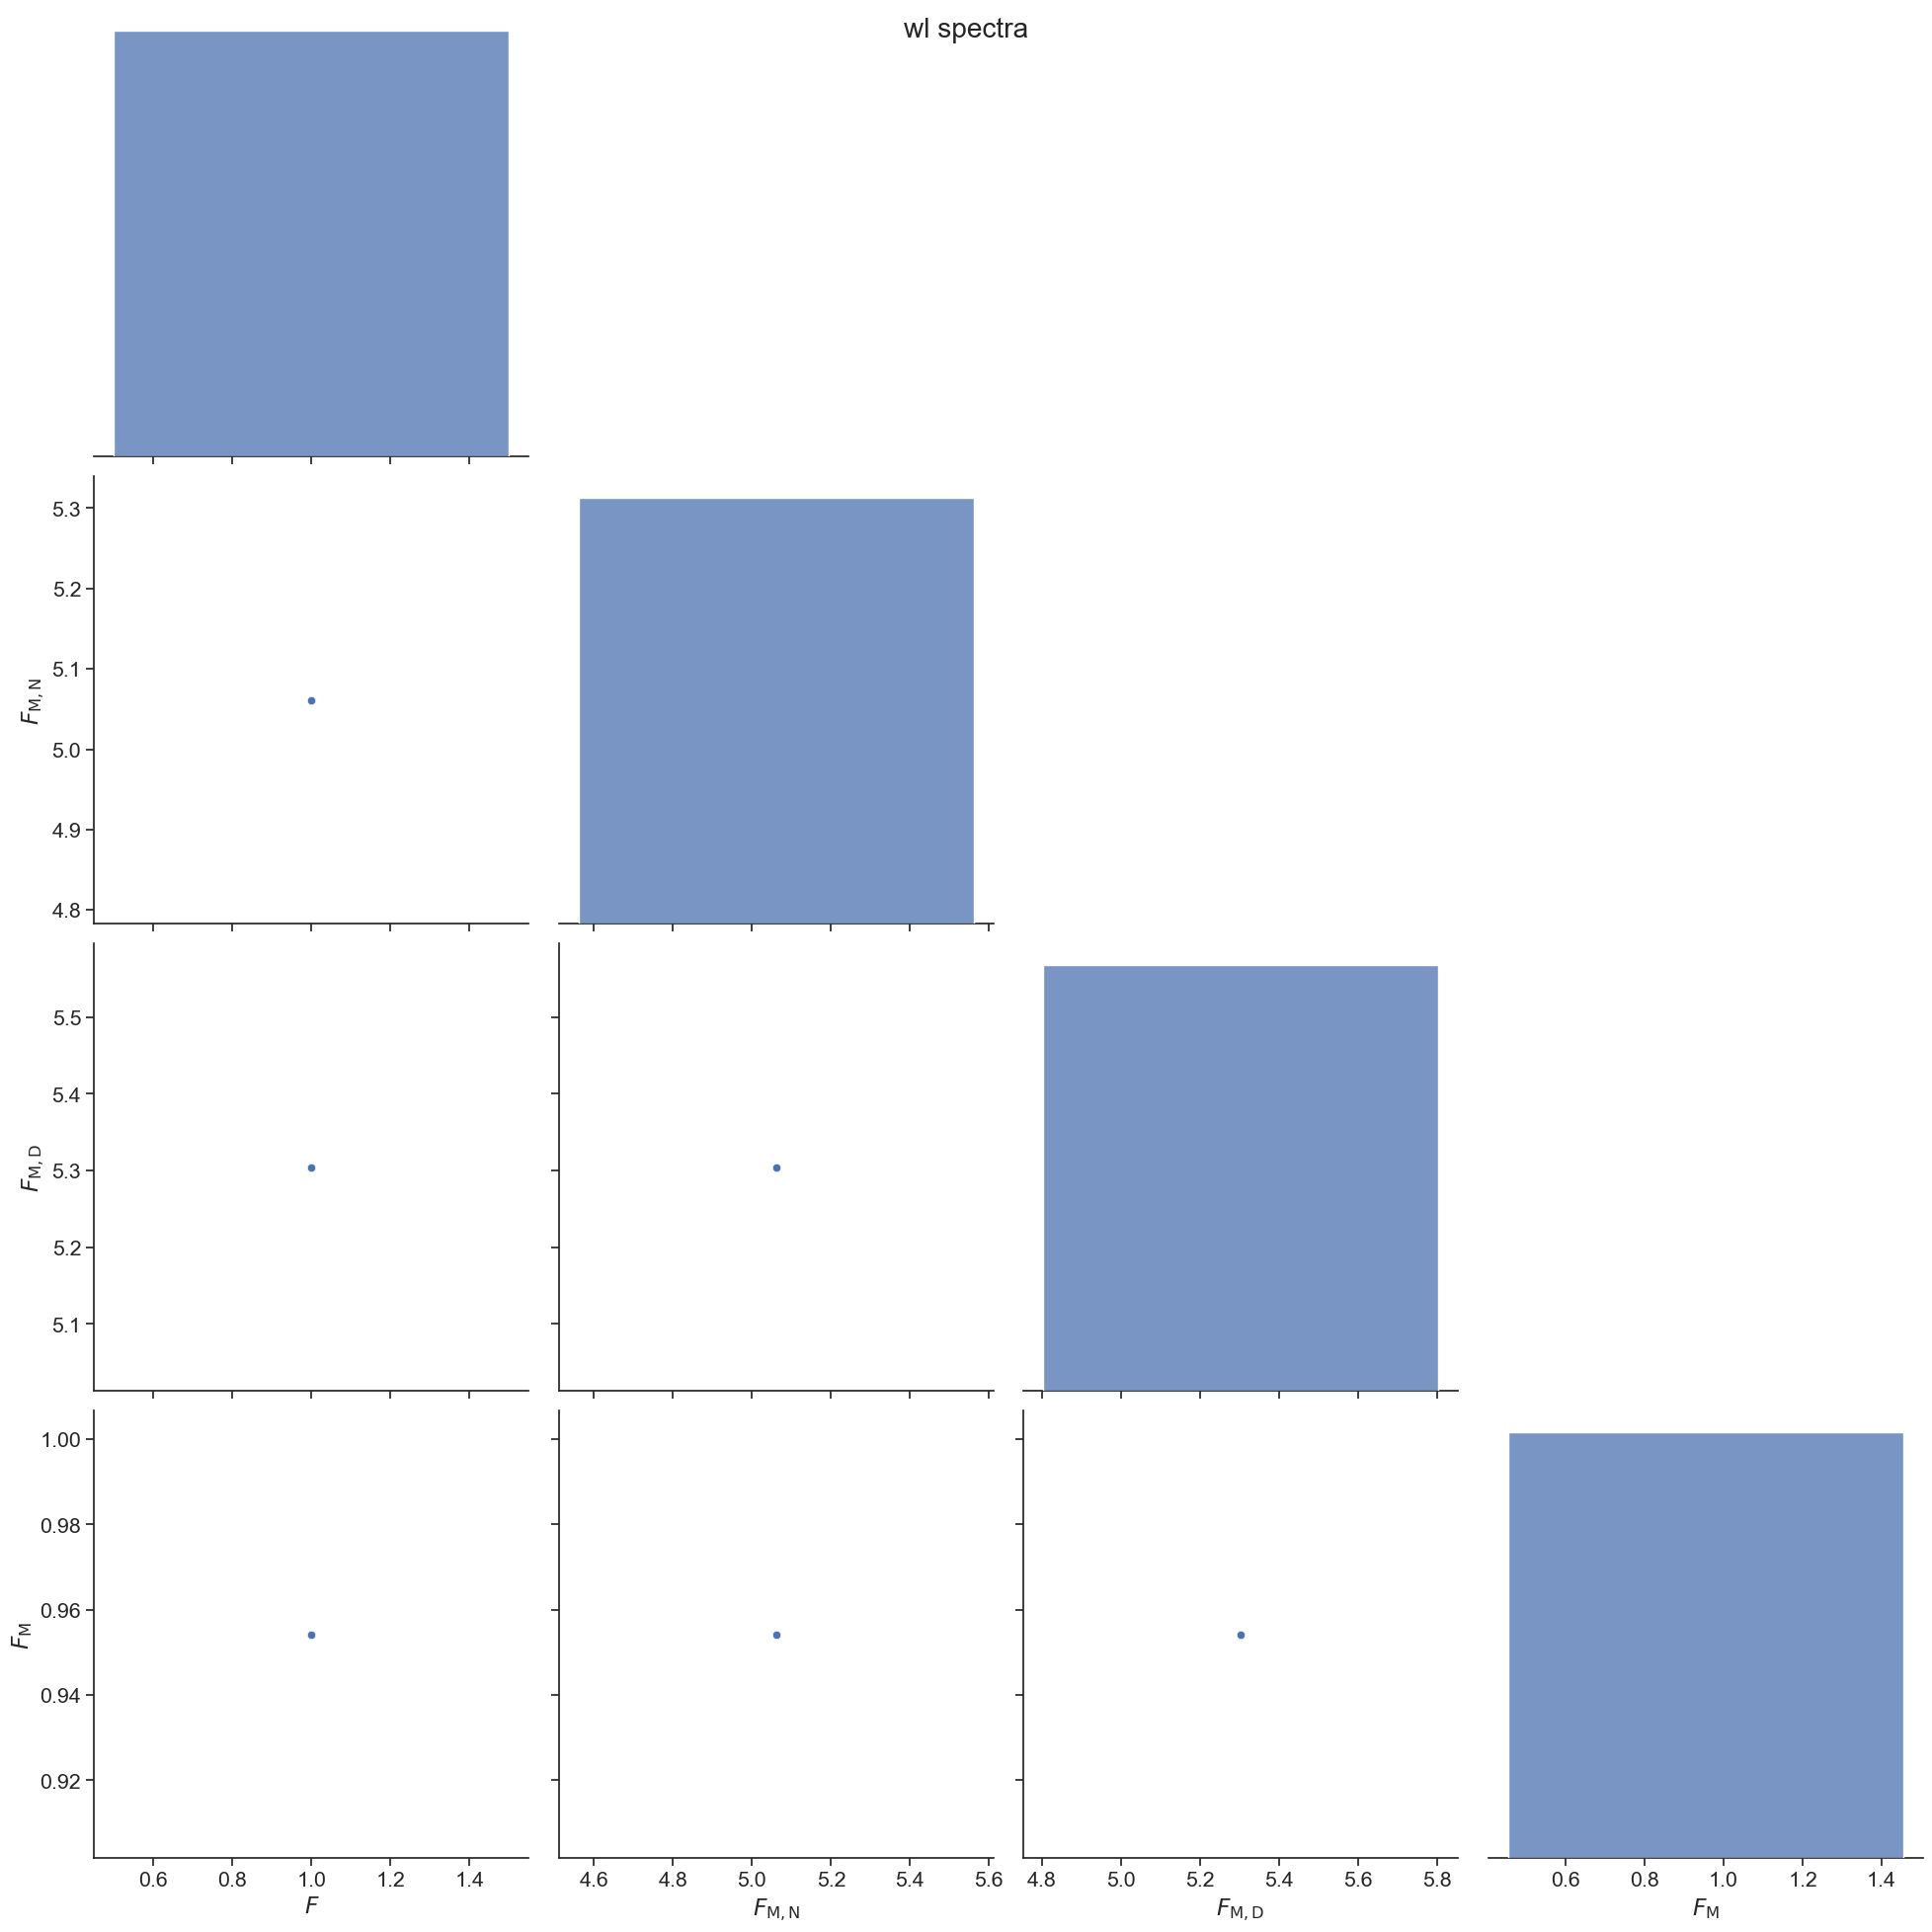

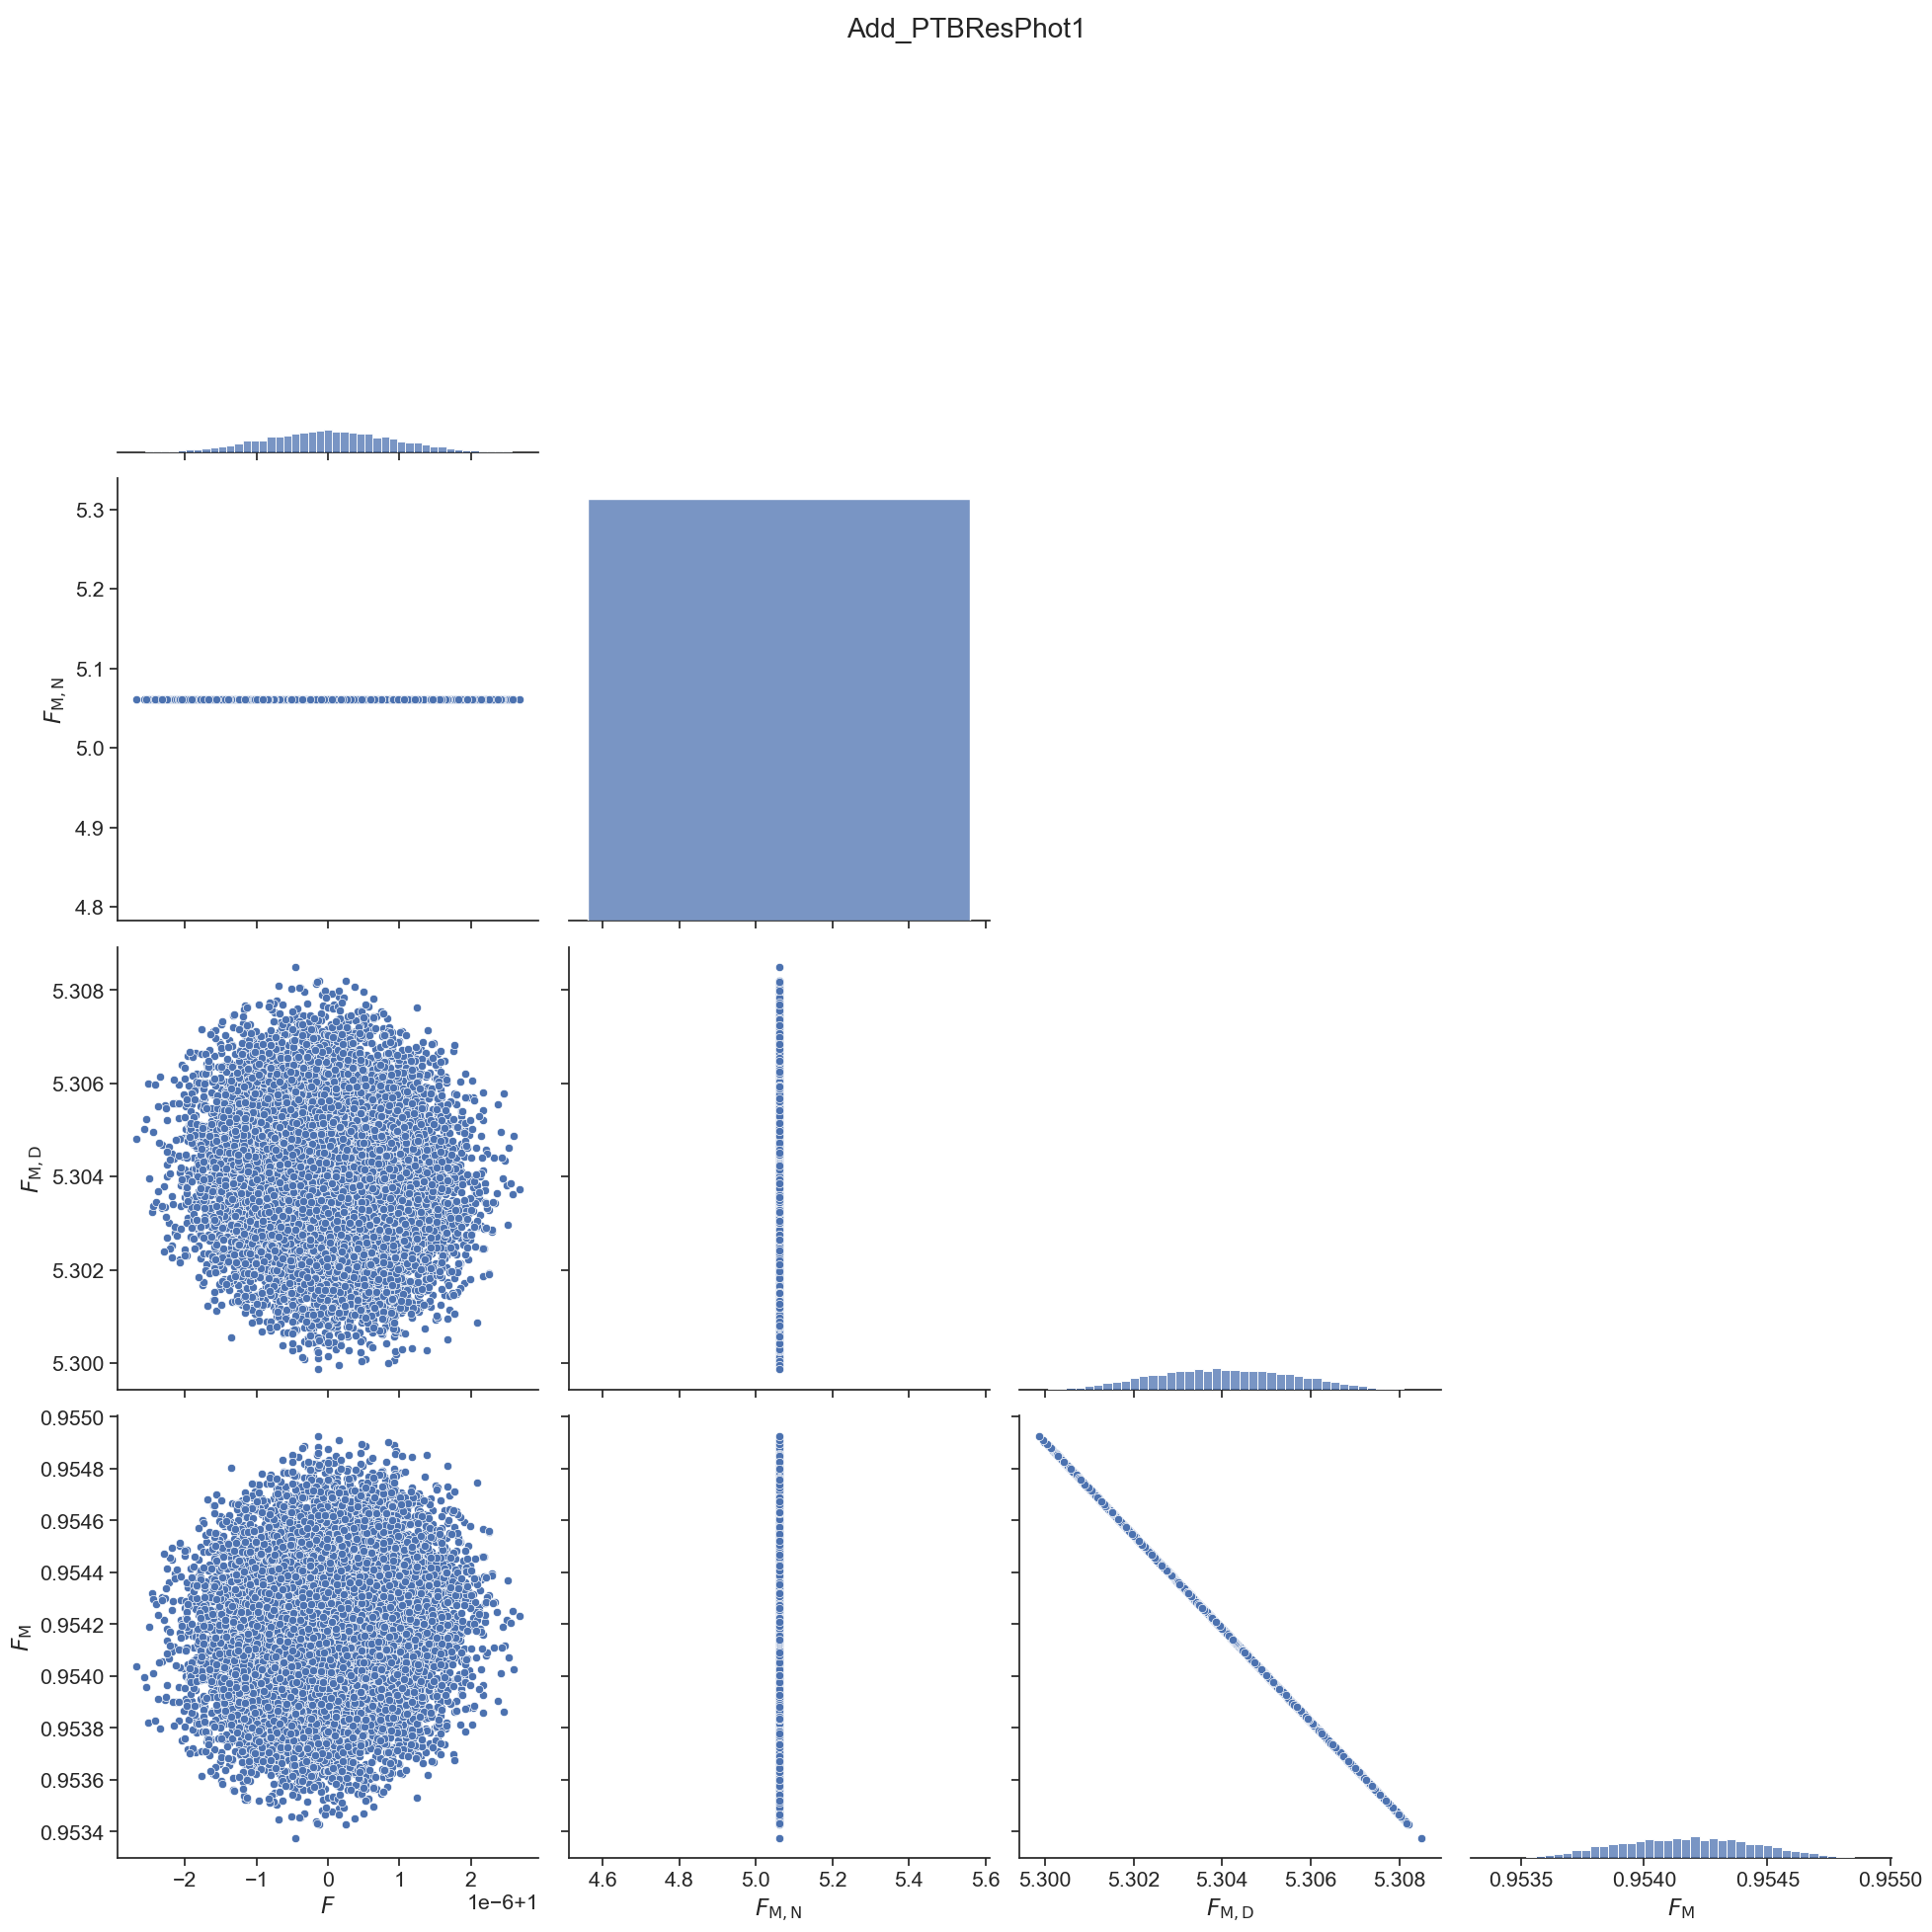

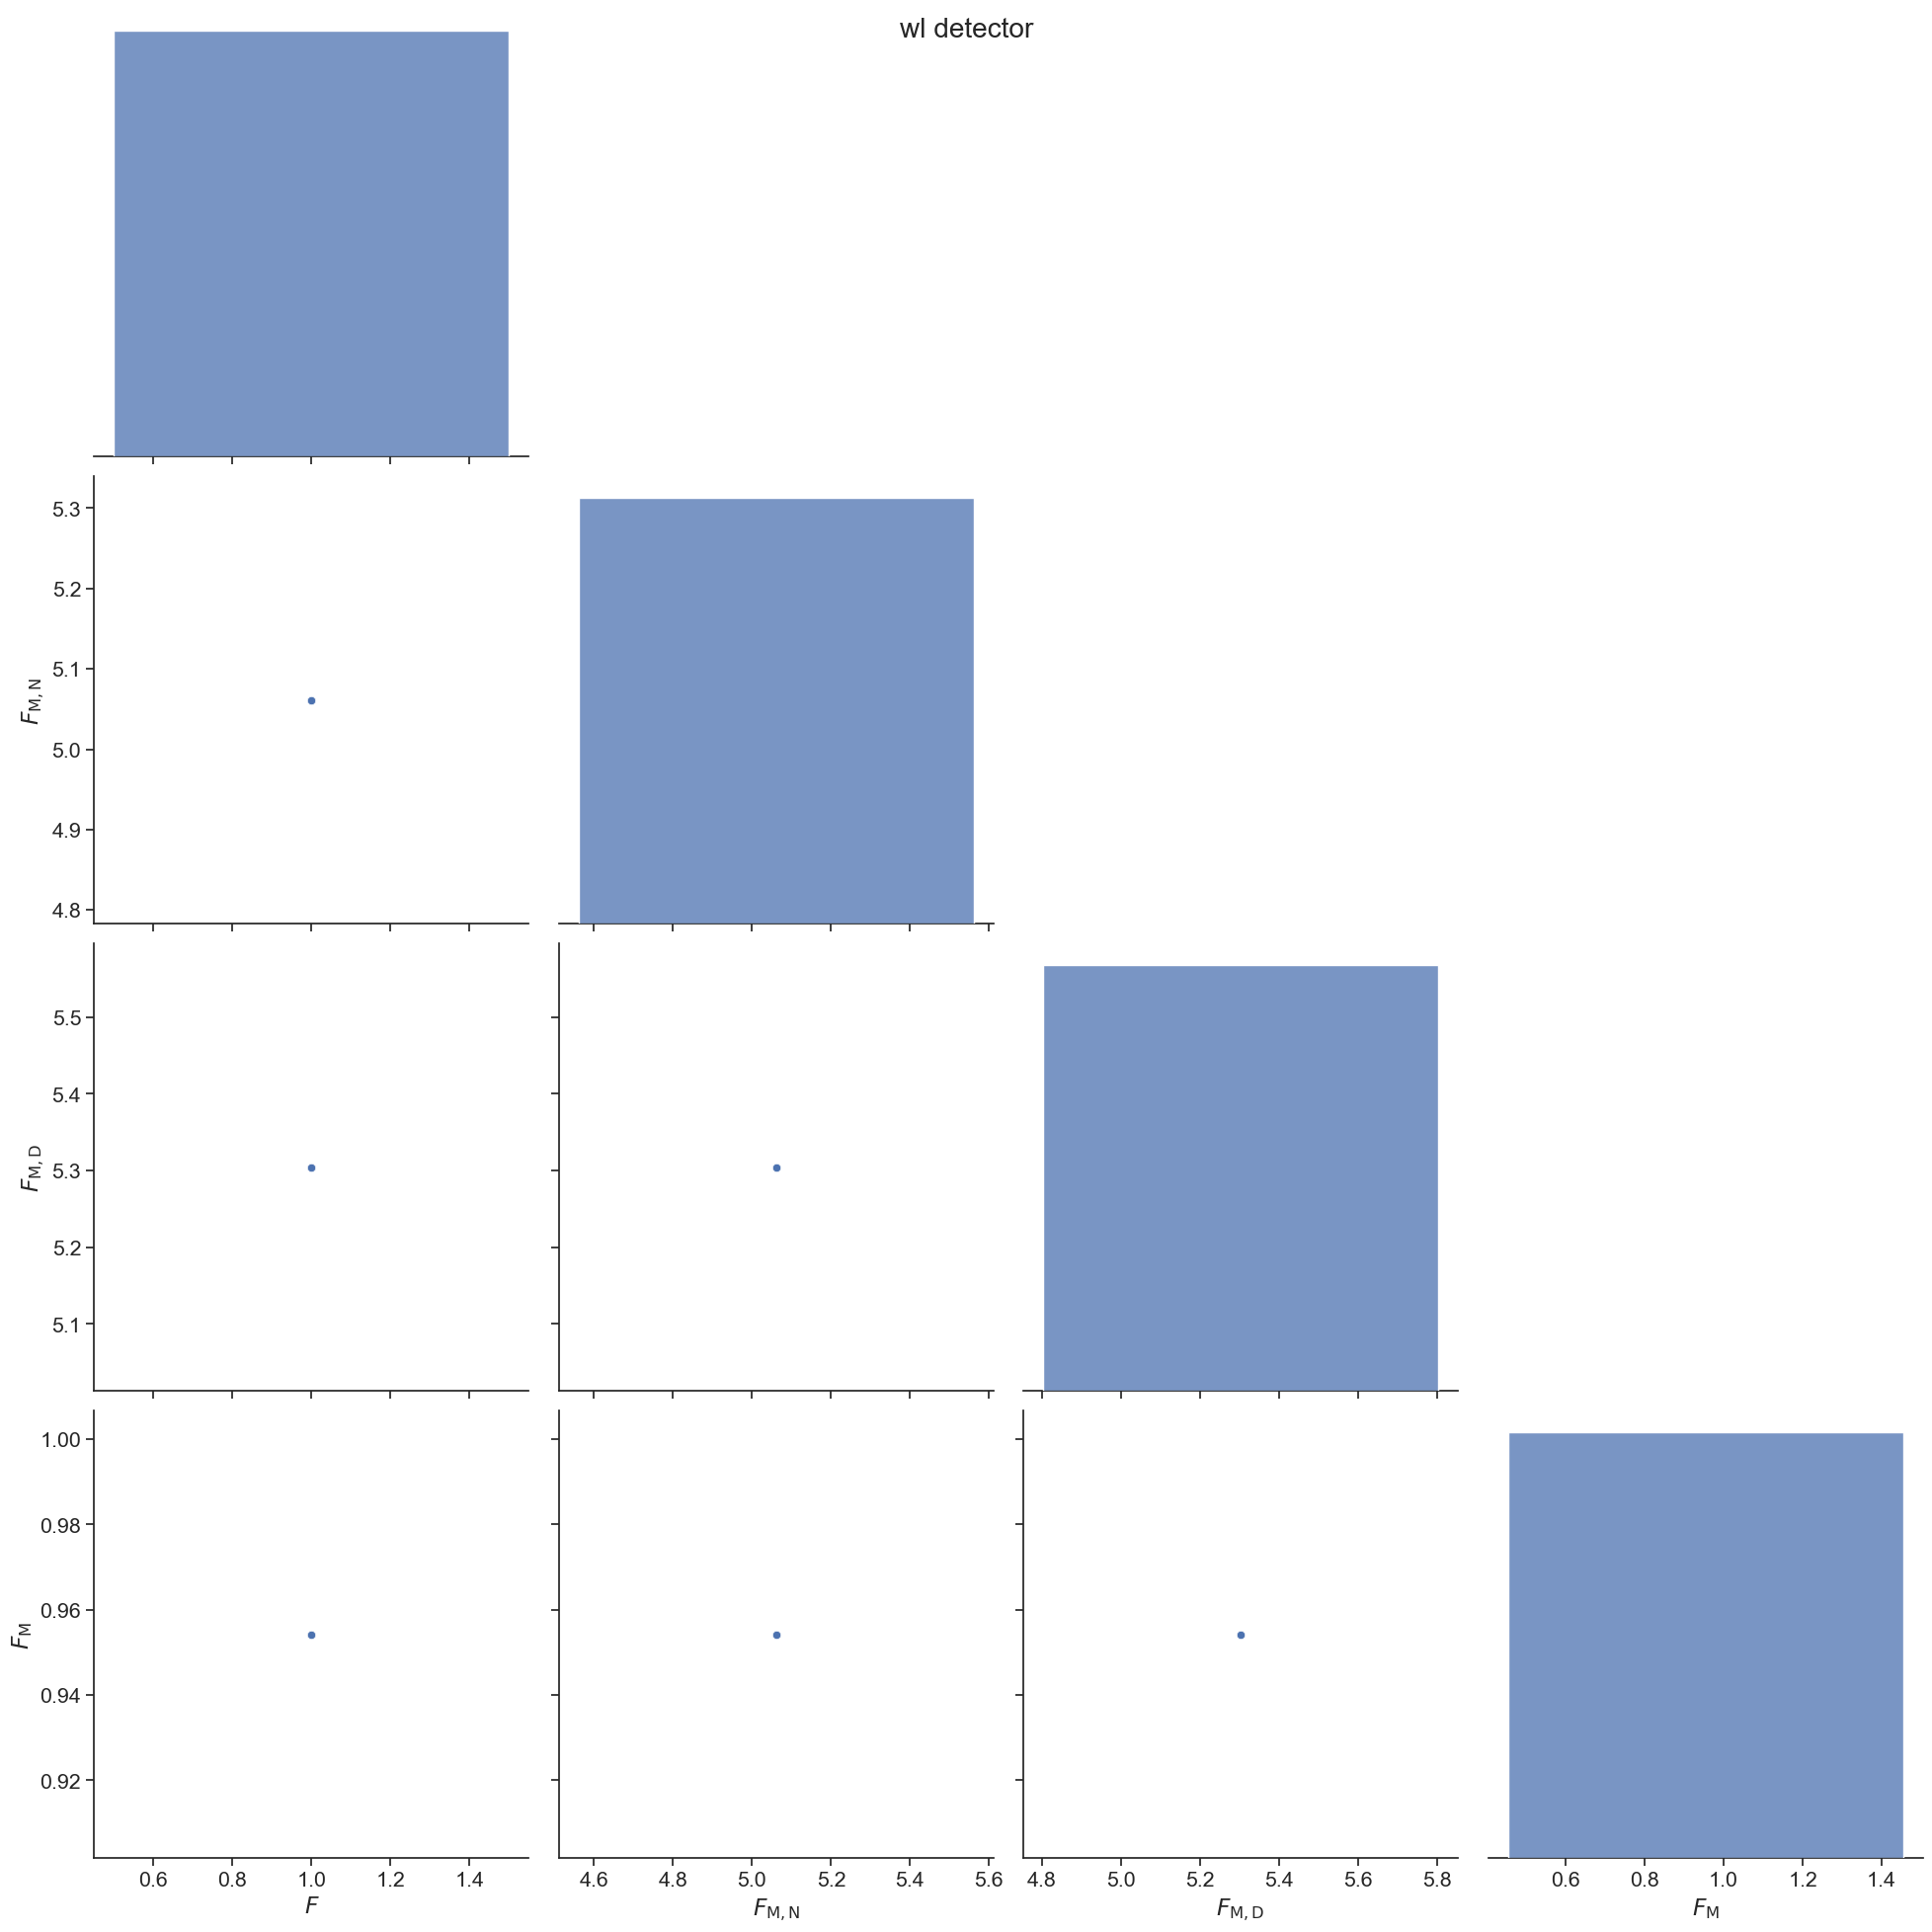

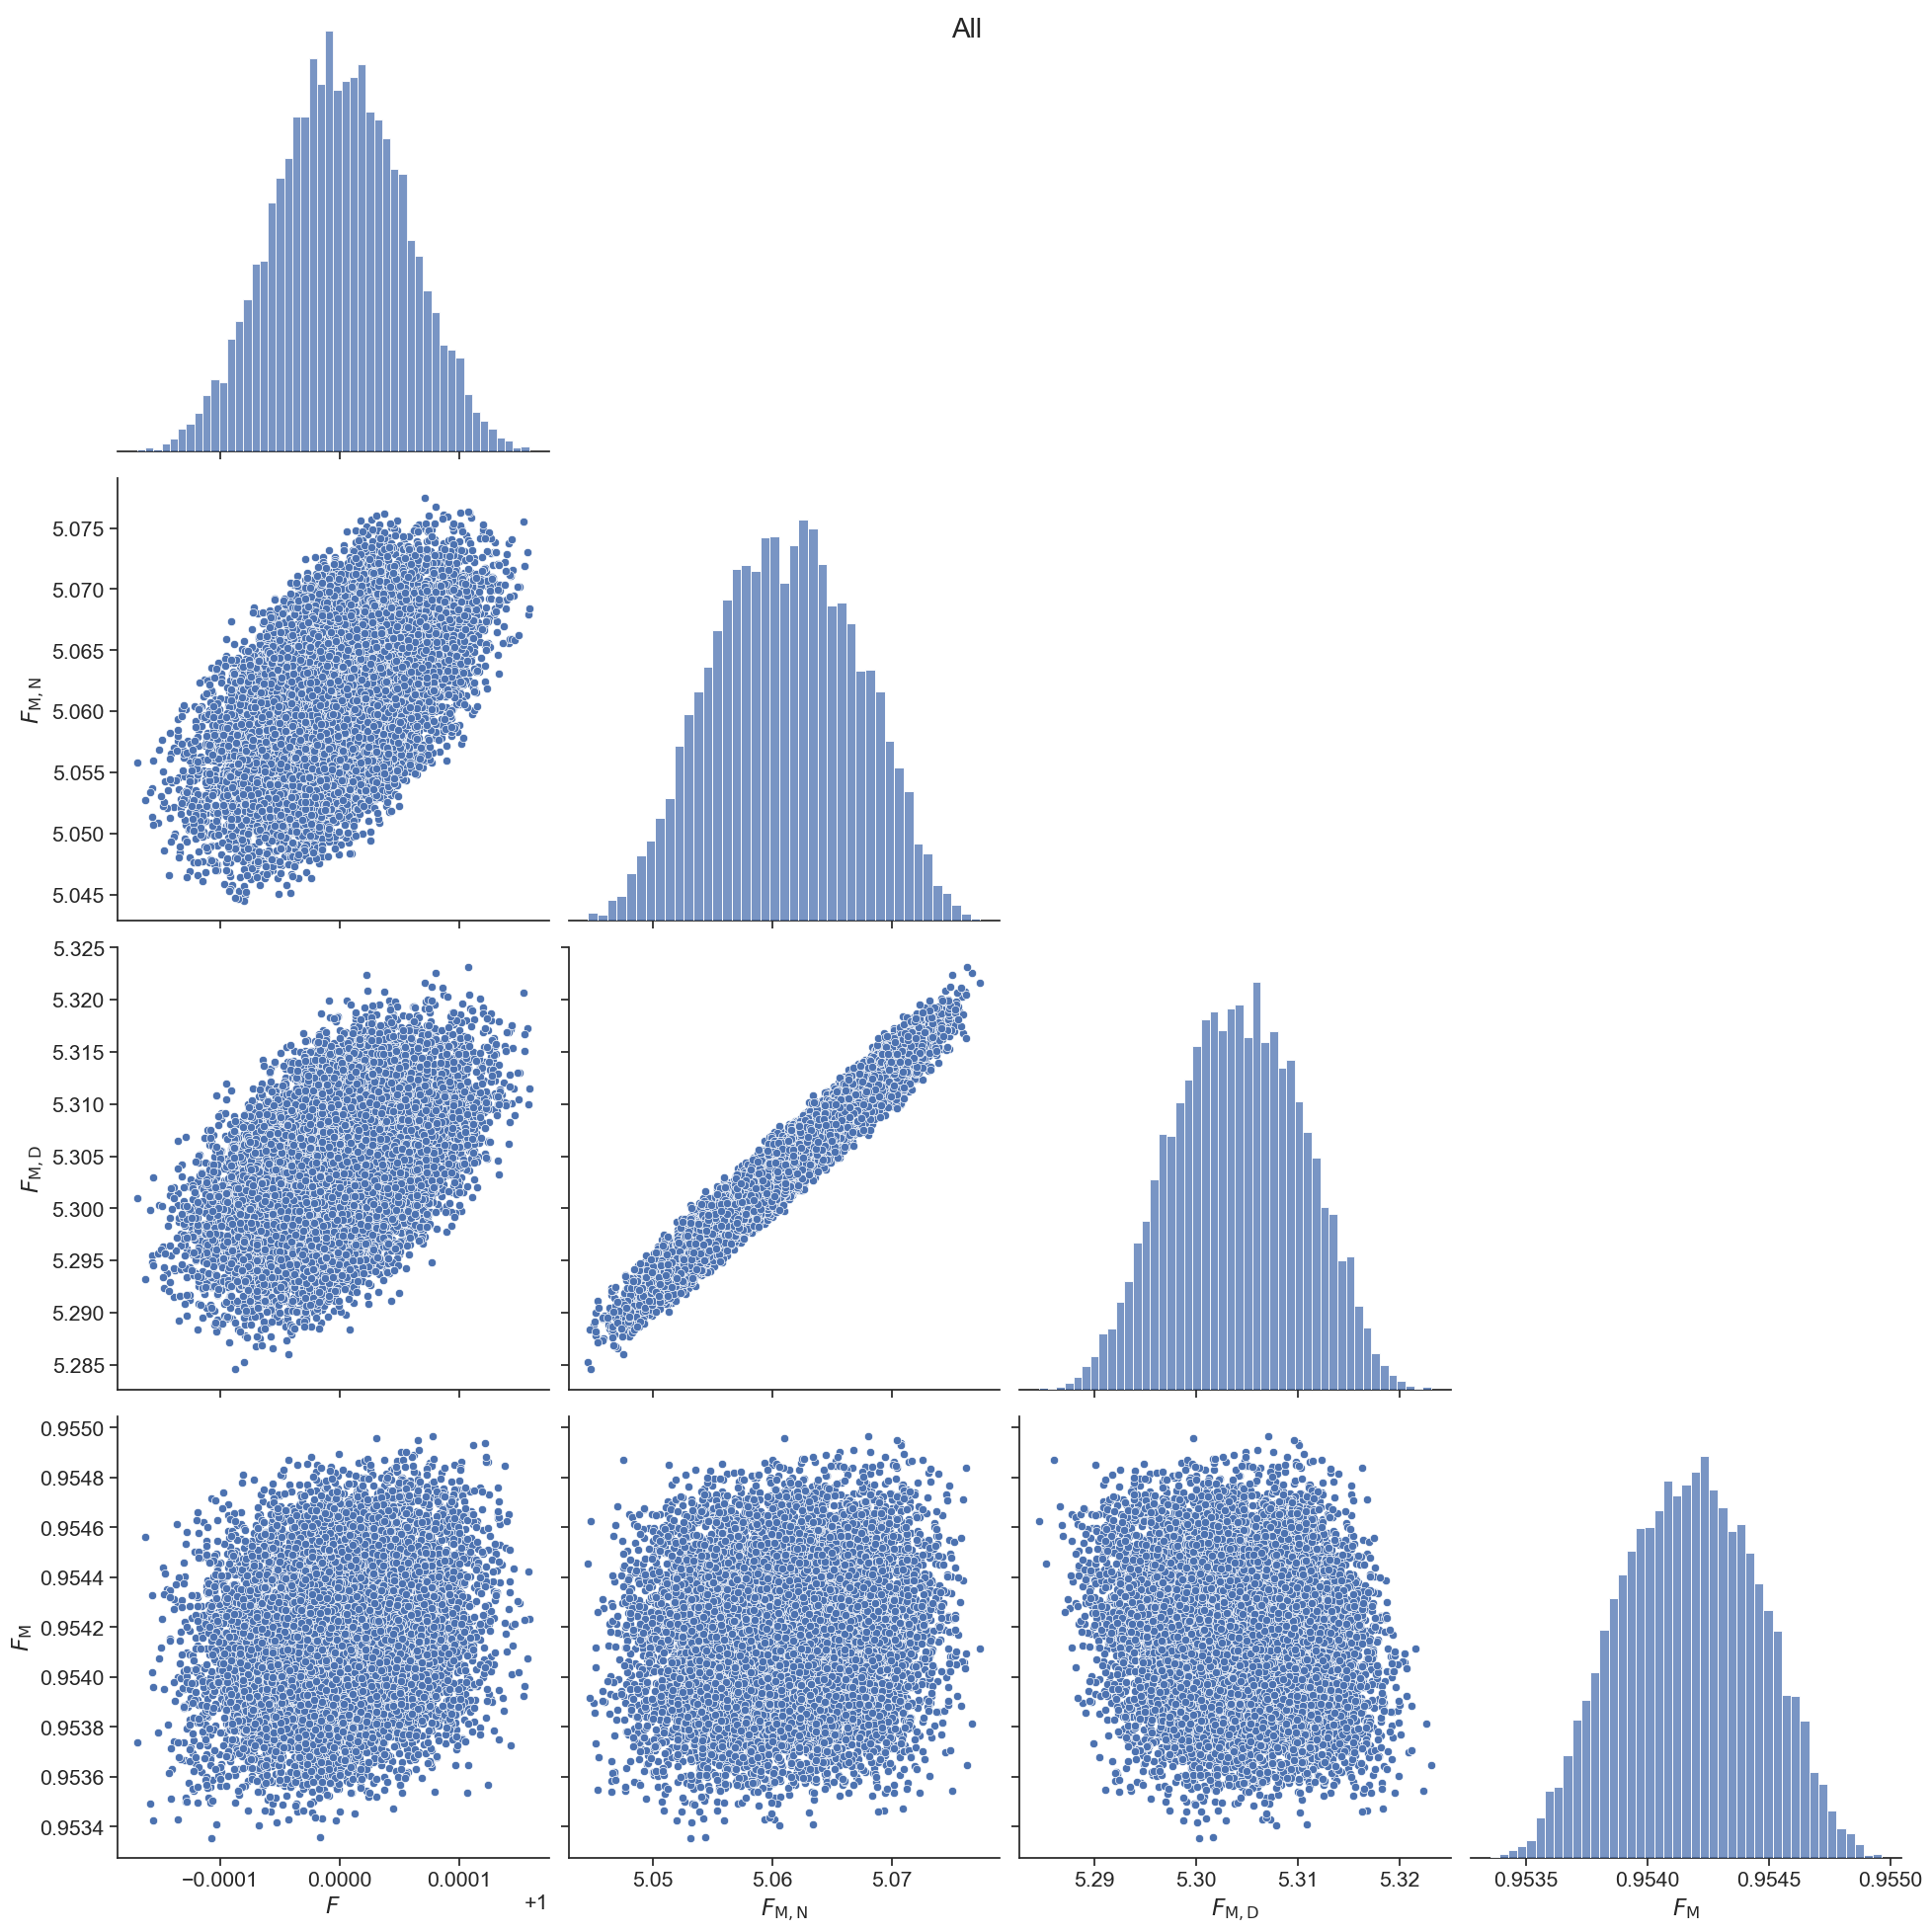

In [31]:
# use selected data only (F, F_C and F_M)
display_list = [0, 3, 4, 6]
for i in range(len(mcResult)):
    var = mcResult[i][0].val.T
    seaborn_plot_result_gen(
        np.vstack([var[display_list[_j]] for _j in range(len(display_list))]),
        display=['n' for _ in range(len(display_list))], dim=len(display_list),
        column_str=[get_item_name(display_list[_i], use_math=False) for _i in range(len(display_list))], title=get_name(i), fontsize=label_font_size)
    save_fig(out_dir, 'SecondCorr' + str(i))

In [32]:
break

SyntaxError: 'break' outside loop (370545404.py, line 1)

In [ ]:
from empir19nrm02.MC import generate_base_functions
import pandas as pd
from empir19nrm02.tools import sumMC

def FourierTableSMCF( trials, wl, SD, uSD, Detector, uDetector, mode = 'f', single = ' '):
    wl_elements = wl.shape[0]
    print( wl_elements)
    #elements2Run = [10]
    petriTable = pd.DataFrame()
    rMatrixSD = np.zeros((trials, wl.shape[0]))
    detector_tmp = np.vstack((wl, Detector))
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_base_functions( mode + ' ' + str(numberNew) + ' o' + single, wl_elements, uSD)
            rMatrixSD[j] = (1+rMatrix)*SD
        tmp_data =np.vstack(( wl, rMatrixSD))
        SMCF_g, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( tmp_data, detector_tmp, S_C='A', cieobs='1931_2', s_target_index=2, use_ref=False, use_global_ref=False)

        # SMCF
        [SMCFvalues, SMCFinterval] = sumMC(SMCF_g, Coverage=0.95)
        # SMCF_C
        [SMCF_Cvalues, SMCF_Cinterval] = sumMC(F_C_N/F_C_D, Coverage=0.95)
        # SMCF_M
        [SMCF_Mvalues, SMCF_Minterval] = sumMC(F_M_N/F_M_D, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'SMCF': SMCFvalues[0], 'SMCF_std': SMCFvalues[1], 'SMCF_95%': (SMCFinterval[1]-SMCFinterval[0])/2., \
            'SMCF_C': SMCF_Cvalues[0], 'SMCF_C_std': SMCF_Cvalues[1], 'SMCF_C_95%': (SMCF_Cinterval[1]-SMCF_Cinterval[0])/2., \
            'SMCF_M': SMCF_Mvalues[0], 'SMCF_M_std': SMCF_Mvalues[1], 'SMCF_M_95%': (SMCF_Minterval[1]-SMCF_Minterval[0])/2., \
             } , dtype = 'float')

        petriTable = pd.concat( [petriTable, df])
        print( numberNew, end=' ')
    return petriTable

In [ ]:
petriTableSMCF=FourierTableSMCF(trials, wl, mcVectorVarFEL.setData.v_mean, 0.005, mcVarDetector.setData.v_mean, 0.01, mode = 'f', single=' ')
petriTableSMCF.to_excel(out_dir + '/' +  'FourierSMCF_f.xlsx')
petriTableSMCF

In [ ]:
lines =petriTableSMCF.shape[0]
eval=np.zeros((lines, 5))
eval[:,0]=petriTableSMCF["N"].to_numpy().T
eval[:,1]=petriTableSMCF["SMCF_M_95%"].to_numpy().T
xNumber = range(lines)
fig = pyplot.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlabel(r"number of the investigation",fontsize=label_font_size)
ax1.set_ylabel('U($F_\mathrm{M}$) / A.U.',fontsize=label_font_size)
ax1.plot(xNumber, eval[:,1], 'r-o', label='Python F')
pyplot.axhline(ref_mu)
new_tick_locations = range( lines)
def tick_function(X):
    return ["%d" % elements2Run[z] for z in X]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Number of base functions",fontsize=label_font_size)
ax1.legend(frameon=False, fontsize=label_font_size)
ax1.grid(visible=False)
ax2.grid(visible=False)
save_fig(out_dir, 'SMCF_M_Table1')